# Confirmation Bias Project
## Behavioural analyses
#### Experiment 3 CJ
In this version of the experiment (1.4) we wanted to compared the same subjects under repeated or similar sequences. We only presented 1 repetition and importantly, I also gathered the participants confidence in their response.mm

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

__Metadprime is computed using the library from:__

pip install git+https://github.com/LegrandNico/metadPy.git

##### Import important functions and libraries

In [1245]:
import os, glob
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
#import ptitprince as pt
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [1246]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

def split_confi(x):
    x.insert(19, 'conf_lvl', 'L')  
    s = np.mean(x.confi)
    x.loc[s <= x.confi, 'conf_lvl'] = 'H' 
    #x.insert(5, 'conf_mean', s) 
    return x

### Data & variables

In [1373]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 


results_path = '/home/freeman/Insync/alexisperez@ub.edu/OneDrive Biz/PROJECTS/Condcision/Behav_data/Behavioral/condcisionCJ/' #

os.chdir(results_path) # change the current working directory to the results path 

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations


nsubj = 0 # initialize subjects counter

for file in sorted(glob.glob("*.psydat")): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_path, file),"rb")
    nsubj = nsubj + 1
    dat = pickle.load(pfile)
    for block in dat['main_exp']['Exp_blocks']:
        dvdata = pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])
        ddata = pd.concat([block['data'], dvdata, block['trial_orientations']], axis = 1)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    subjdata.insert(0, 'npar', nsubj)
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject

all_df.head(10)


npar subj  nblock  ntrial  nrep  blocktype  trial_type  cond    DV  resp  \
0     1  s01       0       0     0  nonrepeat       False     1  0.08   1.0   
1     1  s01       0       0     1  nonrepeat       False     1  0.08   1.0   
2     1  s01       0       1     0  nonrepeat       False    -1 -0.01   1.0   
3     1  s01       0       1     1  nonrepeat       False    -1 -0.01  -1.0   
4     1  s01       0       2     0  nonrepeat       False    -1 -0.11  -1.0   
5     1  s01       0       2     1  nonrepeat       False    -1 -0.11   1.0   
6     1  s01       0       3     0  nonrepeat       False     1  0.11   1.0   
7     1  s01       0       3     1  nonrepeat       False     1  0.11   1.0   
8     1  s01       0       4     0  nonrepeat       False    -1 -0.01  -1.0   
9     1  s01       0       4     1  nonrepeat       False    -1 -0.01   1.0   

   r_map  correct  confi        RT        d1        d2        d3        d4  \
0     45        1   0.10  2.044453  0.828372 -0.956710  0.360338 -0.087842   
1      0        1   0.35  2.114065 -0.186164 -0.022671  0.287481  0.530953   
2     45       -1   0.75  1.752747  0.840586 -0.430107  0.129599  0.858411   
3     45        1  -0.15  1.981836 -0.668958  0.911887  0.596642  0.846197   
4     45        1   0.40  2.481966 -0.637881  0.462198 -0.473916  0.087865   
5     45       -1   0.70  1.398619 -0.197340  0.444372  0.665916 -0.903752   
6     45        1   0.60  1.405562  0.519729 -0.601240 -0.049645  0.634840   
7     45        1   0.25  1.301392  0.518220 -0.770817  0.939380  0.513127   
8      0        1  -0.10  3.336132  0.417352 -0.934829 -0.528901 -0.118918   
9     45       -1   0.70  1.197235  0.397498 -0.783031 -0.578322  0.823279   

         d5        d6     o1     o2     o3     o4     o5     o6  
0  0.939380 -0.549273  0.718  0.017  2.105  1.929  2.380  0.177  
1  0.415324 -0.616519  2.822  1.187  2.636  2.172  1.015  2.991  
2 -0.717341 -0.844146  0.848  1.347  2.698  0.841  0.111  1.632  
3 -0.812598 -0.861971  0.130  0.820  0.627  0.725  3.068  1.625  
4 -0.446895  0.491718  1.713  2.145  2.935  1.998  1.788  0.985  
5  0.329781 -0.864518  1.886  2.138  2.225  1.533  2.093  1.624  
6  0.319076 -0.260012  0.974  2.985  1.944  0.642  0.518  2.851  
7  0.375617 -0.952654  2.167  0.090  2.380  2.165  2.111  3.123  
8  0.922592  0.326197  2.585  3.116  0.185  0.346  0.755  1.050  
9 -0.488158  0.678648  1.022  1.656  2.976  0.716  0.201  2.230

### Dataframe experiment 1: coding important variables

In [1374]:
df = all_df.copy() # copy tge variable

# relabeling some variables
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df.insert(5, 'cond-1', 0)    # 0 = previous Diag / 1 = previous Card
df['cond-1'] = df['cond'].shift(1, fill_value  = 0)

# Inserting deci variable
df.insert(9, 'deci', 0)
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(9, 'deci-1', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'corr-1', 0) # O = incorrect / 1 = correct
df.insert(7, 'rDV', 0) # rDV (real Decision Variable)
df.insert(10, 'deci-2', 0)    # 0 = 2 previous Diag / 1 = previous Card

# Recoding variables
df['deci-1'] = df['deci'].shift(1, fill_value  = 0) # deci in trial n-1
df['confi-1'] = df['confi'].shift(1, fill_value  = 0) # deci in trial n-2
df['corr-1'] = df['correct'].shift(1, fill_value  = 0) # correct in trial n-1


df['rDV'] = np.mean(df.iloc[:,20:26], axis = 1) # average DV
df.head(50)

## Eliminating inverted responses of some participants
df = df[~((df.subj == 's11') & (df.nblock == 1))]
df = df[~((df.subj == 's22') & (df.nblock == 1))]
df.reset_index(drop=True, inplace=True)

## df['nrep'] = df['nrep'].astype('category')
df['npar'] = df['npar'].astype('category')
df['nblock'] = df['nblock'].astype('category')
df['cond-1'] = df['cond-1'].astype('category')
#df['deci-1'] = df['deci-1'].astype('category')


# Confi split
df = df.groupby(['subj','nblock']).apply(split_confi) # probably confidence changes as the experiment progresses
df.reset_index(inplace = True)
df.insert(21, 'conf_lvl-1', 0)    # 0 = previous Diag / 1 = previous Card
df['conf_lvl-1'] = df['conf_lvl'].shift(1, fill_value  = 'L')

### Reaction Times 
##### Filter those responses with RTs larger than 4 sd

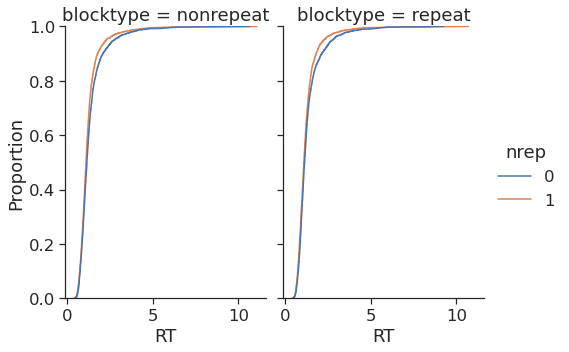

In [1375]:
# RTs after apply filter
df_rt = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)

sns.displot(
    data=df_rt, x="RT", hue="nrep", col="blocktype",
     height=5, aspect=.7,  kind="ecdf"
)

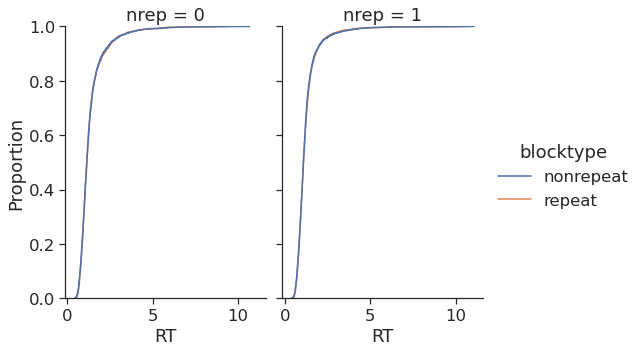

In [1376]:
sns.displot(
    data=df_rt, x="RT", col="nrep", hue="blocktype",
     height=5, aspect=.7, kind="ecdf"
)

IndexError: index 42 is out of bounds for axis 0 with size 42

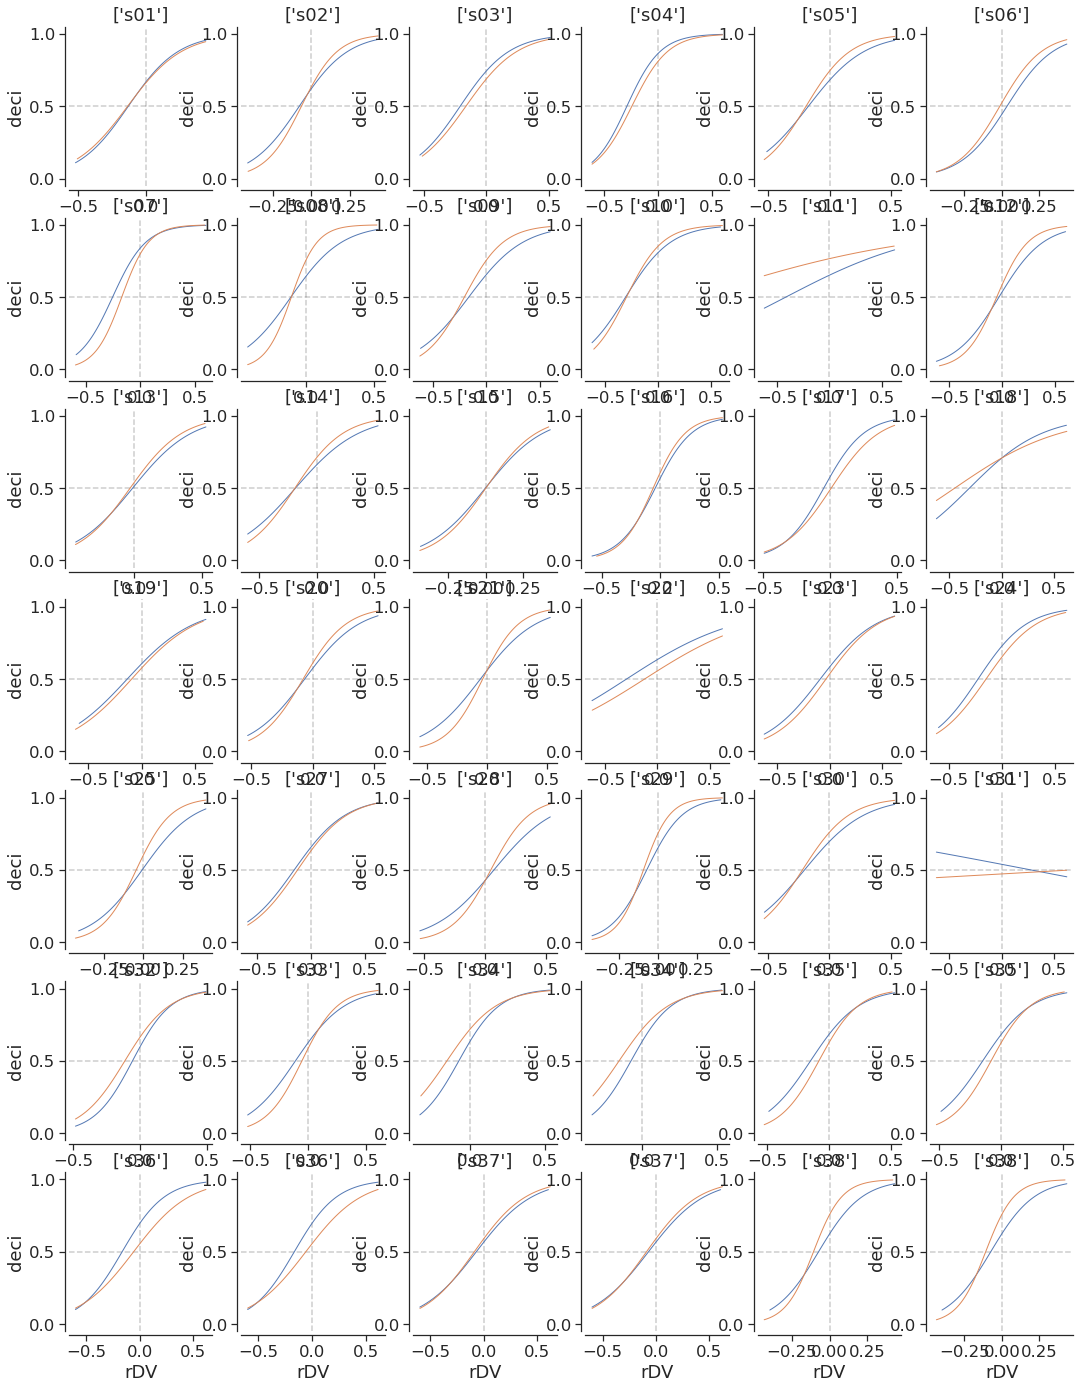

In [1377]:
nprows = 7 
npcols = 6

nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(18, 24))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i in npar_labels: #for loop to compute the average by each participant
    df2 = df.loc[df.npar == i,:]
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(np.unique(df2.subj))
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    for cell in nrep_labels:
            #sns.set_palette(mycol)
            sns.regplot(ax=axes[p[i-1,0],p[i-1,1]],x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.95, 'lw':1}); #mean all subject
    

#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

In [ ]:
formula = "deci ~ rDV"
log_par = df.groupby(['subj', 'nrep', 'blocktype']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)
log_par.head(5)
# here it seems that visual inspection shows that p13 and p15 were pretty bad
log_par[log_par.weight < 0]

#mean_w = np.mean(log_par.weight)
#std_w  = np.std(log_par.weight)
#log_par.weight > (mean_w + 2*std_w)

### Removing bad participants

In [1378]:
df = df.loc[(df.subj != 's03') & (df.subj != 's11')& (df.subj != 's31'),:] #she was very distracted and confused the keys
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

Verifying that rDV does not changes across repetitions in the nonrepeated block

In [1379]:
dfs = df.copy()
dfs['rDV'] = np.abs(dfs['rDV'])
df_avgs = dfs.groupby(['subj','blocktype', 'nrep'],as_index=False)[['rDV', 'confi']].mean()
#Checking statistical differences in metadeprime between the number of repetitions & blocktype
pg.rm_anova(dv = 'rDV', within = ['nrep'], subject = 'subj', 
            data=df_avgs[df_avgs.blocktype == 'nonrepeat'], detailed = True, correction = True)

Source        SS  DF        MS         F     p-unc       np2  eps
0   nrep  0.000003   1  0.000003  2.452686  0.126585  0.067284  1.0
1  Error  0.000047  34  0.000001       NaN       NaN       NaN  NaN

But confidence might change...

In [1256]:
pg.rm_anova(dv = 'confi', within = ['nrep', 'blocktype'], subject = 'subj', 
            data=df_avgs, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F  \
0              nrep  0.453643      1     34  0.453643  35.601642   
1         blocktype  0.000267      1     34  0.000267   0.033840   
2  nrep * blocktype  0.004768      1     34  0.004768   3.657398   

          p-unc     p-GG-corr       np2  eps  
0  9.512957e-07  9.512957e-07  0.511506  1.0  
1  8.551402e-01  8.551402e-01  0.000994  1.0  
2  6.427562e-02  6.427562e-02  0.097123  1.0

### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [1257]:
# df to long format
dflong = pd.melt(df, id_vars=['subj','blocktype','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','confi','conf_lvl','conf_lvl-1','RT'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['subj','blocktype','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','confi','conf_lvl','conf_lvl-1','RT'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
dflong.orient = np.rad2deg(dflong.orient) # transform to degrees
del out

dflong = dflong.sort_values(['nblock','subj','ntrial','nrep',],ascending=[True,True,True,True]) # reorder variables
dflong.reset_index(drop=True, inplace=True)
dflong.insert(5, "stim_cond", "D")
dflong.loc[(dflong.dv < 0), "stim_cond"]  = "C"


dflong.insert(7, 'cong_deci', "I") # if stim is congruent with previous repetition decosion category
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['deci-1'] == 1) & (dflong.stim_cond == 'D'), "cong_deci"]  = "C"



dflong.insert(8, 'cong_stim', 'I') # if stim is congruent with previous repetition mean category
dflong.loc[(dflong['cond-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['cond-1'] == 'D') & (dflong.stim_cond == 'D'), 'cong_stim'] = 'C'

# relabeling variables
#dflong["cond-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-2"].replace({0: "C", 1: "D"}, inplace=True)


dflong['ov'] = signal.sawtooth(2*np.deg2rad(dflong.orient), 0.5) # orientation variable (here I define an ov to make stimuli that differ by less of 45 degrees or more than 135 as similar)
# plt.scatter(dflong.orient,dflong['ov']) # see here


dflong.head(5)

subj  blocktype nblock  ntrial  nrep stim_cond cond-1 cong_deci cong_stim  \
0  s01  nonrepeat      0       0     0         D      0         I         I   
1  s01  nonrepeat      0       0     0         C      0         C         C   
2  s01  nonrepeat      0       0     0         D      0         I         I   
3  s01  nonrepeat      0       0     0         C      0         C         C   
4  s01  nonrepeat      0       0     0         D      0         I         I   

   cond  deci-2  deci-1  deci  corr-1  correct  confi conf_lvl conf_lvl-1  \
0     1       0       0     1       0        1    0.1        L          L   
1     1       0       0     1       0        1    0.1        L          L   
2     1       0       0     1       0        1    0.1        L          L   
3     1       0       0     1       0        1    0.1        L          L   
4     1       0       0     1       0        1    0.1        L          L   

         RT stim        dv      orient        ov  
0  2.044453   d1  0.828372   41.138370 -0.085814  
1  2.044453   d2 -0.956710    0.974028 -0.978355  
2  2.044453   d3  0.360338  120.607616  0.319831  
3  2.044453   d4 -0.087842  110.523559  0.543921  
4  2.044453   d5  0.939380  136.363955 -0.030310

In [1258]:
# Adding decision variable difference & congruency between stim
out = np.diff(dflong.dv, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiffDV = out

stim_dec = dflong.dv.copy()
stim_dec = stim_dec.to_numpy()
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0
diffDV = np.absolute(np.diff(stim_dec, prepend = 0)) #  change = 1, repeated = 0

# Adding physical orientation variable difference & congruency between stim

out = np.diff(dflong.ov, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiff_stim_ori = out

stim_ori = dflong.ov.copy()
stim_ori = stim_ori.to_numpy()
# Simplify the labels
stim_ori[stim_ori > 0] = 1
stim_ori[stim_ori < 0] = 0
diffstim_ori= np.absolute(np.diff(stim_ori, prepend = 0))


# Merging all the datasets
dflong_seq = pd.concat([dflong, pd.Series(absdiffDV, dtype=np.int32, name='abs_diffDV'), pd.Series(diffDV, dtype=np.int32, name='cong_stim_DV'),pd.Series(stim_ori, dtype=np.int32, name='stim_cat_OV'),pd.Series(stim_ori, dtype=np.int32, name='abs_diffOV'), pd.Series(diffstim_ori, dtype=np.int32, name='cong_stim_OV')], axis=1).copy()

dflong_seq = dflong_seq.loc[dflong_seq['stim'] != "d1"] # now I remove d1 as it is not informative and it would add noise to this analysis
dflong_seq.head(2)

subj  blocktype nblock  ntrial  nrep stim_cond cond-1 cong_deci cong_stim  \
1  s01  nonrepeat      0       0     0         C      0         C         C   
2  s01  nonrepeat      0       0     0         D      0         I         I   

   cond  deci-2  deci-1  deci  corr-1  correct  confi conf_lvl conf_lvl-1  \
1     1       0       0     1       0        1    0.1        L          L   
2     1       0       0     1       0        1    0.1        L          L   

         RT stim        dv      orient        ov  abs_diffDV  cong_stim_DV  \
1  2.044453   d2 -0.956710    0.974028 -0.978355    1.785082             1   
2  2.044453   d3  0.360338  120.607616  0.319831    1.317048             1   

   stim_cat_OV  abs_diffOV  cong_stim_OV  
1            0           0             0  
2            1           1             1

Confidence analyses

__Calculating mean DV and confi per condition__ 

Checking wether participants performed better in repeated or nonrepeated trials

In [1259]:
df.head(5)

index npar subj nblock  ntrial  nrep cond-1  blocktype       rDV  \
0      0    1  s01      0       0     0      0  nonrepeat  0.089044   
1      1    1  s01      0       0     1      1  nonrepeat  0.068067   
2      2    1  s01      0       1     0      1  nonrepeat -0.027166   
3      3    1  s01      0       1     1      0  nonrepeat  0.001867   
4      4    1  s01      0       2     0      0  nonrepeat -0.086152   

   trial_type  cond  deci-2  deci-1  deci  corr-1    DV  resp  r_map  correct  \
0       False     1       0       0     1       0  0.08   1.0     45        1   
1       False     1       0       1     1       1  0.08   1.0      0        1   
2       False     0       0       1     1       1 -0.01   1.0     45        0   
3       False     0       0       1     0       0 -0.01  -1.0     45        1   
4       False     0       0       0     0       1 -0.11  -1.0     45        1   

   confi conf_lvl conf_lvl-1        RT        d1        d2        d3  \
0   0.10        L          L  2.044453  0.828372 -0.956710  0.360338   
1   0.35        H          L  2.114065 -0.186164 -0.022671  0.287481   
2   0.75        H          H  1.752747  0.840586 -0.430107  0.129599   
3  -0.15        L          H  1.981836 -0.668958  0.911887  0.596642   
4   0.40        H          L  2.481966 -0.637881  0.462198 -0.473916   

         d4        d5        d6     o1     o2     o3     o4     o5     o6  \
0 -0.087842  0.939380 -0.549273  0.718  0.017  2.105  1.929  2.380  0.177   
1  0.530953  0.415324 -0.616519  2.822  1.187  2.636  2.172  1.015  2.991   
2  0.858411 -0.717341 -0.844146  0.848  1.347  2.698  0.841  0.111  1.632   
3  0.846197 -0.812598 -0.861971  0.130  0.820  0.627  0.725  3.068  1.625   
4  0.087865 -0.446895  0.491718  1.713  2.145  2.935  1.998  1.788  0.985   

   confi-1  
0     0.00  
1     0.10  
2     0.35  
3     0.75  
4    -0.15

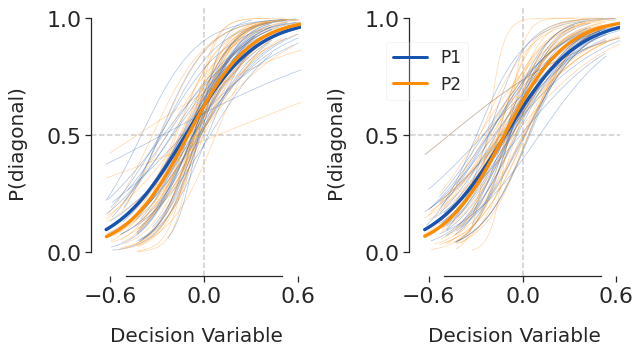

In [1260]:
mycol = ["#1654B0", "darkorange"]
sns.set_palette(mycol)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar
blocktype_labels = np.unique(df.blocktype) 
 

for j in [0,1]: #for loop to compute the average by each participant
    axes[j].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[j].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    
    for i in npar_labels: #for loop to compute the average by each participant
        df2=df.loc[(df.npar == i) & (df.blocktype == blocktype_labels[j]) ,:]
        for cell in nrep_labels:
            sns.set_palette(mycol)
            sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1, ax = axes[j], label=cell,  truncate=True, 
                             line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

    for cell in nrep_labels: #for loop to compute the plot by the average sample
        sns.set_palette(mycol)
        sns.regplot(x="rDV", y="deci",  data=df.loc[(df.nrep == cell) & (df.blocktype == blocktype_labels[j]),:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,   ax = axes[j], label=cell,  truncate=True, 
                         line_kws ={'lw':3.4});
    #sns.despine(offset=1, trim=True, ax = axes[j]);
    sns.despine(ax= axes[j], offset=0.5, trim = True);
    
    axes[j].set_ylabel('P(diagonal)', fontsize = 20, labelpad=20); #axes[j].set_yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
    axes[j].set_xlabel('Decision Variable', fontdict={'size':20}, labelpad=20); 
    
    #xticks = [-0.6,-0.3,0,0.3,0.6] #np.round(np.arange(-0.9, 0.6, step=0.3),decimals = 2)
    #yticks = np.arange(-0., 1.1, step=0.25)
    
    axes[j].set_xlim(-0.72,0.62)
    axes[j].set_xticks([-0.6,0,0.6]) 
    
    axes[j].tick_params(axis='x', labelsize=22)   
    axes[j].set_yticks([0.0,0.5,1]) 
    axes[j].set_ylim(-0.1,1.05)
    axes[j].tick_params(axis='y', labelsize=22) 
   
  
    lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2']; 
    plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
    fig.tight_layout()
    #plt.savefig('deci_x_nrep.png',bbox_inches='tight')


Logisitc regression model with number of presentation

In [1261]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['subj', 'nrep', 'blocktype']).apply(log_reg_fit, formula) 
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

subj  nrep  blocktype  level_3  intercept     weight       PSE
135  s38     1     repeat        0   1.928739  20.443479 -0.094345
136  s39     0  nonrepeat        0   0.480629   6.717069 -0.071553
137  s39     0     repeat        0   0.405429   4.971174 -0.081556
138  s39     1  nonrepeat        0   0.311035   9.399091 -0.033092
139  s39     1     repeat        0   0.745935   5.993549 -0.124456

<font size="4"> _Statistical tests for Weight._

In [1262]:
dat = log_reg_nrep
aov = AnovaRM(dat, 'weight', 'subj', within=['nrep', 'blocktype'])
resaov = aov.fit()
print(resaov) 

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep           12.3502 1.0000 34.0000 0.0013
blocktype       0.2253 1.0000 34.0000 0.6380
nrep:blocktype  0.5518 1.0000 34.0000 0.4627



In [1263]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within= ['nrep', 'blocktype'], subject='subj', padjust='bonf', 
                    effsize = 'cohen', data=log_reg_nrep) 

Contrast nrep          A       B Paired  Parametric         T  \
0              nrep    -          0       1   True        True -3.514282   
1         blocktype    -  nonrepeat  repeat   True        True  0.474699   
2  nrep * blocktype    0  nonrepeat  repeat   True        True  1.307387   
3  nrep * blocktype    1  nonrepeat  repeat   True        True -0.011951   

    dof alternative     p-unc    p-corr p-adjust    BF10     cohen  
0  34.0   two-sided  0.001270       NaN      NaN  25.692 -0.637396  
1  34.0   two-sided  0.638036       NaN      NaN   0.201  0.104767  
2  34.0   two-sided  0.199854  0.399707     bonf   0.396  0.266029  
3  34.0   two-sided  0.990534  1.000000     bonf   0.181 -0.002719

In [1264]:
dat = log_reg_nrep
aov = AnovaRM(dat, 'PSE', 'subj', within=['nrep', 'blocktype'])
resaov = aov.fit()
print(resaov) 

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep            0.7082 1.0000 34.0000 0.4059
blocktype       1.0240 1.0000 34.0000 0.3187
nrep:blocktype  3.4569 1.0000 34.0000 0.0717



In [1265]:
#post-hoc t-test
pg.pairwise_ttests(dv='PSE', within= ['nrep', 'blocktype'], subject='subj', padjust='bonf', 
                    effsize = 'cohen', data=log_reg_nrep) 

Contrast nrep          A       B Paired  Parametric         T  \
0              nrep    -          0       1   True        True -0.841541   
1         blocktype    -  nonrepeat  repeat   True        True  1.011931   
2  nrep * blocktype    0  nonrepeat  repeat   True        True -0.189926   
3  nrep * blocktype    1  nonrepeat  repeat   True        True  1.985373   

    dof alternative     p-unc    p-corr p-adjust   BF10     cohen  
0  34.0   two-sided  0.405925       NaN      NaN  0.252 -0.082028  
1  34.0   two-sided  0.318719       NaN      NaN  0.291  0.122508  
2  34.0   two-sided  0.850497  1.000000     bonf  0.184 -0.026914  
3  34.0   two-sided  0.055216  0.110433     bonf  1.042  0.261192

# Parameters
Plotting weights and PSE

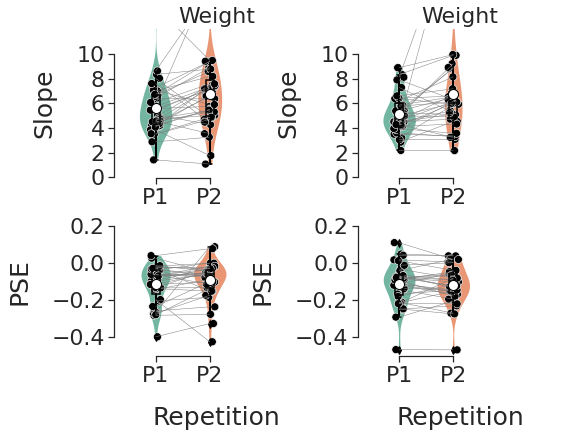

In [1266]:
sns.set(style="ticks",font_scale=2)

dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; dy = "weight"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(2,2,figsize=(8, 6))

# PLOTTING INTERCEPT

 
for j in [0,1]: #for loop to compute the average by each participant

    dat = log_reg_nrep[log_reg_nrep.blocktype == blocktype_labels[j]]
    
    sns.boxplot( x = dx, y = dy, data = dat, color = "black"
          ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort, ax = axes[0,j])

    sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[0,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0,j])

    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0,j])


    axes[0,j].set_xlim([-0.75, 3])
    axes[0,j].set_xticks([0,1])
    axes[0,j].set_xticklabels(['P1','P2'])
    axes[0,j].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 


    axes[0,j].set_ylim([0, 12])
    axes[0,j].set_yticks(np.arange(0, 12, step=2))
    axes[0,j].set_ylabel('Slope', fontsize = 25, labelpad=20);

    axes[0,j].tick_params(axis='x', labelsize=22) 
    axes[0,j].tick_params(axis='y', labelsize=22)  
    axes[0,j].set_title('Weight',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[0,j]);
    
for j in [0,1]: #for loop to compute the average by each participant

    dat = log_reg_nrep[log_reg_nrep.blocktype == blocktype_labels[j]]    
# NOW I PLOT THE INTERCEPT
    dy = "PSE"
    #dy = "intercept"

    sns.boxplot( x = dx, y = dy, data = dat, color = "black"
          ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort, ax = axes[1,j])

    sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
          edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[1,j])

    sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
         bw = 0.5, cut = 0.0,scale = "area", width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1,j])

    #ax = sns.pointplot(x= dx, y= dy, data=dat, color = 'grey', errwidth = 0, size = 10, join = False, zorder = 8)
    sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[1,j])


    axes[1,j].set_xlim([-0.75, 3])
    axes[1,j].set_xticks([0,1])
    axes[1,j].set_xticklabels(['P1','P2'])
    axes[1,j].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 

    axes[1,j].set_ylim([-0.5, 0.3])
    axes[1,j].set_yticks(np.arange(-0.4, 0.2, step=0.2))
    axes[1,j].set_ylabel('PSE', fontsize = 25, labelpad=20);

    axes[1,j].tick_params(axis='x', labelsize=22) 
    axes[1,j].tick_params(axis='y', labelsize=22)  
    #axes[1].set_title('PSE',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[1,j]);


<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

## Effect of previous decision in the current trial decision

In [1267]:
formula = "deci ~ rDV"

subjs = np.array(['s01', 's02', 's03', 's04', 's05', 's06', 's07', 's08', 's09',
       's10', 's11','s12', 's13', 's14', 's15', 's17', 's19', 's20',
       's21', 's23', 's24', 's25'])
for isub in subjs:
    df_subj = df[df.subj == isub] # s16 does not converge
    log_reg_preDeci = df_subj.groupby(['nrep', 'deci-1','blocktype']).apply(log_reg_fit, formula)
    
    

In [1268]:
formula = "deci ~ rDV"

df_all = df[(df.subj != 's16') & (df.subj != 's22') &  (df.subj != 's10')] # s16 does not converge
log_reg_preDeci = df_all.groupby(['subj', 'nrep', 'deci-1','blocktype']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
#log_reg_preDeci.head(8)

log_reg_preDeci[(log_reg_preDeci.weight < 0)] # negative weights indicate a problem

subj  nrep  deci-1 blocktype  level_4  intercept    weight       PSE
215  s34     1       1    repeat        0   2.803910 -1.126013  2.490123
221  s35     1       0    repeat        0  -2.348664 -0.365906 -6.418757
229  s36     1       0    repeat        0  -2.612908 -1.984893 -1.316397
239  s37     1       1    repeat        0   2.439683 -0.391618  6.229748

In [1269]:
np.unique(df_subj.subj)

array(['s25'], dtype=object)

/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/freeman/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


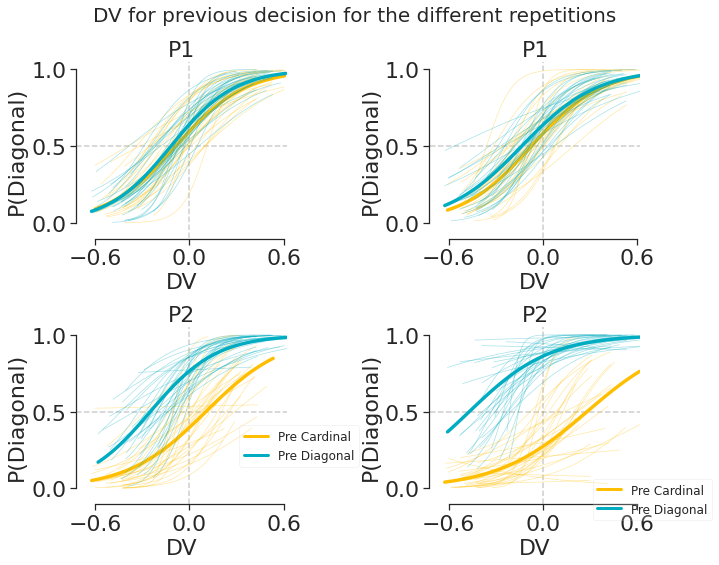

In [1270]:
sns.set(font_scale = 1, style = 'ticks') 
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal
sns.set_palette(mycol)

titles = ['P1', 'P2']
pre_deci_labels = np.unique(df['deci-1'])     #pre_deci
nreps = np.unique(df['nrep'])     #nreps


df_subj = df[(df.subj != 's16') & (df.subj != 's10') & (df.subj != 's22') ] # s16 does not converge amd the others have negative weights
#df_subj = df[df.subj != 's22'] # s16 does not converge
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("DV for previous decision for the different repetitions", fontsize=20)

blocktype_labels = np.unique(df.blocktype) 
 

for z in [0, 1]: #for loop to compute the average by each participant
    
    for j in nreps:
        axes[j,z].axvline(0, ls='--', color= 'black', alpha = 0.2)
        axes[j,z].axhline(0.5, ls='--', color= 'black', alpha = 0.2)
        for cell in pre_deci_labels:
            for i in npar_labels: #this for loop makes the plot for each participant 
                dati = df_subj[(df_subj.npar == i) & (df_subj['deci-1'] == cell) & (df_subj.nrep == j) & (df_subj.blocktype == blocktype_labels[z])].copy()#df.loc[(df.npar == i) & (df['deci-1'] == cell) & (df.nrep == j),:]
                sns.regplot(x="rDV", y="deci",  data= dati,
                   logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                                  label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}, ax = axes[j,z], color = mycol[cell]);
            
            dat = df_subj[(df_subj['deci-1'] == cell) & (df_subj.nrep == j) & (df_subj.blocktype == blocktype_labels[z])].copy()
            sns.regplot(x="rDV", y="deci",  data= dat,
                   logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                              label=cell, truncate=True, line_kws={'lw':3.4}, ax = axes[j,z], color = mycol[cell]);

        # Tweaking subplots
        axes[j,z].set_title(titles[j],fontsize = 22)

        axes[j,z].set_xlabel('DV', fontsize = 22)
        axes[j,z].set_ylabel('P(Diagonal)', fontsize = 22)

        axes[j,z].set_xlim(-0.72,0.62)
        axes[j,z].set_xticks([-0.6,0,0.6]) 

        axes[j,z].tick_params(axis='x', labelsize=22)   
        axes[j,z].set_yticks([0.0,0.5,1]) 
        axes[j,z].set_ylim(-0.1,1.05)
        axes[j,z].tick_params(axis='y', labelsize=22) 
        #axes[j].xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
        sns.despine(ax= axes[j,z], offset=0.5, trim = True);

    labels = ['Pre Cardinal', 'Pre Diagonal']; 
    lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
    axes[1,z].legend(lines, labels, bbox_to_anchor=(0.745,0.175), fontsize=12, framealpha= 0.2)

    #plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
    #         horizontalalignment="left")       
            #fig[j].title('P1', fontsize= 35); 
    
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()
#axes[0].ylabel('p(diagonal)', fontsize = 20, labelpad=20); axes[0].yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); plt.xlabel(' ', fontsize = 0)


<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [1271]:
np.unique(df.subj)

array(['s01', 's02', 's04', 's05', 's06', 's07', 's08', 's09', 's10',
       's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20',
       's21', 's22', 's23', 's24', 's25', 's27', 's28', 's29', 's30',
       's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39'],
      dtype=object)

In [1272]:
formula = "deci ~ rDV"
#df_subj = df[df.subj != 's11'] # s16 does not converge
#df_subj = df[(df.subj != 's16') & (df.subj != 's22')] # s16 does not converge
#df_subj = df[df.subj != 's22'] # s16 does not converge
#df_subj = df[df.subj != 's18'] # s16 does not converge
log_reg_preDeci = df_subj.groupby(['subj', 'nrep', 'deci-1','blocktype']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(8)

subj  nrep  deci-1  blocktype  level_4  intercept     weight       PSE
0  s01     0       0  nonrepeat        0   1.384749   5.941368 -0.233069
1  s01     0       0     repeat        0   0.418740   4.445863 -0.094186
2  s01     0       1  nonrepeat        0   0.393566   5.215287 -0.075464
3  s01     0       1     repeat        0   0.872689   6.843830 -0.127515
4  s01     1       0  nonrepeat        0   0.817197   7.341192 -0.111317
5  s01     1       0     repeat        0  -0.717912   2.169722  0.330878
6  s01     1       1  nonrepeat        0   0.438794   3.174098 -0.138242
7  s01     1       1     repeat        0   3.665103  12.437501 -0.294682

In [1273]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0           nrep  0.024681      1     31  0.024681  0.003156  0.955558   
1         deci-1  5.065996      1     31  5.065996  1.264006  0.269525   
2  nrep * deci-1  4.278977      1     31  4.278977  1.115041  0.299149   

   p-GG-corr       np2  eps  
0   0.955558  0.000102  1.0  
1   0.269525  0.039177  1.0  
2   0.299149  0.034720  1.0

In [1274]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'PSE', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS         F     p-unc  \
0           nrep  0.000069      1     31  0.000069  0.000220  0.988264   
1         deci-1  1.892979      1     31  1.892979  7.065061  0.012318   
2  nrep * deci-1  1.534669      1     31  1.534669  6.341068  0.017175   

   p-GG-corr       np2  eps  
0   0.988264  0.000007  1.0  
1   0.012318  0.185605  1.0  
2   0.017175  0.169815  1.0

In [1275]:
dat = log_reg_preDeci
pg.pairwise_ttests(dv='PSE', within= ['nrep','deci-1'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

Contrast nrep  A  B Paired  Parametric         T   dof alternative  \
0           nrep    -  0  1   True        True  0.014828  31.0   two-sided   
1         deci-1    -  0  1   True        True  2.658018  31.0   two-sided   
2  nrep * deci-1    0  0  1   True        True  1.324580  31.0   two-sided   
3  nrep * deci-1    1  0  1   True        True  2.602718  31.0   two-sided   

      p-unc   BF10     cohen  
0  0.988264  0.189  0.003595  
1  0.012318  3.694  0.617975  
2  0.194993  0.418  0.236392  
3  0.014062  3.305  0.608821

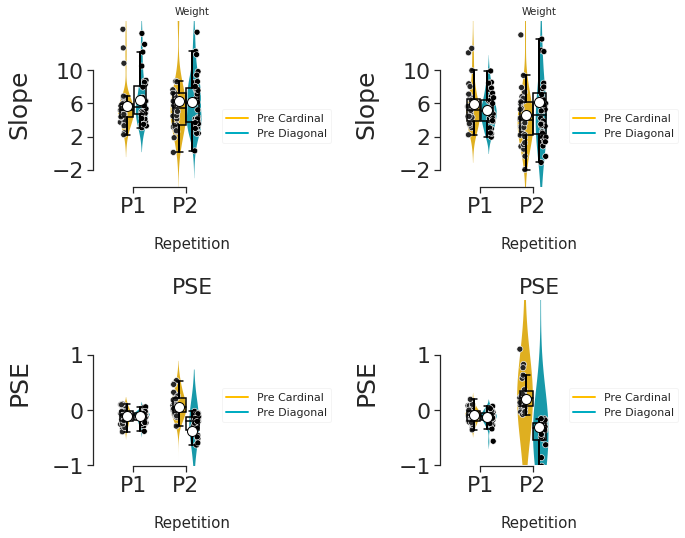

In [1276]:
sns.set(style="ticks",font_scale=2)
mycol = ['#ffbf00' , '#00acc1'] 
dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(2,2,figsize=(10, 8))


for j in [0,1]: #for loop to compute the average by each participant
    
    dy = "weight"
    
    dat = log_reg_preDeci[log_reg_preDeci.blocktype == blocktype_labels[j]]
    
    ax0 = sns.boxplot( x = dx, y = dy, data = dat, hue = "deci-1", color = 'black'
          ,width = .5, zorder = 2, showcaps = True,  showmeans=True, meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=False,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.7, orient = ort, ax = axes[0,j])      
    
    ax = sns.stripplot(x = dx, y = dy, data = dat,  hue = "deci-1", color = "black",  dodge=True,
         edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[0,j])   
    
    ax1 = sns.violinplot( x = dx, y = dy, data = dat ,  hue = "deci-1", palette = mycol, 
                
         bw = 0.5, cut = 2, width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0,j])
    

    lines = [Line2D([0], [0], color=c, linewidth=2) for c in mycol]; 
    ax1.legend(lines, labels, bbox_to_anchor=(0.62,0.5), fontsize=11, framealpha= 0.2)
    f.tight_layout()

    
    axes[0,j].set_xlim([-0.75, 3])
    axes[0,j].set_xticks([0,1])
    axes[0,j].set_xticklabels(['P1','P2'])
    axes[0,j].set_xlabel('Repetition', fontdict={'size':15}, labelpad=20); 


    axes[0,j].set_ylim([-4, 16])
    axes[0,j].set_yticks(np.arange(-2, 14, step=4))
    axes[0,j].set_ylabel('Slope', fontsize = 25, labelpad=20);

    axes[0,j].tick_params(axis='x', labelsize=22) 
    axes[0,j].tick_params(axis='y', labelsize=22)  
    axes[0,j].set_title('Weight',fontsize = 10)
    sns.despine(offset = 1,  trim=True, ax = axes[0,j]);


for j in [0,1]: #for loop to compute the average by each participant
    
    dy = "PSE"
    
    dat = log_reg_preDeci[log_reg_preDeci.blocktype == blocktype_labels[j]]
    
    ax0 = sns.boxplot( x = dx, y = dy, data = dat, hue = "deci-1", color = 'black'
          ,width = .5, zorder = 2, showcaps = True,  showmeans=True, meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=False,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.7, orient = ort, ax = axes[1,j])
    
    
    ax = sns.stripplot(x = dx, y = dy, data = dat,  hue = "deci-1", color = "black",  dodge=True,
         edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, zorder = 2,
          orient = ort, ax = axes[1,j])   
    
    ax1 = sns.violinplot( x = dx, y = dy, data = dat ,  hue = "deci-1", palette = mycol, 
                
         bw = 0.5, cut = 2, width = .6, 
         inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1,j])
    
    
    lines = [Line2D([0], [0], color=c, linewidth=2) for c in mycol]; 
    ax1.legend(lines, labels, bbox_to_anchor=(0.62,0.5), fontsize=11, framealpha= 0.2)
    f.tight_layout()
   
    axes[1,j].set_xlim([-0.75, 3])
    axes[1,j].set_xticks([0,1])
    axes[1,j].set_xticklabels(['P1','P2'])
    axes[1,j].set_xlabel('Repetition', fontdict={'size':15}, labelpad=20); 


    axes[1,j].set_ylim([-1, 2])
    axes[1,j].set_yticks(np.arange(-1, 2, step=1))
    axes[1,j].set_ylabel('PSE', fontsize = 25, labelpad=20);

    axes[1,j].tick_params(axis='x', labelsize=22) 
    axes[1,j].tick_params(axis='y', labelsize=22)  
    axes[1,j].set_title('PSE',fontsize = 22)
    sns.despine(offset = 1,  trim=True, ax = axes[1,j]);

Calculating the difference between deci-1 to simplify the plotting

## Analyses in not long format dataframe

In [1277]:
df.columns

Index(['index', 'npar', 'subj', 'nblock', 'ntrial', 'nrep', 'cond-1',
       'blocktype', 'rDV', 'trial_type', 'cond', 'deci-2', 'deci-1', 'deci',
       'corr-1', 'DV', 'resp', 'r_map', 'correct', 'confi', 'conf_lvl',
       'conf_lvl-1', 'RT', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'o1', 'o2',
       'o3', 'o4', 'o5', 'o6', 'confi-1'],
      dtype='object')

In [1278]:
def log_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]], 'G6ori':[params[6]]})
    return out #intercept + weight

In [1279]:
formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df.groupby(['subj','nrep']).apply(log_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

In [1280]:
df_betas = pd.melt(df_mr_betas, id_vars=['subj','nrep'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori','G6ori'])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
df_betas.head(4)

subj  nrep  parameter     value
0  s01     0  intercept  0.753840
1  s01     1  intercept  0.681162
2  s02     0  intercept  0.408814
3  s02     1  intercept  0.529819

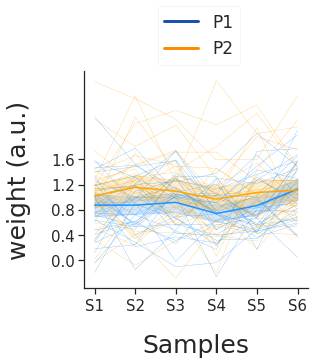

In [1281]:
plt.subplots(ncols = 1, figsize = (4,4))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.subj)#npar

mycol = ["#1654B0", "darkorange"]
df_betas_plot = df_betas[df_betas.parameter != 'intercept']
for i in n_par_labels:
    dat= df_betas_plot[df_betas_plot.subj ==i]
    sns.lineplot(x="parameter", y="value", hue="nrep", 
                 palette= ["dodgerblue", "orange"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="parameter", y="value", hue="nrep",
             palette= ["dodgerblue", "orange"], data= df_betas_plot)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.65, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
#plt.savefig('sample_intercept4part.png',bbox_inches='tight')


<font size="4"> Statistical tests 

In [1282]:
dat = df_betas[df_betas.parameter != 'intercept']
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
pg.rm_anova(dv = 'value', within = ['nrep', 'parameter'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F     p-unc  \
0              nrep  3.079649      1     34  3.079649  11.572620  0.001728   
1         parameter  2.695923      5    170  0.539185   2.014236  0.079011   
2  nrep * parameter  0.929223      5    170  0.185845   2.014859  0.078923   

   p-GG-corr       np2       eps  
0   0.001728  0.253938  1.000000  
1   0.097429  0.055929  0.783851  
2   0.087984  0.055945  0.887591

In [1283]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
dat = df_betas[df_betas.parameter == 'intercept']

pg.pairwise_ttests(dv='value', within= ['nrep'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

Contrast  A  B  Paired  Parametric         T   dof alternative     p-unc  \
0     nrep  0  1    True        True -1.313583  34.0   two-sided  0.197782   

    BF10     cohen  
0  0.399 -0.143707

<font size="3">  __Category similarity between consecutive samples__

In [1284]:
# This function calculates the minimum difference in circular space between two angles
def circ_angles_diff(x,ref):
    x = np.rad2deg(x)
    ref = np.rad2deg(ref)
    diffs = x - ref
    diffs = (diffs + 180) % 360 - 180
    return diffs
#circ_angles_diff(np.array([5, 20, 30]),200)    

In [1285]:
def log_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]]})
    return out #intercept + weight

In [1286]:
# function that I used to plot multiple data
def mylinesplot(data, dx, dy, hue, col, row, pal, size, yaxis, axislabels, sizepoint):    
    sns.set(font_scale = 1.5, style = 'ticks')         
    ort = "v"; pal = pal; sigma = .5
    g = sns.FacetGrid(data ,  row = row, col = col, height= size['height'], aspect=size['aspect'], margin_titles=True) # col="nrep",    
    if sizepoint == None:
        sizepoint = 6
    if yaxis != None:
        g.set(yaxis['ylim'], yaxis['yticks'])   

    #g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
    g.map_dataframe(sns.lineplot, x=dx, y=dy, hue=hue, palette = pal)

    g.map_dataframe(sns.stripplot, x = dx, y = dy, palette = pal, hue=hue, size = sizepoint, edgecolor = "white",linewidth = 0.6, jitter = 1, orient = ort)
    g.add_legend()

    #g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
    sns.despine(offset = .5,  trim=True);
    # Set x-axis and y-axis labels
    g.set_axis_labels( axislabels['xlabel'] , axislabels['ylabel'], fontsize = 15 )
    #g.tight_layout()


In [1287]:
# function that I used to plot multiple data
def myviolinplot(data, dx, dy, col, row, pal, size, yaxis, axislabels, sizepoint):    
    sns.set(font_scale = 1.5, style = 'ticks')         
    ort = "v"; pal = pal; sigma = .5
    g = sns.FacetGrid(data ,  row = row, col = col, height= size['height'], aspect=size['aspect'], margin_titles=True) # col="nrep",    
    if sizepoint == None:
        sizepoint = 6
    if yaxis != None:
        g.set(yaxis['ylim'], yaxis['yticks'])   

    g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
    g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = sizepoint, linewidth = 0.6, jitter = 1, orient = ort)
    g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort)
    g.add_legend()

    #g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "NIUB" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
    sns.despine(offset = .5,  trim=True);
    # Set x-axis and y-axis labels
    g.set_axis_labels( axislabels['xlabel'] , axislabels['ylabel'], fontsize = 15 )
    #g.tight_layout()


In [1288]:
diff1 = circ_angles_diff(df.iloc[:,30],df.iloc[:,29])
diff2 = circ_angles_diff(df.iloc[:,31],df.iloc[:,30])
diff3 = circ_angles_diff(df.iloc[:,32],df.iloc[:,31])
diff4 = circ_angles_diff(df.iloc[:,33],df.iloc[:,32])
diff5 = circ_angles_diff(df.iloc[:,34],df.iloc[:,33])

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()

In [1289]:
sort_idx = prev_respdiff.argsort(axis = 1)

In [1290]:
orientations = np.matrix(df.iloc[:, 24:29])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)

In [1291]:
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

In [1292]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df_glm.groupby(['subj']).apply(log_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori',])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

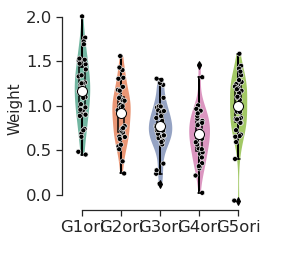

In [1293]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; col = None; row = None
pal = "Set2"
# & (~df_betas.NIUB.isin(out_subjs))
myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [1294]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter'])
resaov = aov.fit()
print(resaov) 

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
parameter 20.6178 4.0000 136.0000 0.0000



In [1295]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
dat = df_betas[df_betas.parameter != 'intercept']

pg.pairwise_ttests(dv='value', within= ['parameter'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

Contrast      A      B  Paired  Parametric         T   dof alternative  \
0  parameter  G1ori  G2ori    True        True  3.574280  34.0   two-sided   
1  parameter  G1ori  G3ori    True        True  6.482968  34.0   two-sided   
2  parameter  G1ori  G4ori    True        True  7.585073  34.0   two-sided   
3  parameter  G1ori  G5ori    True        True  2.976835  34.0   two-sided   
4  parameter  G2ori  G3ori    True        True  2.528206  34.0   two-sided   
5  parameter  G2ori  G4ori    True        True  3.969253  34.0   two-sided   
6  parameter  G2ori  G5ori    True        True -1.145134  34.0   two-sided   
7  parameter  G3ori  G4ori    True        True  2.115523  34.0   two-sided   
8  parameter  G3ori  G5ori    True        True -3.616407  34.0   two-sided   
9  parameter  G4ori  G5ori    True        True -6.616203  34.0   two-sided   

          p-unc       BF10     cohen  
0  1.076071e-03     29.752  0.752311  
1  2.046159e-07  7.613e+04  1.204114  
2  8.227329e-09  1.556e+06  1.480201  
3  5.335148e-03      7.323  0.514155  
4  1.627589e-02      2.832  0.476034  
5  3.536259e-04     80.283  0.795562  
6  2.601505e-01      0.331 -0.233574  
7  4.178988e-02      1.302  0.343676  
8  9.573319e-04     33.002 -0.697319  
9  1.379819e-07  1.101e+05 -0.999397

In [1296]:
diff1 = df.iloc[:,24] - df.iloc[:,23]
diff2 = df.iloc[:,25] - df.iloc[:,24]
diff3 = df.iloc[:,26] - df.iloc[:,25]
diff4 = df.iloc[:,27] - df.iloc[:,26]
diff5 = df.iloc[:,28] - df.iloc[:,27]

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()
#plt.hist(prev_respdiff)

In [1297]:
sort_idx = prev_respdiff.argsort(axis = 1)

In [1298]:
orientations = np.matrix(df.iloc[:, 24:29])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)

In [1299]:
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

In [1300]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df_glm.groupby(['subj']).apply(log_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori',])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

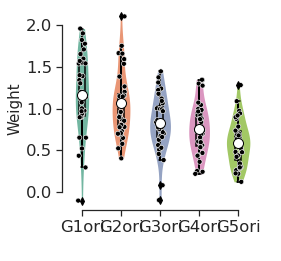

In [1301]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; col = None; row = None
pal = "Set2"
# & (~df_betas.NIUB.isin(out_subjs))
myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [1302]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter'])
resaov = aov.fit()
print(resaov) 

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
parameter 18.8247 4.0000 136.0000 0.0000



In [1303]:
def log6_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]], 'G6ori':[params[6]]})
    return out #intercept + weight

In [1304]:
prev_deci =  df['deci-1'] #.astype( 'int64')
prev_deci[prev_deci == 0] = -1

In [1305]:
diff1 = df.iloc[:,23] -  prev_deci
diff2 = df.iloc[:,24] -  prev_deci
diff3 = df.iloc[:,25] -  prev_deci
diff4 = df.iloc[:,26] -  prev_deci
diff5 = df.iloc[:,27] -  prev_deci
diff6 = df.iloc[:,28] -  prev_deci

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5,diff6], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()
#plt.hist(prev_respdiff)
sort_idx = prev_respdiff.argsort(axis = 1)
prev_respdiff = np.take_along_axis(prev_respdiff,sort_idx, axis = 1)

In [1306]:
orientations = np.matrix(df.iloc[:, 23:29])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim','G6sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

__Calculating if the decision information is correctly binned in each regressor__

In [1307]:
df_dv = pd.melt(df_glm, id_vars=['subj', 'nrep','deci-1'], value_vars=['G1sim','G2sim','G3sim','G4sim','G5sim','G6sim'])
df_dv.rename(columns={'variable' : "parameter"}, inplace=True)

In [1308]:

df_avgs = df_dv.groupby(['subj','parameter','deci-1', 'nrep'],as_index=False)[['value']].mean()
#Checking statistical differences in metadeprime between the number of repetitions & blocktype
#pg.rm_anova(dv = 'rDV', within = ['nrep'], subject = 'subj', 
#            data=df_avgs[df_avgs.blocktype == 'nonrepeat'], detailed = True, correction = True)

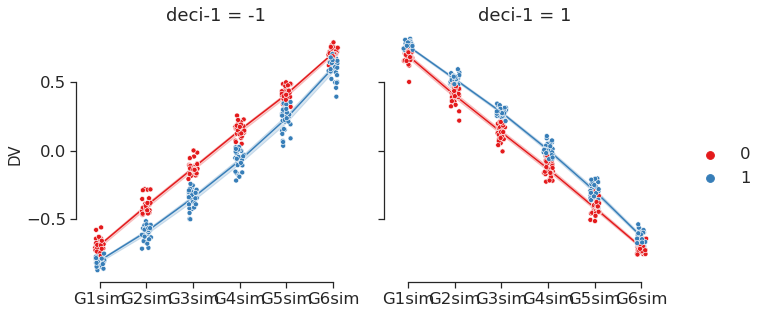

In [1309]:
sizeplot = {}; sizeplot['height'] = 5; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'DV'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; hue = 'nrep'; col = 'deci-1'; row = None
pal = "Set1"
# & (~df_betas.NIUB.isin(out_subjs))
mylinesplot(df_avgs , dx, dy, hue, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

The average difference probably stems because participants are generally correct in the first presentation. That makes that on average, the information in the second presentation is more congruent with the first decision in the same pair than with the decision in the previous pair.

Fitting the contribution of each regressor to the final decision

In [1310]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df_glm.groupby(['subj','nrep']).apply(log6_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj', 'nrep'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori','G6ori'])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

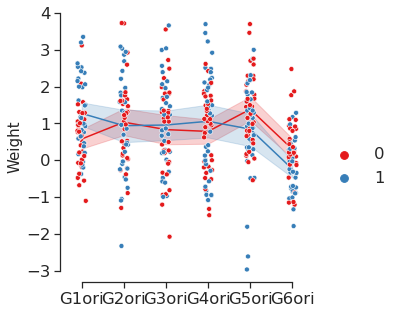

In [1311]:
sizeplot = {}; sizeplot['height'] = 5; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; hue = 'nrep'; col = None; row = None
pal = "Set1"
# & (~df_betas.NIUB.isin(out_subjs))
mylinesplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, hue, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [1312]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 

aov = AnovaRM(dat, 'value', 'subj', within=['parameter','nrep'])
resaov = aov.fit()
print(resaov) 

                    Anova
               F Value Num DF  Den DF  Pr > F
---------------------------------------------
parameter       8.3600 5.0000 170.0000 0.0000
nrep            0.0601 1.0000  34.0000 0.8078
parameter:nrep  2.7405 5.0000 170.0000 0.0208



In [1313]:
subjs = np.unique(df_glm.subj)
select_mask = np.array(['s22']) #prevcat
mask = np.isin(subjs, select_mask, invert=True)
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim'
for idx, isub in enumerate(subjs[mask]): #isub in subjs:z
    df_subj =df_glm[df_glm.subj == isub] # s16 does not converge
    df_subj.groupby(['subj','nrep','blocktype']).apply(log6_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses

    #ldf_mr_betas['NIUB'] = isub
    #if idx == 0:
    #    df_mr_betas = pd.DataFrame(columns=ldf_mr_betas.columns)
        
    #df_mr_betas = pd.concat([df_mr_betas, ldf_mr_betas])
    

In [1314]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
df_glm = df_glm[df_glm.subj != 's22']
df_mr_betas = df_glm.groupby(['subj','nrep','blocktype']).apply(log6_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj', 'nrep','blocktype'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori','G6ori'])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

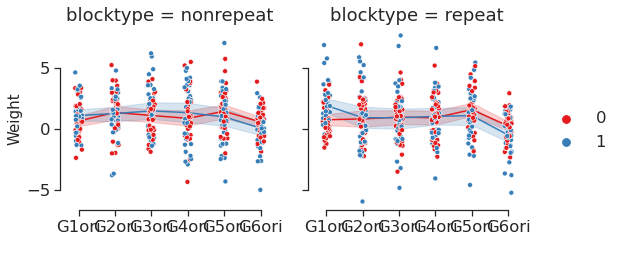

In [1315]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; hue = 'nrep';  col = 'blocktype'; row = None
pal = "Set1"
# & (~df_betas.NIUB.isin(out_subjs))
mylinesplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, hue, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)
#myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [1316]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','nrep','blocktype'])
resaov = aov.fit()
print(resaov) 

                         Anova
                         F Value Num DF  Den DF  Pr > F
-------------------------------------------------------
parameter                 7.9852 5.0000 165.0000 0.0000
nrep                      0.1744 1.0000  33.0000 0.6789
blocktype                 3.6001 1.0000  33.0000 0.0666
parameter:nrep            2.4762 5.0000 165.0000 0.0342
parameter:blocktype       0.8154 5.0000 165.0000 0.5403
nrep:blocktype            0.0534 1.0000  33.0000 0.8187
parameter:nrep:blocktype  0.5039 5.0000 165.0000 0.7730



In [1318]:
dat = df_betas[ (df_betas.parameter != 'intercept') & (df_betas.blocktype == 'nonrepeat')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','nrep'])
resaov = aov.fit()
print(resaov) 

                    Anova
               F Value Num DF  Den DF  Pr > F
---------------------------------------------
parameter       2.8927 5.0000 165.0000 0.0157
nrep            0.2076 1.0000  33.0000 0.6517
parameter:nrep  0.9345 5.0000 165.0000 0.4602



In [ ]:
ENTER IN SIMULATIONS


SyntaxError: invalid syntax (1153594875.py, line 2)

In [966]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
dat = df_betas[(df_betas.parameter != 'intercept') & (df_betas.nrep == 1)& (df_betas.blocktype == 'nonrepeat')]

pg.pairwise_ttests(dv='value', within= ['parameter'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

Contrast      A      B  Paired  Parametric         T   dof alternative  \
0   parameter  G1ori  G2ori    True        True -1.099598  27.0   two-sided   
1   parameter  G1ori  G3ori    True        True -0.488575  27.0   two-sided   
2   parameter  G1ori  G4ori    True        True -0.411381  27.0   two-sided   
3   parameter  G1ori  G5ori    True        True  0.420260  27.0   two-sided   
4   parameter  G1ori  G6ori    True        True  2.549299  27.0   two-sided   
5   parameter  G2ori  G3ori    True        True  0.447990  27.0   two-sided   
6   parameter  G2ori  G4ori    True        True  0.613533  27.0   two-sided   
7   parameter  G2ori  G5ori    True        True  1.283560  27.0   two-sided   
8   parameter  G2ori  G6ori    True        True  3.591117  27.0   two-sided   
9   parameter  G3ori  G4ori    True        True  0.015645  27.0   two-sided   
10  parameter  G3ori  G5ori    True        True  0.851061  27.0   two-sided   
11  parameter  G3ori  G6ori    True        True  2.052138  27.0   two-sided   
12  parameter  G4ori  G5ori    True        True  0.549437  27.0   two-sided   
13  parameter  G4ori  G6ori    True        True  1.979994  27.0   two-sided   
14  parameter  G5ori  G6ori    True        True  1.012028  27.0   two-sided   

       p-unc    BF10     cohen  
0   0.281215   0.347 -0.345231  
1   0.629088   0.224 -0.130400  
2   0.684040   0.217 -0.117043  
3   0.677621   0.218  0.099738  
4   0.016788   2.985  0.534084  
5   0.657735    0.22  0.139051  
6   0.544659   0.238  0.137645  
7   0.210203    0.42  0.363120  
8   0.001291  26.947  0.847633  
9   0.987633   0.201  0.005229  
10  0.402220   0.279  0.192879  
11  0.049968   1.229  0.541840  
12  0.587222    0.23  0.180009  
13  0.057980   1.093  0.507371  
14  0.320509   0.319  0.315879

In [761]:
dat = df_betas[ (df_betas.parameter == 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['nrep','blocktype'])
resaov = aov.fit()
print(resaov) 

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep            0.0128 1.0000 27.0000 0.9107
blocktype       1.0646 1.0000 27.0000 0.3113
nrep:blocktype  3.1089 1.0000 27.0000 0.0892



In [1319]:
prev_deci =  df['deci-1'].astype( 'int64')
prev_deci[prev_deci == 0] = -1

In [1320]:
diff1 = df.iloc[:,23] -  prev_deci
diff2 = df.iloc[:,24] -  prev_deci
diff3 = df.iloc[:,25] -  prev_deci
diff4 = df.iloc[:,26] -  prev_deci
diff5 = df.iloc[:,27] -  prev_deci
diff6 = df.iloc[:,28] -  prev_deci

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5,diff6], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()
#plt.hist(prev_respdiff)
sort_idx = prev_respdiff.argsort(axis = 1)
prev_respdiff = np.take_along_axis(prev_respdiff,sort_idx, axis = 1)

In [1321]:
orientations = np.matrix(df.iloc[:, 23:29])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim','G6sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

I am going to add confidence as another regressor

In [1322]:
def logConfi_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]], 'G6ori':[params[6]],
     'G1conf':[params[7]], 'G2conf':[params[8]], 'G3conf':[params[9]], 'G4conf':[params[10]], 'G5conf':[params[11]], 'G6conf':[params[12]], 'konf':[params[13]]})
    return out #intercept + weight

In [1323]:
#formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim+G1sim:confi-1+G2sim:confi-1+G3sim:confi-1+G4sim:confi-1+G5sim:confi-1+G6sim:confi-1 + confi-1+ 1'
#reg = smf.glm(formula = formula, data = df_glm, family=sm.families.Binomial()).fit()
#reg.params

In [ ]:
USE MIXED MODEL

index npar subj nblock  ntrial  nrep cond-1  blocktype       rDV  \
0      0    1  s01      0       0     0      0  nonrepeat  0.089044   
1      1    1  s01      0       0     1      1  nonrepeat  0.068067   
2      2    1  s01      0       1     0      1  nonrepeat -0.027166   
3      3    1  s01      0       1     1      0  nonrepeat  0.001867   
4      4    1  s01      0       2     0      0  nonrepeat -0.086152   

   trial_type  cond  deci-2  deci-1  deci  corr-1    DV  resp  r_map  correct  \
0       False     1       0      -1     1       0  0.08   1.0     45        1   
1       False     1       0       1     1       1  0.08   1.0      0        1   
2       False     0       0       1     1       1 -0.01   1.0     45        0   
3       False     0       0       1     0       0 -0.01  -1.0     45        1   
4       False     0       0      -1     0       1 -0.11  -1.0     45        1   

   confi conf_lvl conf_lvl-1        RT        d1        d2        d3  \
0   0.10        L          L  2.044453  0.828372 -0.956710  0.360338   
1   0.35        H          L  2.114065 -0.186164 -0.022671  0.287481   
2   0.75        H          H  1.752747  0.840586 -0.430107  0.129599   
3  -0.15        L          H  1.981836 -0.668958  0.911887  0.596642   
4   0.40        H          L  2.481966 -0.637881  0.462198 -0.473916   

         d4        d5        d6     o1     o2     o3     o4     o5     o6  \
0 -0.087842  0.939380 -0.549273  0.718  0.017  2.105  1.929  2.380  0.177   
1  0.530953  0.415324 -0.616519  2.822  1.187  2.636  2.172  1.015  2.991   
2  0.858411 -0.717341 -0.844146  0.848  1.347  2.698  0.841  0.111  1.632   
3  0.846197 -0.812598 -0.861971  0.130  0.820  0.627  0.725  3.068  1.625   
4  0.087865 -0.446895  0.491718  1.713  2.145  2.935  1.998  1.788  0.985   

   confi-1     G1sim     G2sim     G3sim     G4sim     G5sim     G6sim  
0     0.00 -0.956710 -0.549273 -0.087842  0.360338  0.828372  0.939380  
1     0.10  0.530953  0.415324  0.287481 -0.022671 -0.186164 -0.616519  
2     0.35  0.858411  0.840586  0.129599 -0.430107 -0.717341 -0.844146  
3     0.75  0.911887  0.846197  0.596642 -0.668958 -0.812598 -0.861971  
4    -0.15 -0.637881 -0.473916 -0.446895  0.087865  0.462198  0.491718

In [1324]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim+G1sim:confi+G2sim:confi+G3sim:confi+G4sim:confi+G5sim:confi+G6sim:confi + confi + 1'

formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim+G1sim:confi-1+G2sim:confi-1+G3sim:confi-1+G4sim:confi-1+G5sim:confi-1+G6sim:confi-1 + confi-1+ 1'
#formula = 'deci~G1sim*confi-1+G2sim*confi-1+G3sim*confi-1+G4sim*confi-1+G5sim*confi-1+G6sim*confi-1 + confi-1+ 1'

#formula = 'deci~d1+d2+d3+d4+d5+d6'
#df_glm = df_glm[(df_glm.subj != 's22') &(df_glm.subj != 's04') &(df_glm.subj != 's05') &(df_glm.subj != 's08') & (df_glm.subj != 's28') ]
df_mr_betas = df_glm.groupby(['subj','nrep']).apply(logConfi_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj', 'nrep'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori','G6ori','G1conf','G2conf','G3conf','G4conf','G5conf','G6conf'])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

In [1067]:

dat = df_betas[df_betas['parameter'].str.contains('conf')]
dat

subj  nrep parameter     value
406  s01     0    G1conf  3.262279
407  s01     1    G1conf -3.941827
408  s02     0    G1conf  0.212244
409  s02     1    G1conf -0.434835
410  s04     0    G1conf -2.927462
..   ...   ...       ...       ...
749  s30     1    G6conf -0.508909
750  s32     0    G6conf  5.906663
751  s32     1    G6conf  4.062081
752  s33     0    G6conf  0.544946
753  s33     1    G6conf -2.034328

[348 rows x 4 columns]

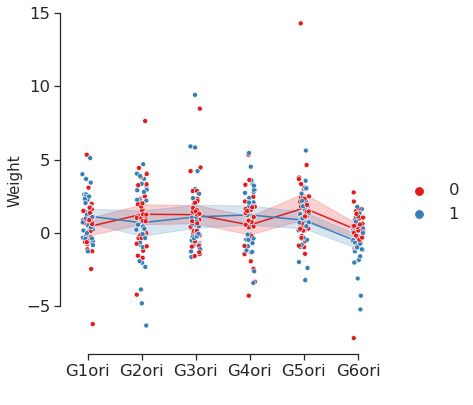

In [1325]:
sizeplot = {}; sizeplot['height'] = 6; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

#dx = 'parameter'; dy = 'value'; hue = 'nrep';  col = 'conf_lvl-1'; row = None
dx = 'parameter'; dy = 'value'; col = None;   hue = 'nrep'; row = None
pal = "Set1"

dat = df_betas[df_betas['parameter'].str.contains('ori')]

# & (~df_betas.NIUB.isin(out_subjs))
mylinesplot(dat  , dx, dy, hue, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)
#myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [1326]:
#dat = df_betas[ (df_betas.parameter != 'intercept') &  (df_betas.nrep == 1)] 
dat = df_betas[df_betas['parameter'].str.contains('ori')]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','nrep'])
resaov = aov.fit()
print(resaov) 

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
parameter  2.7174 5.0000 170.0000 0.0217



/tmp/ipykernel_213146/3311696377.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dat = dat[df_betas['parameter'].str.contains('ori')]


In [ ]:
dat = df_betas[ (df_betas.parameter != 'intercept') &  (df_betas.nrep == 0)] 
dat = dat[df_betas['parameter'].str.contains('ori')]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter'])
resaov = aov.fit()
print(resaov) 

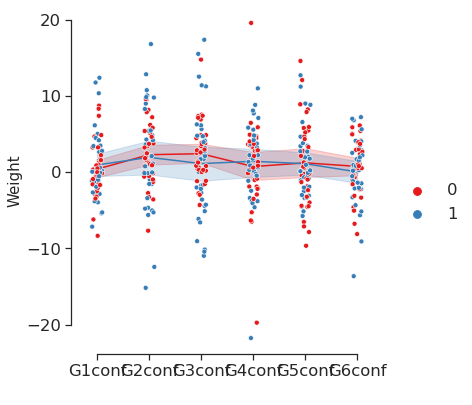

In [1327]:
sizeplot = {}; sizeplot['height'] = 6; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

#dx = 'parameter'; dy = 'value'; hue = 'nrep';  col = 'conf_lvl-1'; row = None
dx = 'parameter'; dy = 'value'; col = None;   hue = 'nrep'; row = None
pal = "Set1"

dat = df_betas[df_betas['parameter'].str.contains('conf')]

# & (~df_betas.NIUB.isin(out_subjs))
mylinesplot(dat  , dx, dy, hue, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)
#myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [1328]:
#dat = df_betas[ (df_betas.parameter != 'intercept') &  (df_betas.nrep == 1)] 
dat = df_betas[df_betas['parameter'].str.contains('conf')]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','nrep'])
resaov = aov.fit()
print(resaov) 

                    Anova
               F Value Num DF  Den DF  Pr > F
---------------------------------------------
parameter       0.9325 5.0000 170.0000 0.4614
nrep            1.1145 1.0000  34.0000 0.2985
parameter:nrep  0.3564 5.0000 170.0000 0.8776



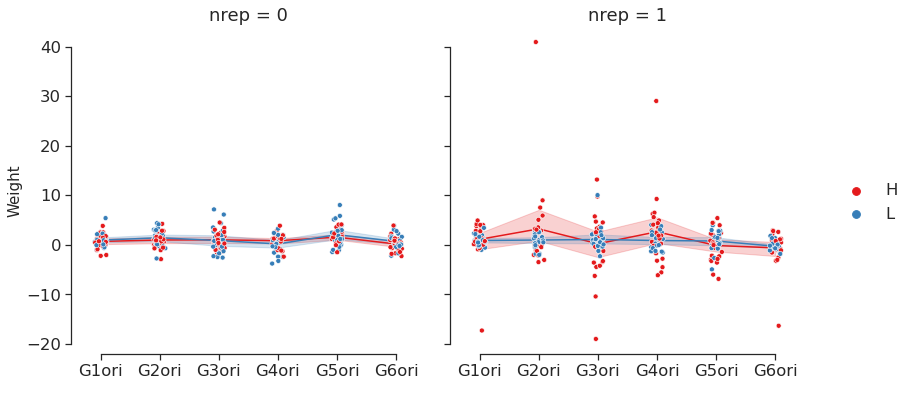

In [810]:
sizeplot = {}; sizeplot['height'] = 6; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; hue = 'nrep';  col = 'conf_lvl-1'; row = None
dx = 'parameter'; dy = 'value'; col = 'nrep';   hue = 'conf_lvl-1'; row = None
pal = "Set1"
# & (~df_betas.NIUB.isin(out_subjs))
mylinesplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, hue, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)
#myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

# HDDM

In [1381]:
%matplotlib inline
import hddm
print(hddm.__version__)

0.9.2


In [1382]:
data = df.iloc[:,[1,3,5,6,7,8,10,12,13,18,19,22]].copy()
dataf = data.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)

dataf = dataf.rename(columns={'npar': 'subj_idx', 'RT': 'rt', 'correct': 'response'})

In [1383]:
dataresp = dataf.copy() # response coding

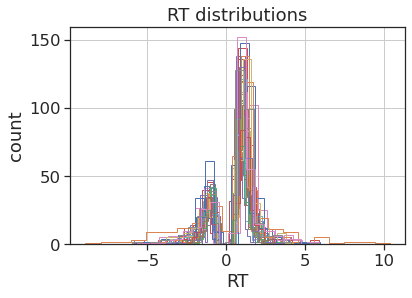

In [1337]:
data = hddm.utils.flip_errors(dataf)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

#plt.savefig('hddm_demo_fig_00.pdf')

In [1113]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/home/freeman/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 891.0 sec

In [1108]:
mqt = hddm.HDDM(data, depends_on={'v': ['nrep'],'a': ['nrep']}, include='z')

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1112]:
mqt.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
mqt.sample(2000, burn=20)

 [-----------------100%-----------------] 2001 of 2000 complete in 362.0 sec

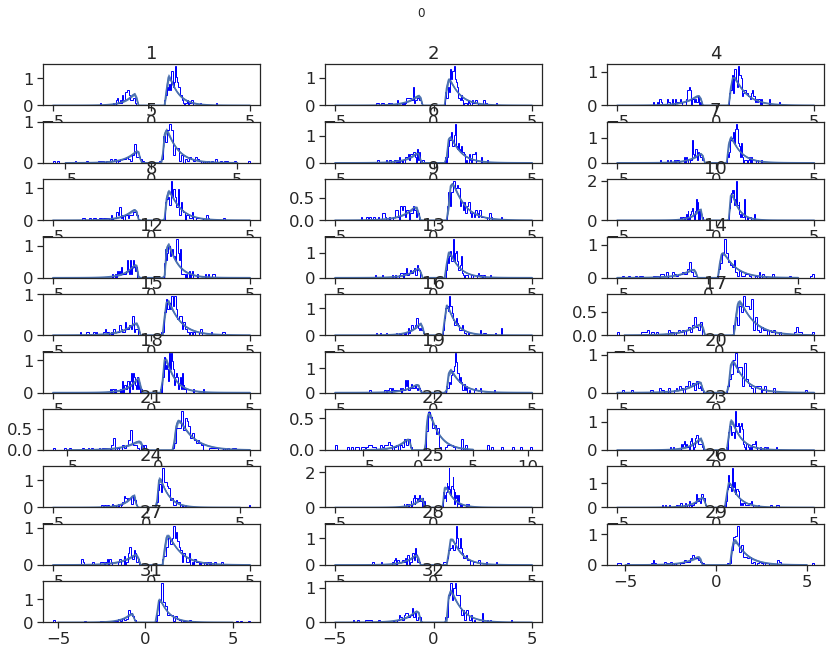

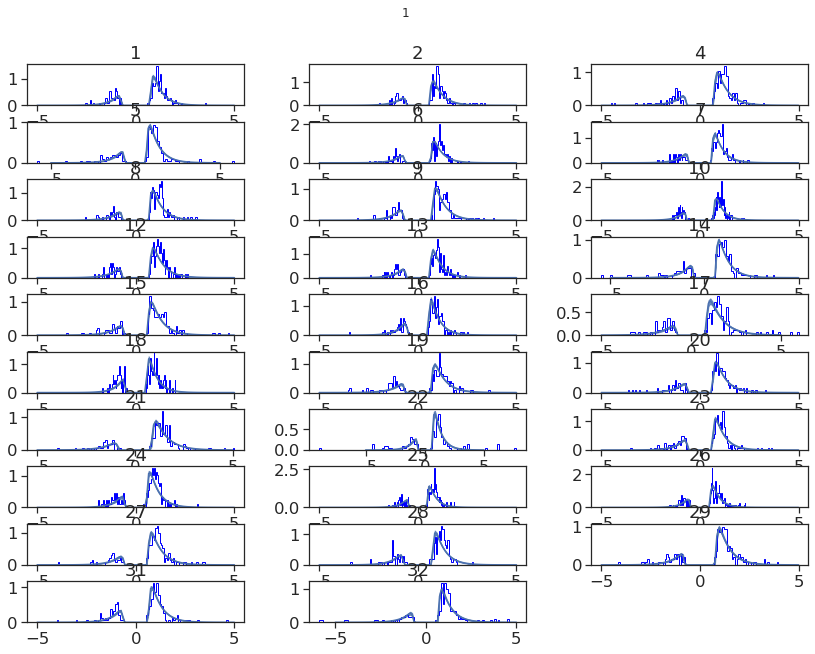

In [1114]:
mqt.plot_posterior_predictive(figsize=(14, 10))


In [1143]:
v0, v1, = mqt.nodes_db.loc[["v(0)", "v(1)"], 'node']

In [1189]:
stats = mqt.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

mean       std      2.5q       25q      50q       75q     97.5q  \
a_std  0.186636  0.021766  0.148536  0.171638  0.18529  0.200093  0.232246   

         mc err  
a_std  0.000609

Plotting a(0)
Plotting a(1)
Plotting a_std
Plotting v(0)
Plotting v(1)
Plotting t


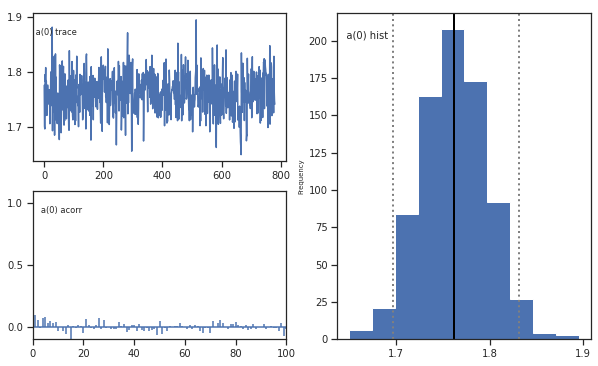

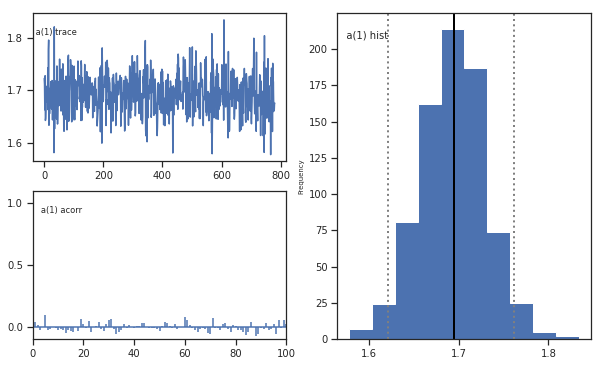

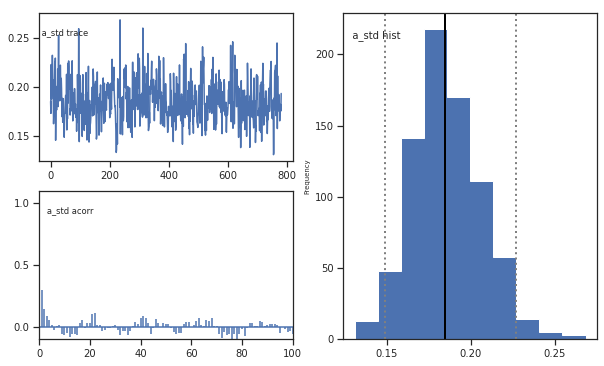

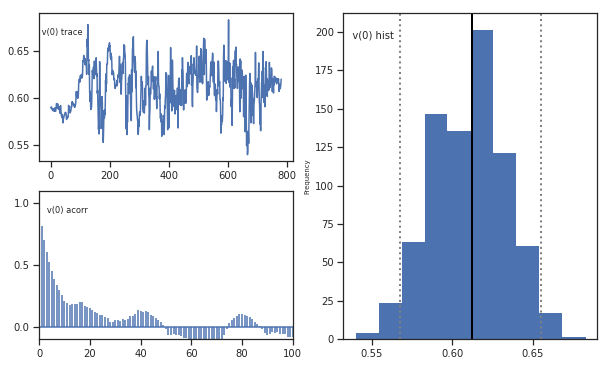

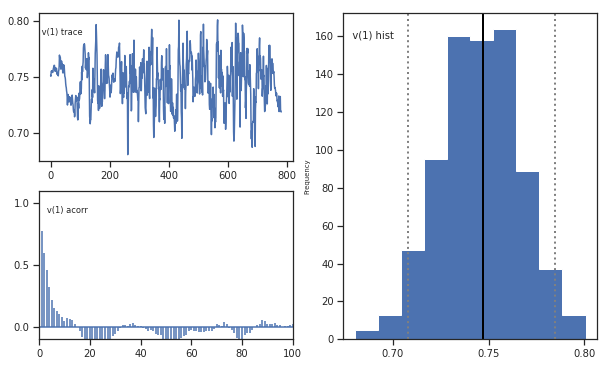

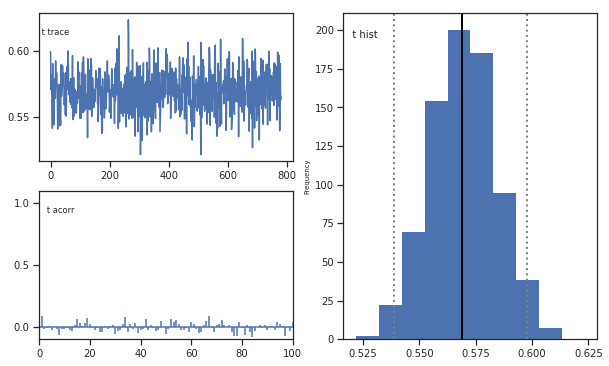

In [1190]:
mqt.plot_posteriors(['a', 't', 'v', 'a_std'])


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

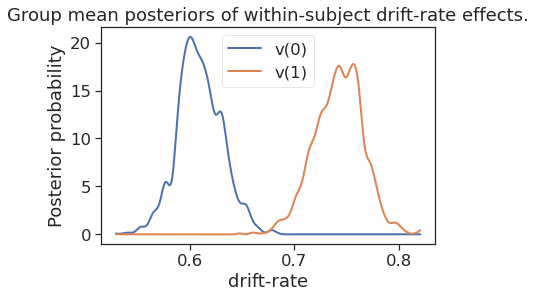

In [1144]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1145]:
a0, a1, = mqt.nodes_db.loc[["a(0)", "a(1)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

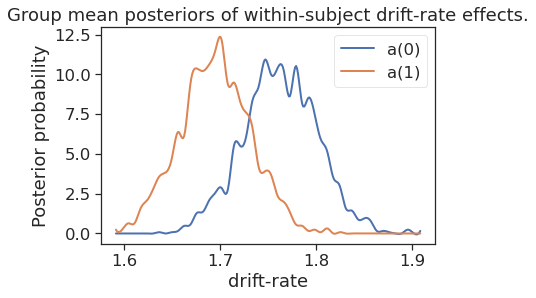

In [1146]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1163]:
data_rep0 = data[data.nrep == 0]
data_rep0.reset_index(inplace = True)


In [1164]:
mqt_rep0 = hddm.HDDM(data_rep0, depends_on={'v': ['blocktype'],'a': ['blocktype']}, include='z')

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1193]:
stats = mqt_rep0.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'v', 'v_std','a(repeated)', 'a(nonrepeated)','v(repeated)', 'v(nonrepeated)'])]

mean       std      2.5q       25q       50q       75q     97.5q  \
a_std  0.206488  0.025485  0.162253  0.188658  0.204872  0.222032  0.261825   
v_std  0.011715   0.01902  0.000001  0.000147  0.001041  0.016844  0.064761   

         mc err  
a_std  0.000712  
v_std  0.001767

Plotting a(nonrepeat)
Plotting a(repeat)
Plotting a_std
Plotting v(nonrepeat)
Plotting v(repeat)
Plotting t


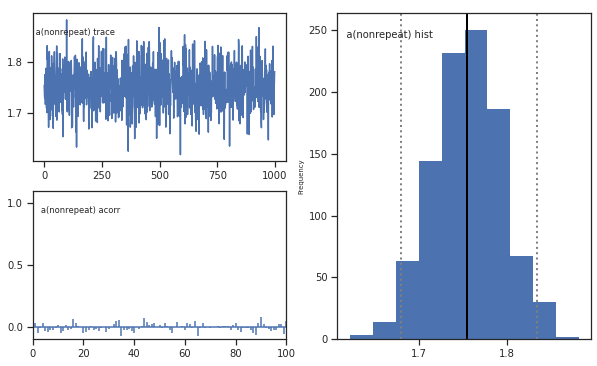

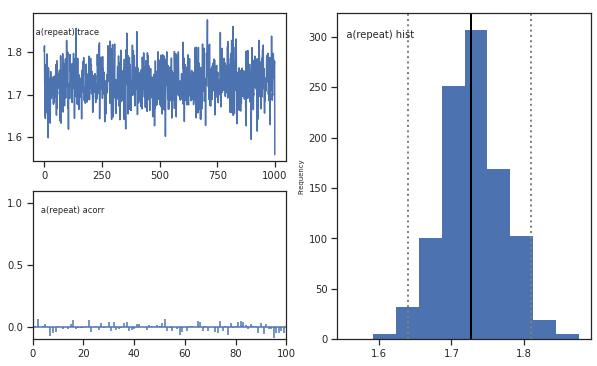

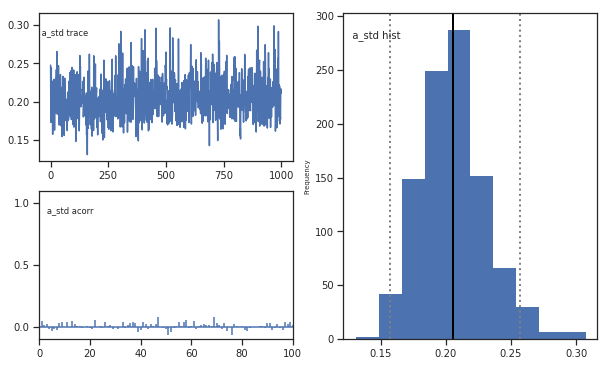

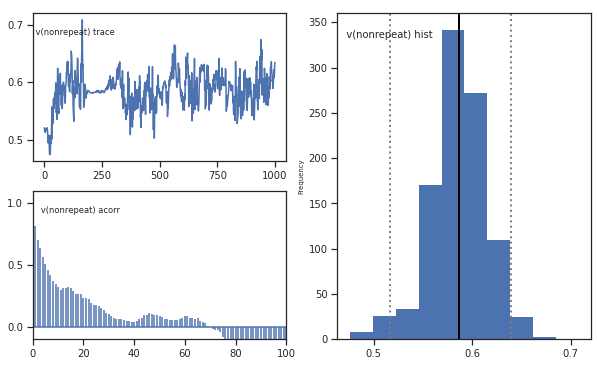

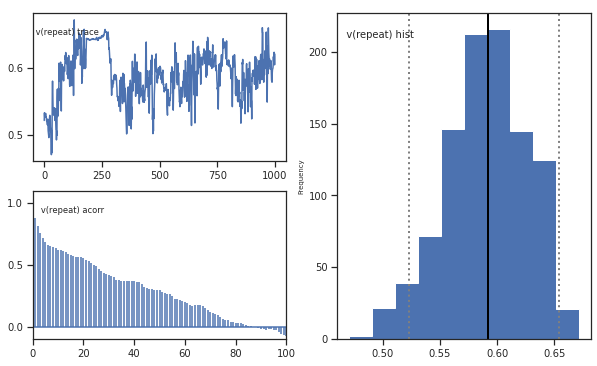

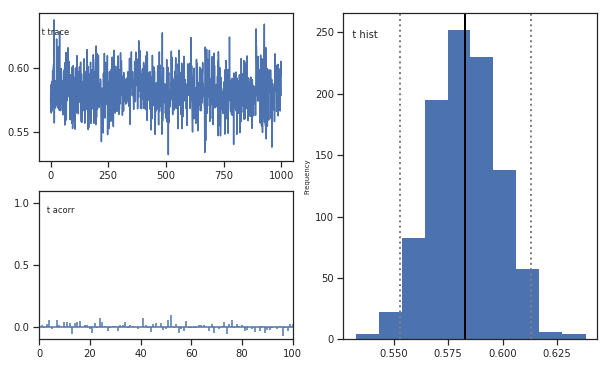

In [1194]:
mqt_rep0.plot_posteriors(['a', 't', 'v', 'a_std'])


In [1174]:
mqt_rep0.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
mqt_rep0.sample(6000, burn=1000, thin=5)

 [-----------------100%-----------------] 6000 of 6000 complete in 1095.0 sec

In [1175]:
v0, v1, = mqt_rep0.nodes_db.loc[["v(repeat)", "v(nonrepeat)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

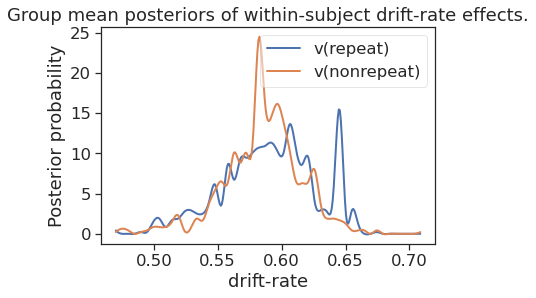

In [1176]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1169]:
a0, a1, = mqt_rep0.nodes_db.loc[["a(repeat)", "a(nonrepeat)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

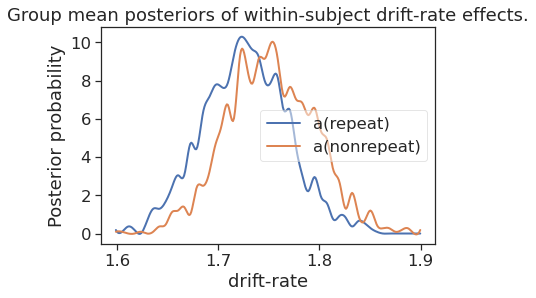

In [1170]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1155]:
data_rep1 = data[data.nrep == 1]
data_rep1.reset_index(inplace = True)


In [1156]:
mqt_rep1 = hddm.HDDM(data_rep1, depends_on={'v': ['blocktype'],'a': ['blocktype']}, include='z')

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1182]:
mqt_rep11 = hddm.HDDM(data_rep1, depends_on={'v': ['blocktype'],'a': ['blocktype']})

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


Plotting v(nonrepeat)
Plotting v(repeat)


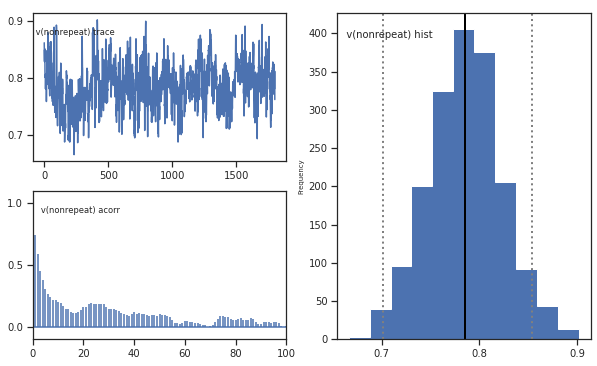

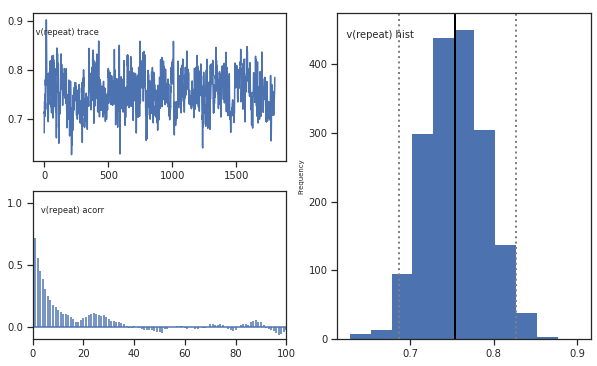

In [1199]:
mqt_rep1.plot_posteriors(['v'])


Plotting a(nonrepeat)
Plotting a(repeat)
Plotting a_std
Plotting v(nonrepeat)
Plotting v(repeat)
Plotting t


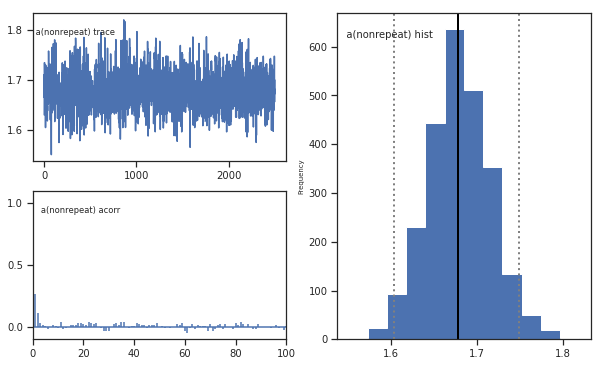

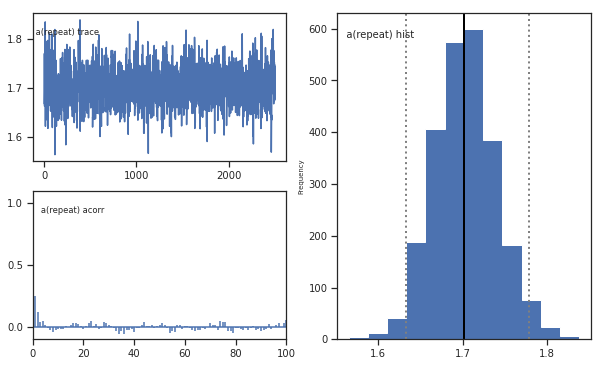

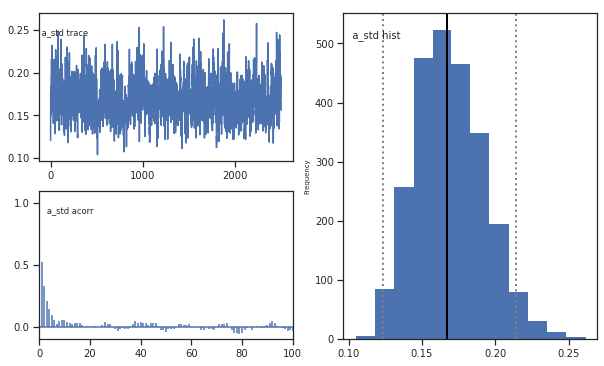

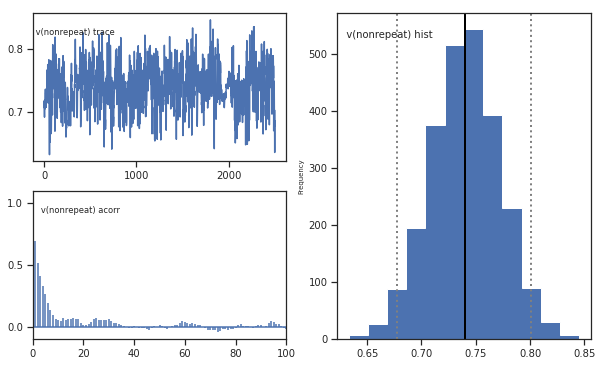

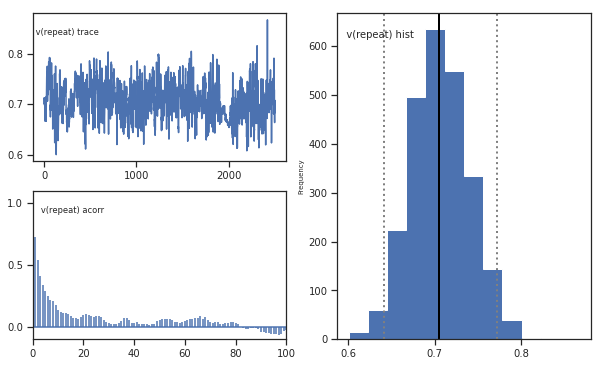

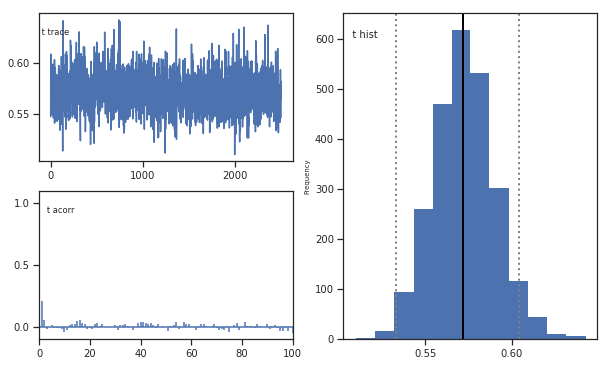

In [1197]:
mqt_rep11.plot_posteriors(['a', 't', 'v', 'a_std','z'])


In [1183]:
mqt_rep11.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
mqt_rep11.sample(3000, burn=500)

 [-----------------100%-----------------] 3000 of 3000 complete in 463.6 sec

In [1204]:
mqt_rep11.nodes_db.loc["z"]

KeyError: 'z'

In [1201]:
z = mqt_rep11.nodes_db.loc[["z"], 'node']

KeyError: "None of [Index(['z'], dtype='object')] are in the [index]"

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

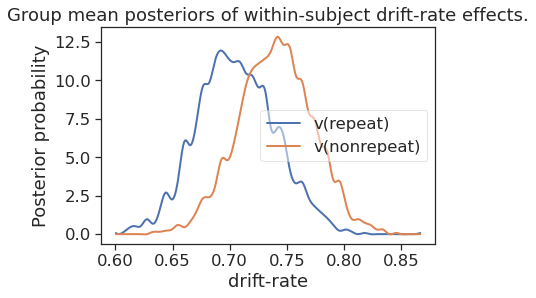

In [1185]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1184]:
v0, v1, = mqt_rep11.nodes_db.loc[["v(repeat)", "v(nonrepeat)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

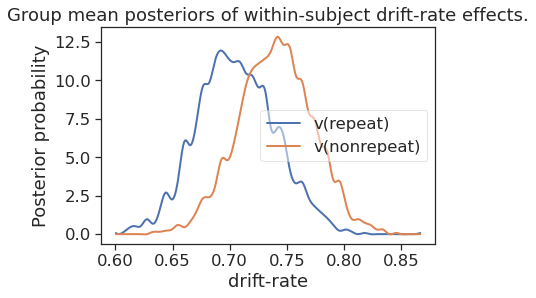

In [1185]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1186]:
a0, a1, = mqt_rep11.nodes_db.loc[["a(repeat)", "a(nonrepeat)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

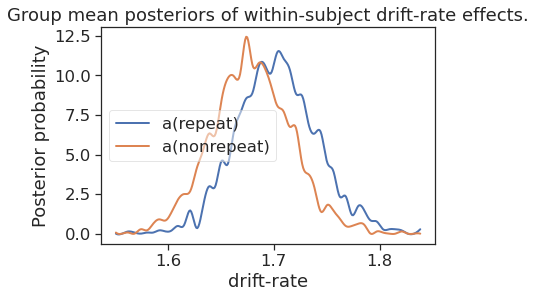

In [1187]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1206]:
mqt_rep11.nodes_db

knode_name stochastic observed   subj               node  \
a(nonrepeat)               a       True    False  False       a(nonrepeat)   
a(repeat)                  a       True    False  False          a(repeat)   
a_std                  a_std       True    False  False              a_std   
a_rate(nonrepeat)     a_rate      False    False  False  a_rate(nonrepeat)   
a_rate(repeat)        a_rate      False    False  False     a_rate(repeat)   
...                      ...        ...      ...    ...                ...   
wfpt(repeat).27         wfpt      False     True  False    wfpt(repeat).27   
wfpt(repeat).28         wfpt      False     True  False    wfpt(repeat).28   
wfpt(repeat).29         wfpt      False     True  False    wfpt(repeat).29   
wfpt(repeat).31         wfpt      False     True  False    wfpt(repeat).31   
wfpt(repeat).32         wfpt      False     True  False    wfpt(repeat).32   

                            tag                depends hidden index subj_idx  \
a(nonrepeat)       (nonrepeat,)            [blocktype]  False   NaN      NaN   
a(repeat)             (repeat,)            [blocktype]  False   NaN      NaN   
a_std                        ()                     []  False   NaN      NaN   
a_rate(nonrepeat)  (nonrepeat,)            [blocktype]   True   NaN      NaN   
a_rate(repeat)        (repeat,)            [blocktype]   True   NaN      NaN   
...                         ...                    ...    ...   ...      ...   
wfpt(repeat).27       (repeat,)  [blocktype, subj_idx]  False   NaN       27   
wfpt(repeat).28       (repeat,)  [blocktype, subj_idx]  False   NaN       28   
wfpt(repeat).29       (repeat,)  [blocktype, subj_idx]  False   NaN       29   
wfpt(repeat).31       (repeat,)  [blocktype, subj_idx]  False   NaN       31   
wfpt(repeat).32       (repeat,)  [blocktype, subj_idx]  False   NaN       32   

                  nblock nrep cond-1  blocktype  rDV cond deci-1 deci  \
a(nonrepeat)         NaN  NaN    NaN  nonrepeat  NaN  NaN    NaN  NaN   
a(repeat)            NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   
a_std                NaN  NaN    NaN        NaN  NaN  NaN    NaN  NaN   
a_rate(nonrepeat)    NaN  NaN    NaN  nonrepeat  NaN  NaN    NaN  NaN   
a_rate(repeat)       NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   
...                  ...  ...    ...        ...  ...  ...    ...  ...   
wfpt(repeat).27      NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   
wfpt(repeat).28      NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   
wfpt(repeat).29      NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   
wfpt(repeat).31      NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   
wfpt(repeat).32      NaN  NaN    NaN     repeat  NaN  NaN    NaN  NaN   

                  response confi   rt      mean       std      2.5q       25q  \
a(nonrepeat)           NaN   NaN  NaN  1.679493  0.036719  1.608107  1.655153   
a(repeat)              NaN   NaN  NaN  1.702803  0.037361  1.633899  1.677902   
a_std                  NaN   NaN  NaN  0.168894  0.023743  0.127758  0.152076   
a_rate(nonrepeat)      NaN   NaN  NaN       NaN       NaN       NaN       NaN   
a_rate(repeat)         NaN   NaN  NaN       NaN       NaN       NaN       NaN   
...                    ...   ...  ...       ...       ...       ...       ...   
wfpt(repeat).27        NaN   NaN  NaN       NaN       NaN       NaN       NaN   
wfpt(repeat).28        NaN   NaN  NaN       NaN       NaN       NaN       NaN   
wfpt(repeat).29        NaN   NaN  NaN       NaN       NaN       NaN       NaN   
wfpt(repeat).31        NaN   NaN  NaN       NaN       NaN       NaN       NaN   
wfpt(repeat).32        NaN   NaN  NaN       NaN       NaN       NaN       NaN   

                        50q       75q     97.5q    mc err         map  
a(nonrepeat)       1.678703   1.70341  1.755083  0.000997    1.609028  
a(repeat)          1.702321  1.726666  1.780801  0.000981    1.631193  
a_std              0.167395  0.184727   0.21846  0.000

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

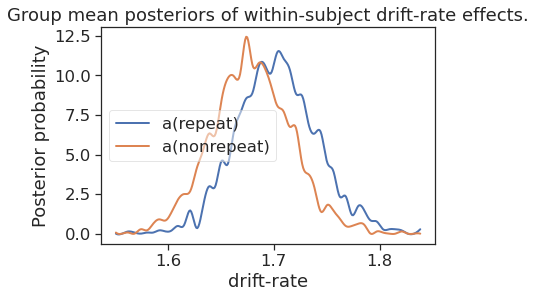

In [1187]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1159]:
v0, v1, = mqt_rep1.nodes_db.loc[["v(repeat)", "v(nonrepeat)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

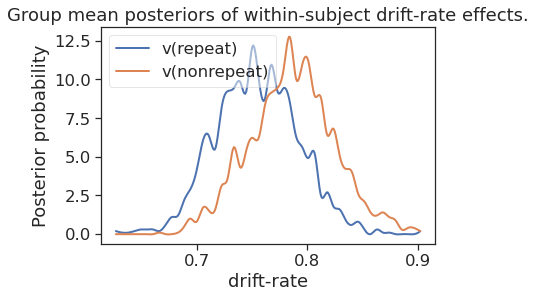

In [1160]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1161]:
a0, a1, = mqt_rep1.nodes_db.loc[["a(repeat)", "a(nonrepeat)"], 'node']

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

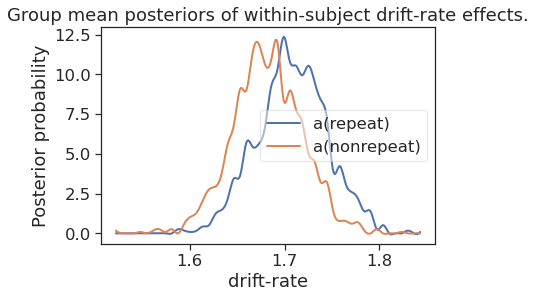

In [1162]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1109]:
params1 = mqt.optimize('chisquare')


No model attribute --> setting up standard HDDM
Includes supplied:  {'z', 'a', 'v', 't'}
Set model to ddm


/home/freeman/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 454.017557
         Iterations: 7
         Function evaluations: 595
Optimization terminated successfully.
         Current function value: 454.020652
         Iterations: 7
         Function evaluations: 657
Optimization terminated successfully.
         Current function value: 454.019418
         Iterations: 5
         Function evaluations: 434


In [1207]:
data

subj_idx nblock  nrep cond-1  blocktype       rDV  cond  deci-1  deci  \
0            1      0     0      0  nonrepeat  0.089044     1      -1     1   
1            1      0     1      1  nonrepeat  0.068067     1       1     1   
2            1      0     0      1  nonrepeat -0.027166     0       1     1   
3            1      0     1      0  nonrepeat  0.001867     0       1     0   
4            1      0     0      0  nonrepeat -0.086152     0      -1     0   
...        ...    ...   ...    ...        ...       ...   ...     ...   ...   
10115       32      3     1      1     repeat -0.008068     1      -1     1   
10116       32      3     0      1     repeat -0.101101     0       1     0   
10117       32      3     1      0     repeat -0.101101     0      -1     0   
10118       32      3     0      0     repeat -0.085562     0      -1     1   
10119       32      3     1      0     repeat -0.085562     0       1     1   

       response  confi        rt  
0             1   0.10  2.044453  
1             1   0.35  2.114065  
2             0   0.75 -1.752747  
3             1  -0.15  1.981836  
4             1   0.40  2.481966  
...         ...    ...       ...  
10115         1   0.20  1.219473  
10116         1   0.60  2.102748  
10117         1   0.75  0.986051  
10118         0   0.75 -1.302735  
10119         0   0.30 -1.136110  

[10016 rows x 12 columns]

In [ ]:
model = hddm.HDDMStimCoding(data, include='z', stim_col='stim', split_param='v')


In [1143]:
v0, v1, = mqt.nodes_db.loc[["v(0)", "v(1)"], 'node']

In [1214]:
mod_stim = hddm.HDDMStimCoding(dataresp, include='z',  depends_on={'v': ['nrep'],'a': ['nrep']}, stim_col='cond', split_param='v')


No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1216]:
mod_stim.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
mod_stim.sample(2000, burn=200)

 [-----------------100%-----------------] 2001 of 2000 complete in 565.2 sec

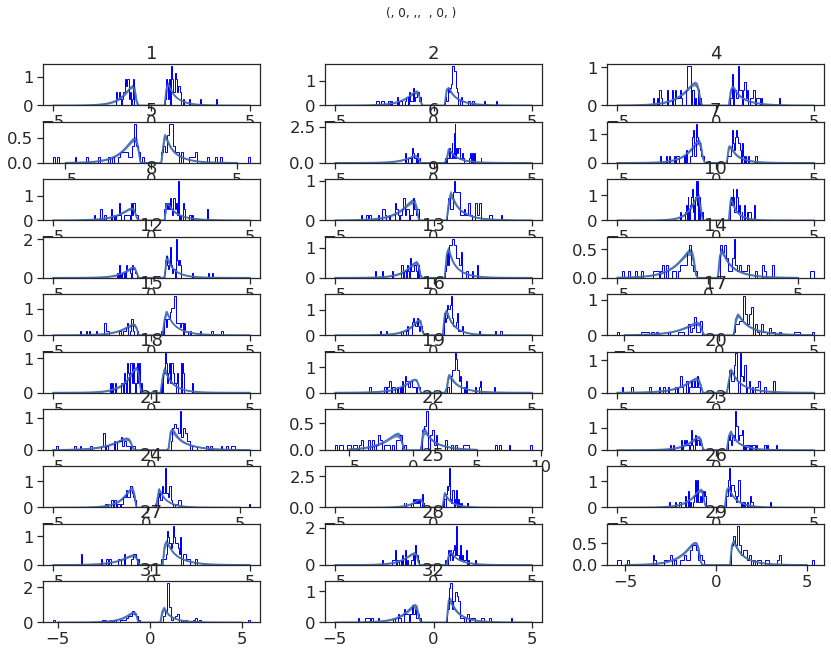

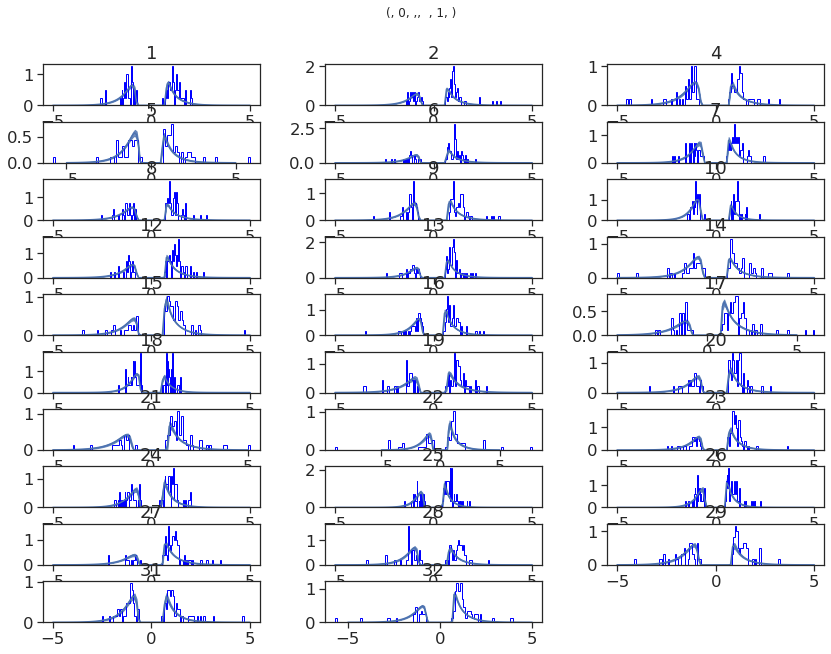

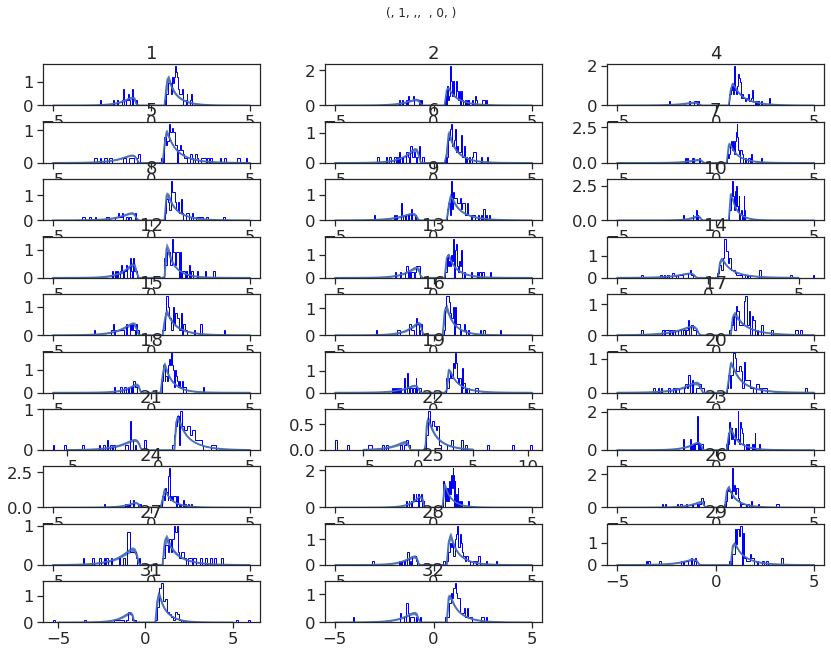

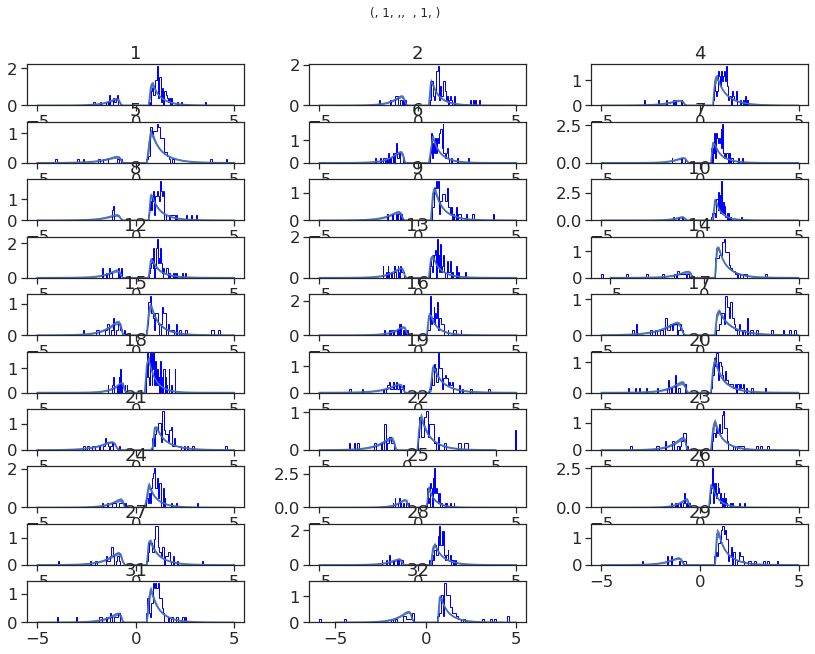

In [1217]:
mod_stim.plot_posterior_predictive(figsize=(14, 10))


Plotting a(0)
Plotting a(1)
Plotting a_std
Plotting v(0)
Plotting v(1)
Plotting t


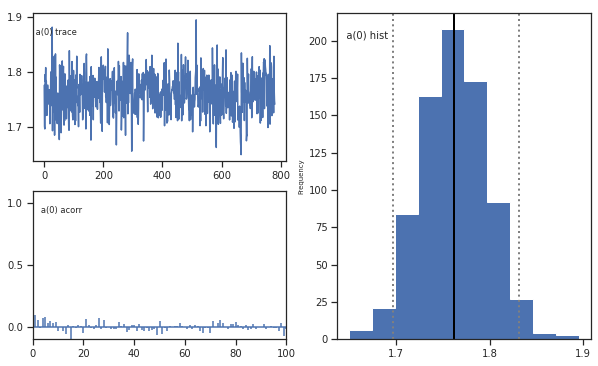

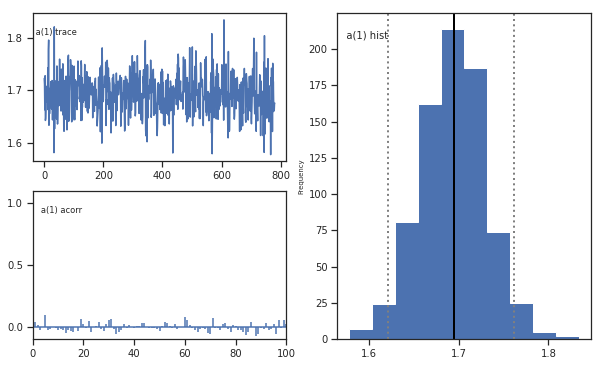

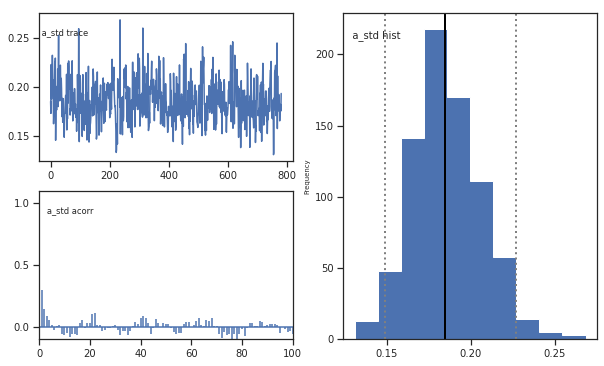

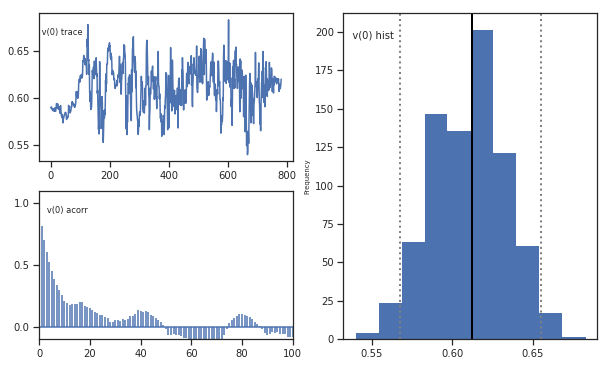

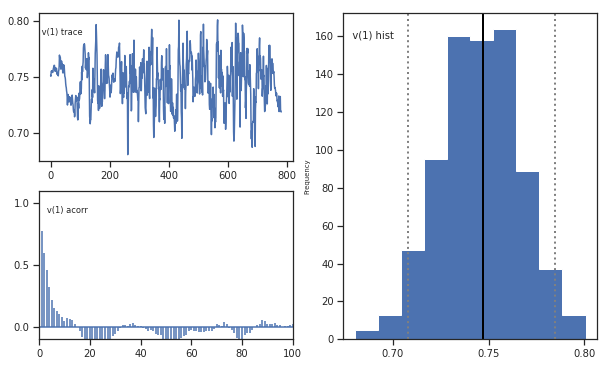

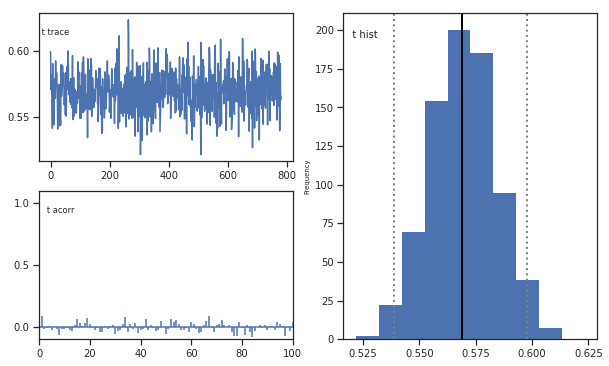

In [1218]:
mqt.plot_posteriors(['a', 't', 'v', 'a_std'])

In [1223]:
v0, v1, = mqt.nodes_db.loc[["v(0)", "v(1)"], 'node']
a0, a1, = mqt.nodes_db.loc[["a(0)", "a(1)"], 'node']
stats = mqt.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]



mean       std      2.5q       25q      50q       75q     97.5q  \
a_std  0.186636  0.021766  0.148536  0.171638  0.18529  0.200093  0.232246   

         mc err  
a_std  0.000609

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

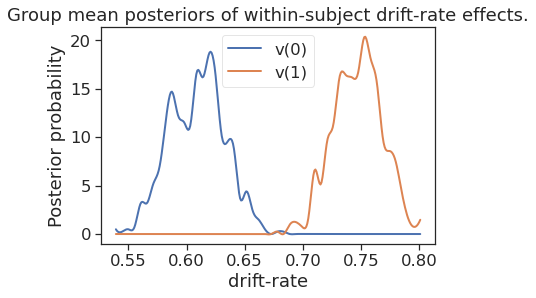

In [1221]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

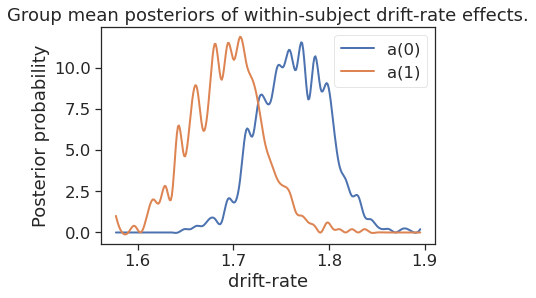

In [1224]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1338]:
mod_stimblockty = hddm.HDDMStimCoding(dataresp[dataresp.nrep == 1], include='z',  depends_on={'v': ['blocktype'],'a': ['blocktype']}, stim_col='cond', split_param='v')


No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1364]:
mod_stimblockty.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
mod_stimblockty.sample(10000, burn=1000)

 [-----------------100%-----------------] 10001 of 10000 complete in 3478.5 sec               1%                  ] 145 of 10000 complete in 50.6 sec[-----------------90%--------------    ] 9077 of 10000 complete in 3155.4 sec

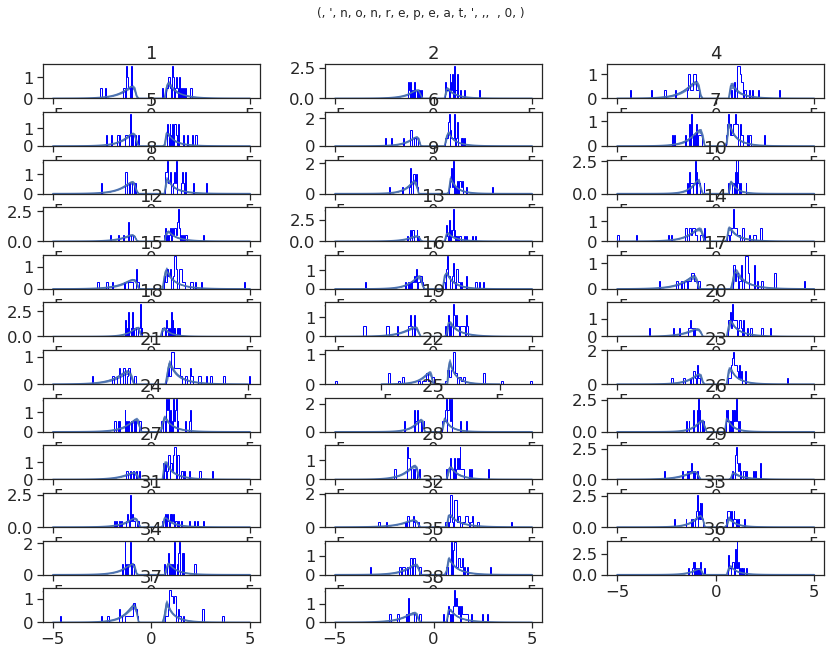

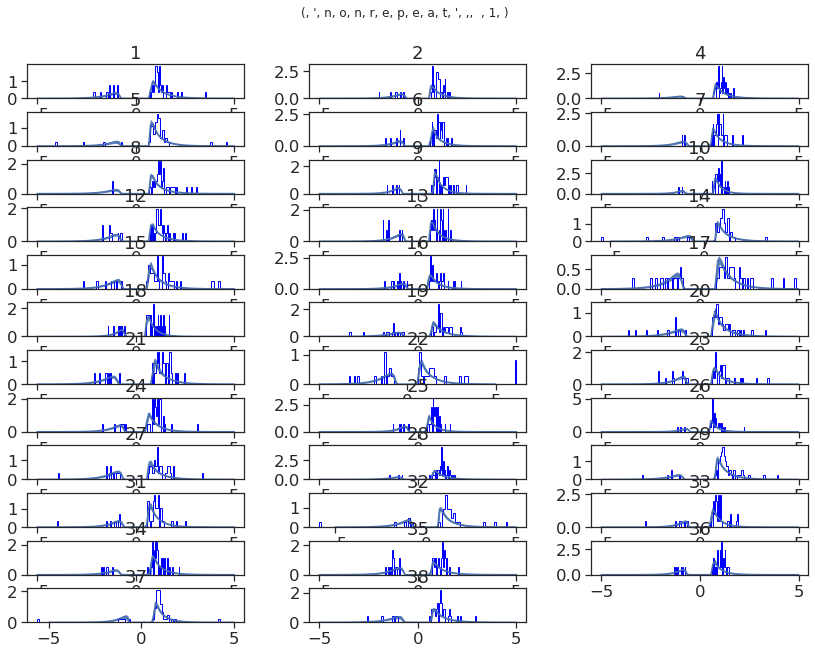

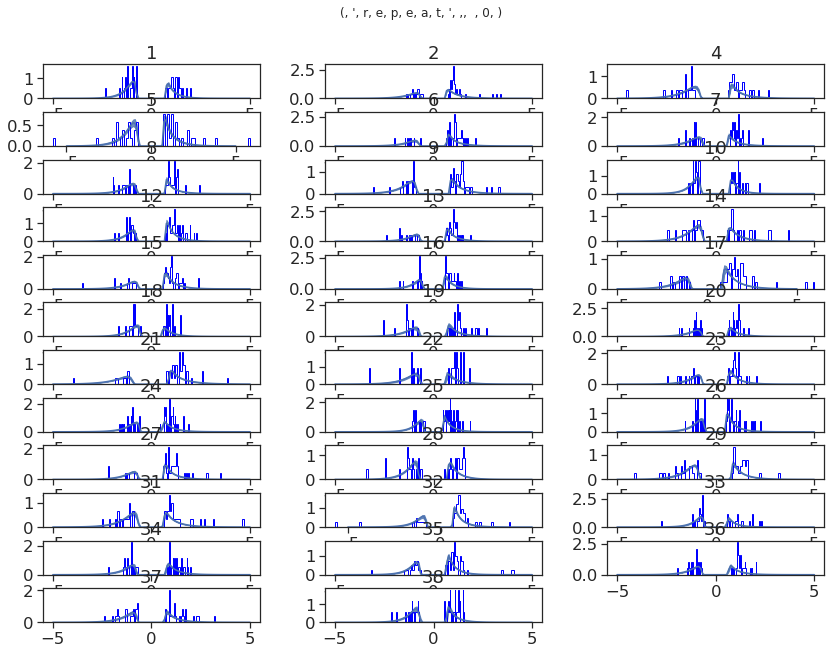

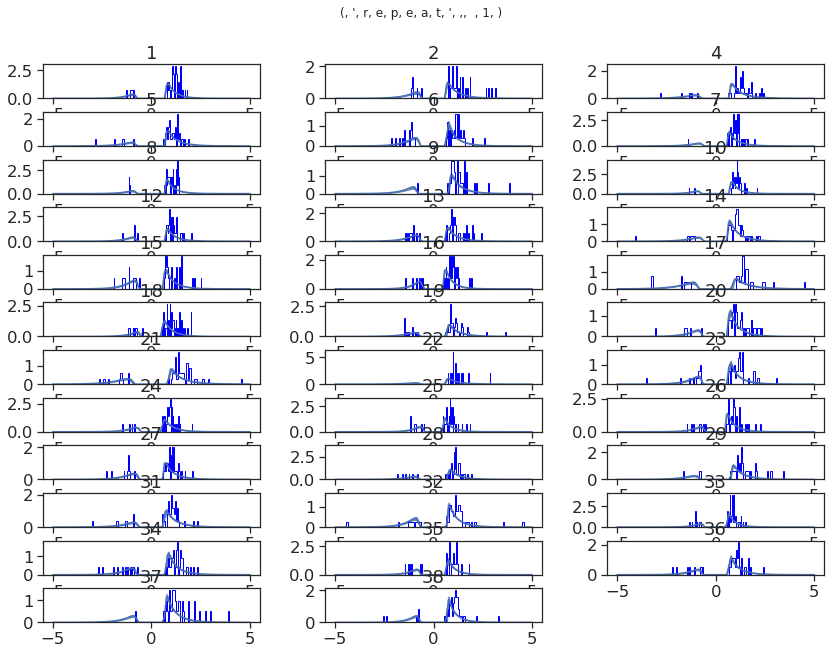

In [1365]:
mod_stimblockty.plot_posterior_predictive(figsize=(14, 10))


Plotting a(nonrepeat)
Plotting a(repeat)
Plotting a_std
Plotting v(nonrepeat)
Plotting v(repeat)
Plotting t


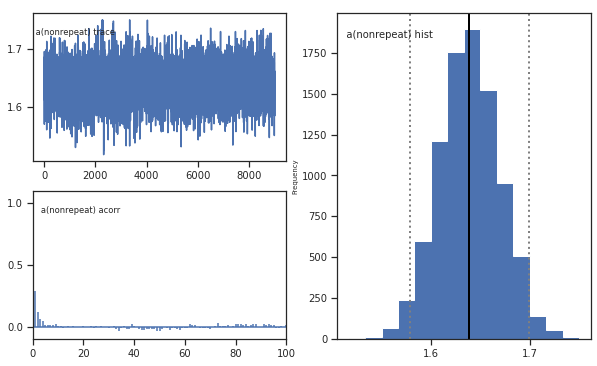

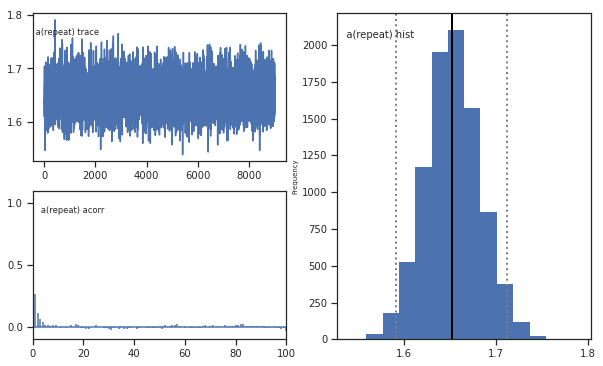

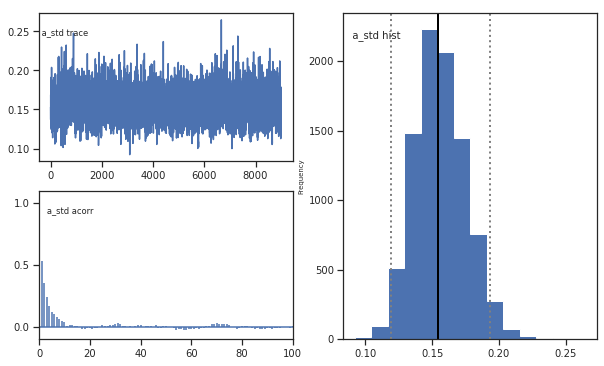

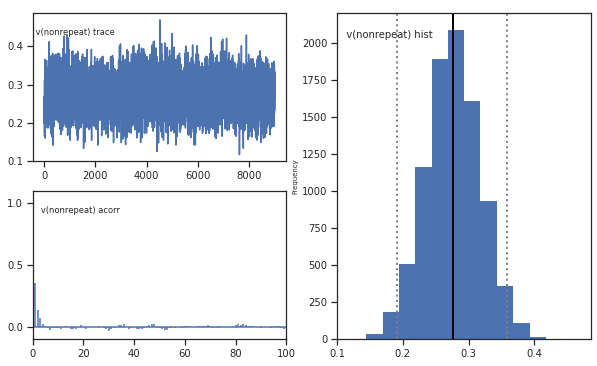

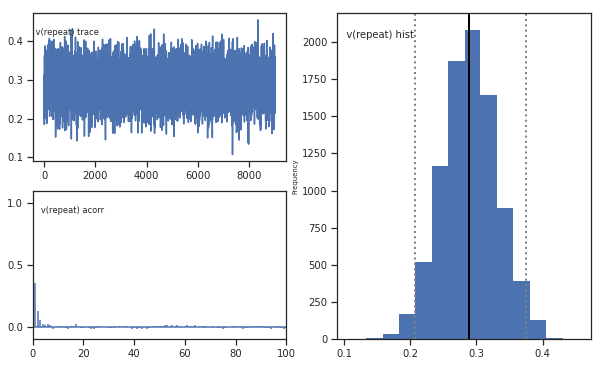

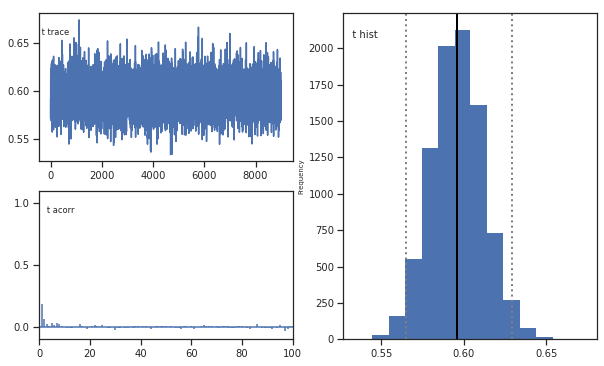

In [1366]:
mod_stimblockty.plot_posteriors(['a', 't', 'v', 'a_std'])

In [1367]:
v0, v1, = mod_stimblockty.nodes_db.loc[["v(repeat)", "v(nonrepeat)"], 'node']
a0, a1, = mod_stimblockty.nodes_db.loc[["a(repeat)", "a(nonrepeat)"], 'node']
stats = mod_stimblockty.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]



mean       std      2.5q       25q       50q       75q     97.5q  \
a_std  0.15591  0.019592  0.120638  0.142169  0.154711  0.168525  0.196756   

         mc err  
a_std  0.000371

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

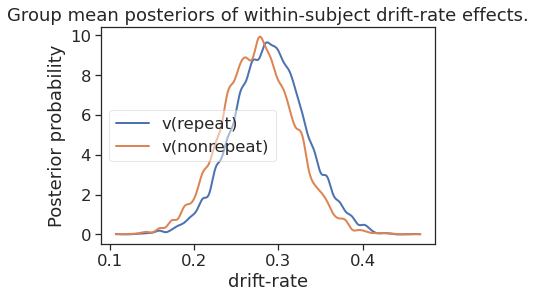

In [1368]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


In [1369]:
v_repeat, v_nonrepeat = mod_stimblockty.nodes_db.node[['v(repeat)', 'v(nonrepeat)']]
#print("P_v(Repeat > NonRepeat)= ") (
(v_repeat.trace() > v_nonrepeat.trace()).mean()

0.5881111111111111

In [1370]:
a_repeat, a_nonrepeat = mod_stimblockty.nodes_db.node[['a(repeat)', 'a(nonrepeat)']]
#print("P_v(Repeat > NonRepeat)= ") (
(a_repeat.trace() > a_nonrepeat.trace()).mean()

0.6245555555555555

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

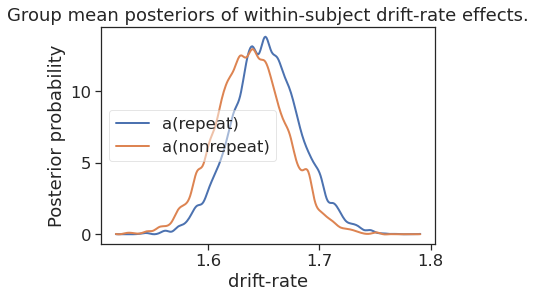

In [1371]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')

In [1385]:
dataresp

subj_idx nblock  nrep cond-1  blocktype       rDV  cond  deci-1  deci  \
0            1      0     0      0  nonrepeat  0.089044     1       0     1   
1            1      0     1      1  nonrepeat  0.068067     1       1     1   
2            1      0     0      1  nonrepeat -0.027166     0       1     1   
3            1      0     1      0  nonrepeat  0.001867     0       1     0   
4            1      0     0      0  nonrepeat -0.086152     0       0     0   
...        ...    ...   ...    ...        ...       ...   ...     ...   ...   
14339       44      3     1      1     repeat  0.204563     1       0     1   
14340       44      3     0      1     repeat  0.289281     1       1     1   
14341       44      3     1      1     repeat  0.289281     1       1     1   
14342       44      3     0      1     repeat -0.296323     0       1     0   
14343       44      3     1      0     repeat -0.296323     0       0     0   

       response  confi        rt  
0             1   0.10  2.044453  
1             1   0.35  2.114065  
2             0   0.75  1.752747  
3             1  -0.15  1.981836  
4             1   0.40  2.481966  
...         ...    ...       ...  
14339         1   0.75  0.697239  
14340         1   0.70  0.947157  
14341         1   0.50  0.690167  
14342         1   0.60  0.989039  
14343         1   0.70  0.836251  

[14186 rows x 12 columns]

In [1397]:
dataresp['cong'] = 0

In [1400]:
dataresp.loc[dataresp['cond'] == dataresp['deci-1'], 'cong'] = 1 

In [1409]:
mod_stimblockt = hddm.HDDMStimCoding(dataresp[dataresp.nrep == 1], include='z',  depends_on={'v': ['cong'],'a': ['cong']}, stim_col='cond', split_param='v')


No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1411]:
mod_stimblockt.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
mod_stimblockt.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 393.2 sec

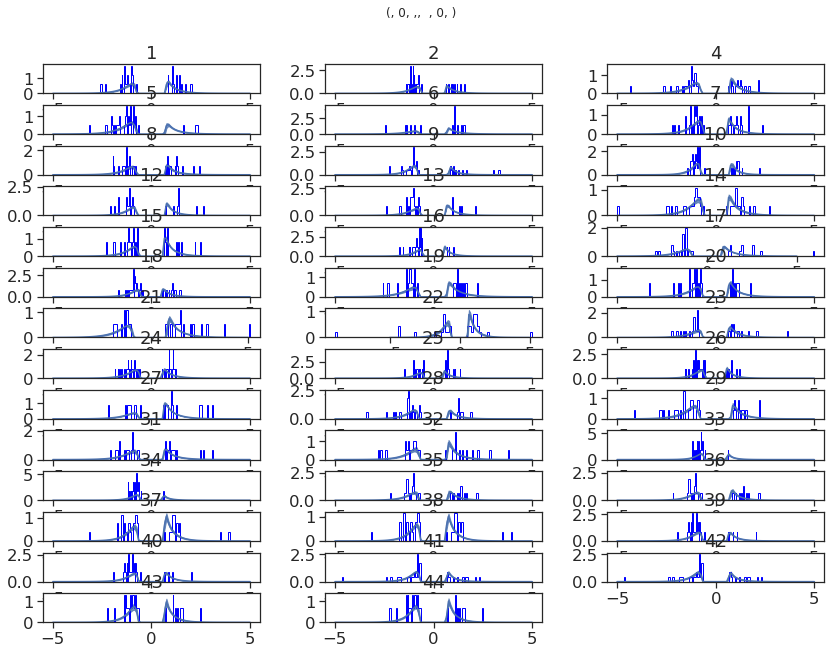

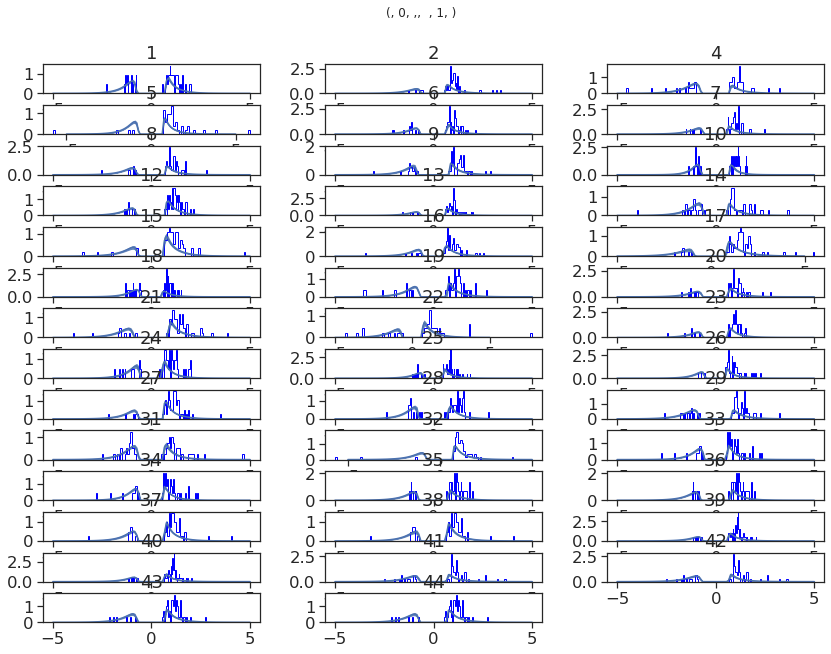

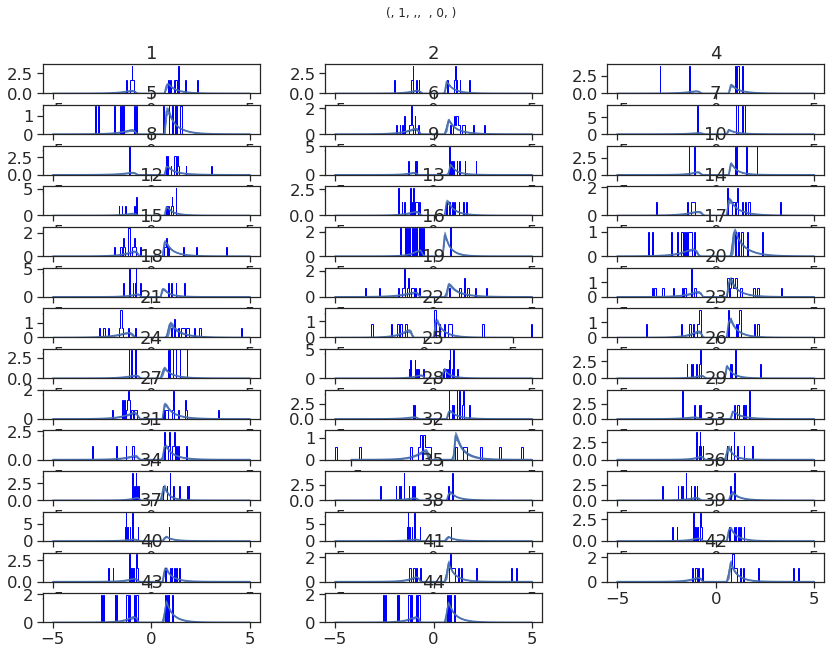

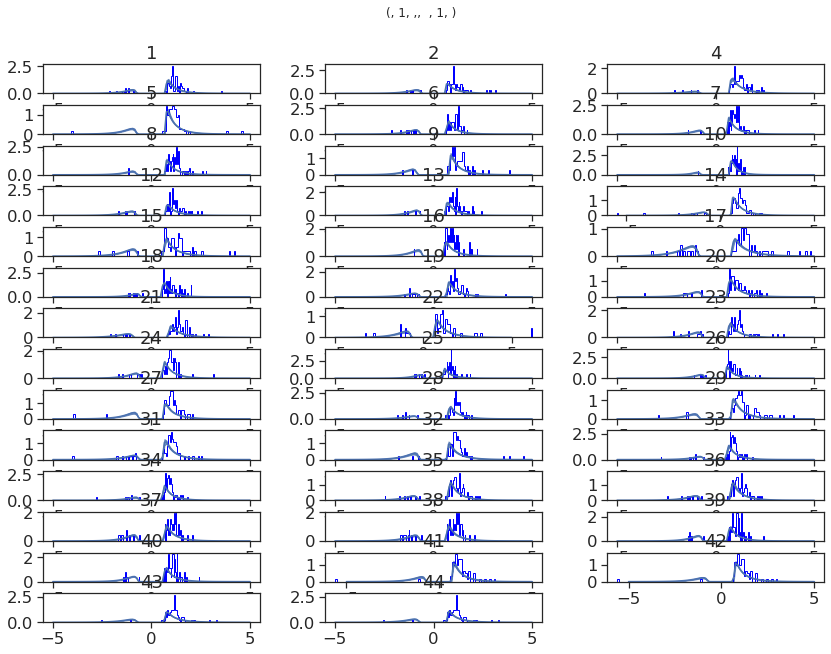

In [1412]:
mod_stimblockt.plot_posterior_predictive(figsize=(14, 10))


Plotting a(0)
Plotting a(1)
Plotting a_std
Plotting v(0)
Plotting v(1)
Plotting t


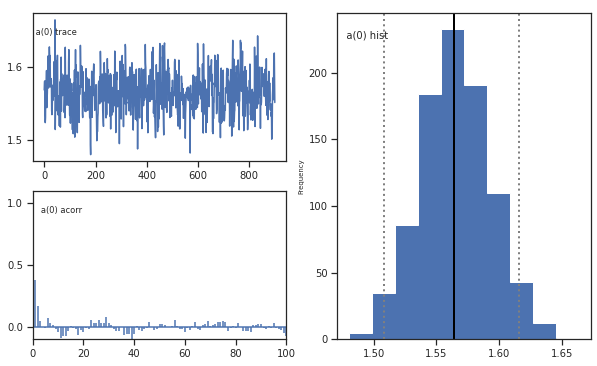

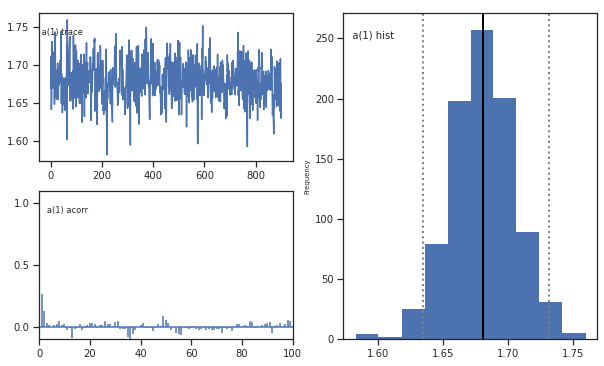

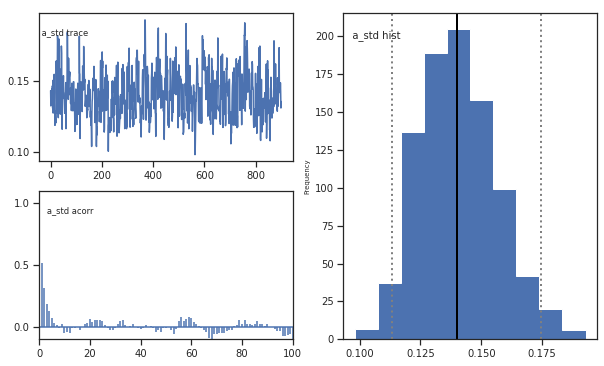

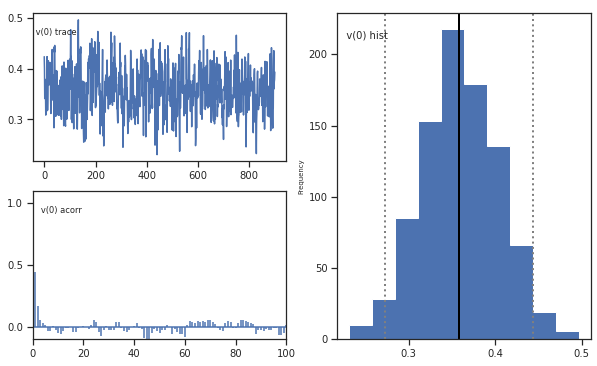

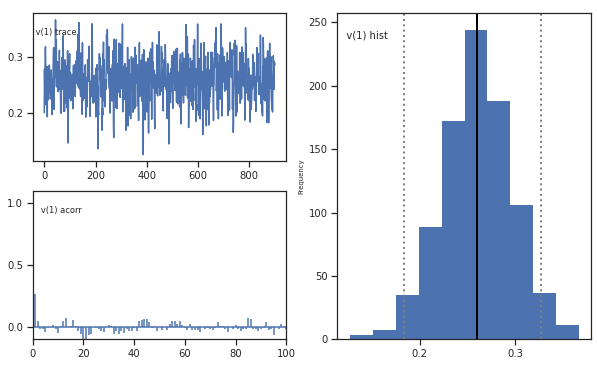

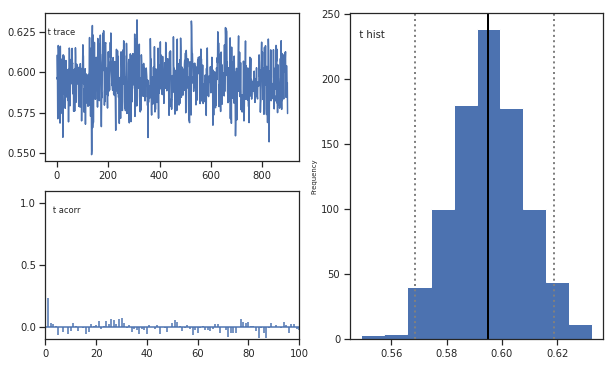

In [1414]:
mod_stimblockt.plot_posteriors(['a', 't', 'v', 'a_std'])

In [1416]:
v0, v1, = mod_stimblockt.nodes_db.loc[["v(0)", "v(1)"], 'node']
a0, a1, = mod_stimblockt.nodes_db.loc[["a(0)", "a(1)"], 'node']
stats = mod_stimblockt.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]



mean       std      2.5q       25q       50q       75q     97.5q  \
a_std  0.140636  0.016058  0.113481  0.128687  0.139854  0.150656  0.174477   

         mc err  
a_std  0.000908

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

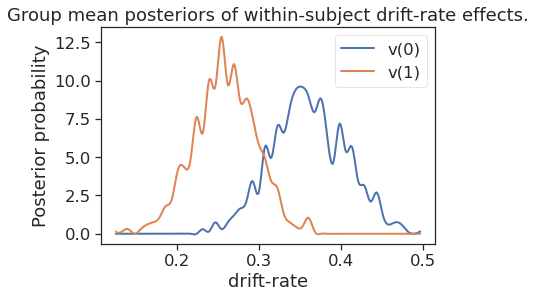

In [1417]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

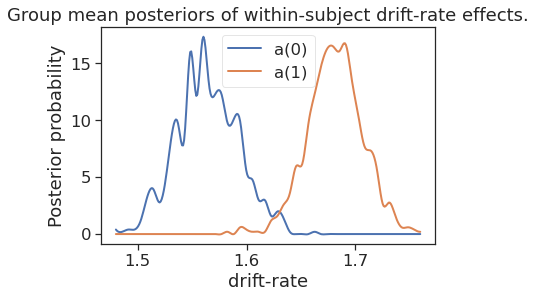

In [1420]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


In [1419]:
v_repeat, v_nonrepeat = mod_stimblockt.nodes_db.node[['v(0)', 'v(1)']]
#print("P_v(Repeat > NonRepeat)= ") (
(v_repeat.trace() > v_nonrepeat.trace()).mean()

0.9555555555555556

In [1370]:
a_repeat, a_nonrepeat = mod_stimblockty.nodes_db.node[['a(repeat)', 'a(nonrepeat)']]
#print("P_v(Repeat > NonRepeat)= ") (
(a_repeat.trace() > a_nonrepeat.trace()).mean()

0.6245555555555555

In [ ]:
mod_stimblockt = hddm.HDDMStimCoding(dataresp[dataresp.nrep == 1], include='z',  depends_on={'v': ['cong'],'a': ['cong']}, stim_col='cond', split_param='v')


In [1442]:
card_exp_mod = hddm.HDDM(dataresp[(dataresp.nrep == 1)&(dataresp.cond == 0)], include='z', depends_on={'v': ['cong'],'a': ['cong']})

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1444]:
card_exp_mod.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
card_exp_mod.sample(3000, burn=400)

 [-----------------100%-----------------] 3000 of 3000 complete in 657.0 sec

In [1445]:
v0, v1, = card_exp_mod.nodes_db.loc[["v(0)", "v(1)"], 'node']
a0, a1, = card_exp_mod.nodes_db.loc[["a(0)", "a(1)"], 'node']


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

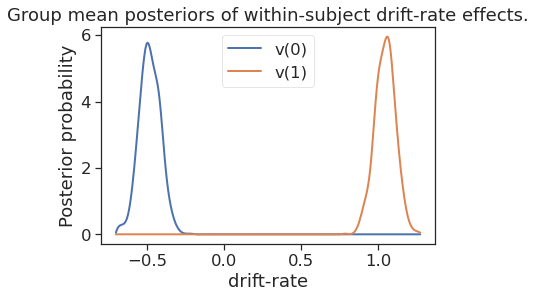

In [1446]:
v0, v1, = card_exp_mod.nodes_db.loc[["v(0)", "v(1)"], 'node']
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

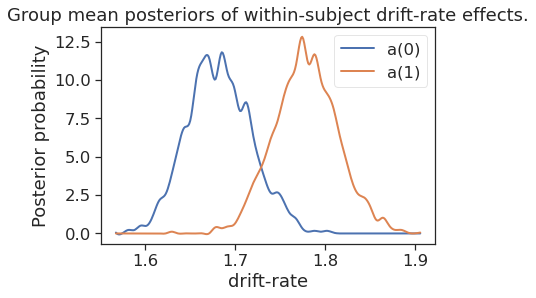

In [1447]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


In [1448]:
diag_exp_mod = hddm.HDDM(dataresp[(dataresp.nrep == 1)&(dataresp.cond == 1)], include='z', depends_on={'v': ['cong'],'a': ['cong']})

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm


In [1450]:
diag_exp_mod.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
diag_exp_mod.sample(3000, burn=400)

 [-----------------100%-----------------] 3000 of 3000 complete in 674.6 sec

In [1434]:
v0, v1, = diag_exp_mod.nodes_db.loc[["v(0)", "v(1)"], 'node']
a0, a1, = diag_exp_mod.nodes_db.loc[["a(0)", "a(1)"], 'node']


In [1435]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


AttributeError: 'Normal' object has no attribute 'trace'

<Figure size 432x288 with 0 Axes>

In [1439]:
hddm.analyze.plot_posterior_nodes([a0, a1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


AttributeError: 'Gamma' object has no attribute 'trace'

<Figure size 432x288 with 0 Axes>

In [1462]:
m

Plotting t


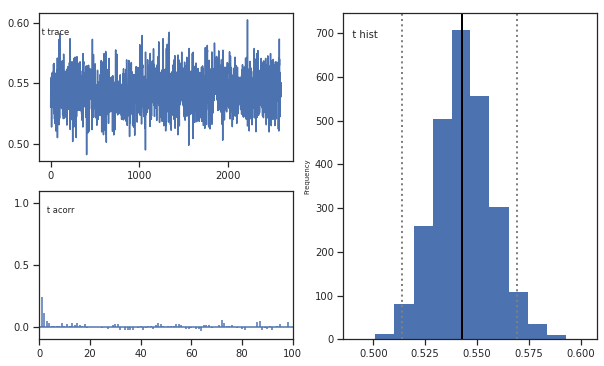

In [1461]:
m.plot_posteriors(['a', 't', 'v', 'a_std','z'])


In [1456]:
dataresp.rDV = np.abs(dataresp.rDV)

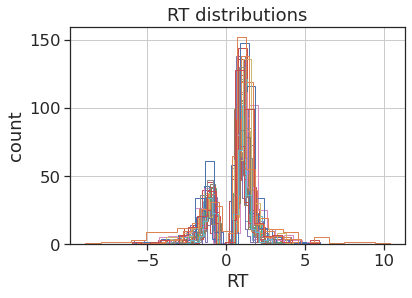

In [1511]:
data = hddm.utils.flip_errors(dataresp)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

#plt.savefig('hddm_demo_fig_00.pdf')

DIAGONAL

In [1538]:
m_diag_simple1 = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 1)], ['v ~ C(cong,Treatment(0))','a ~ C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c760b1160>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c7c4a44c0>}
Uses Identity Link


In [1617]:
m_c = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 0)], 
                                ['v ~ rDV+ C(cong,Treatment(0))','a ~ rDV+ C(cong,Treatment(0))'],include='z')

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV+ C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c4895dee0>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV+ C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c7289a160>}
Uses Identity Link


In [1618]:
m_c.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_c.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1254.5 sec

In [1619]:
m_c.print_stats()

                                  mean       std      2.5q       25q       50q       75q     97.5q    mc err
t                             0.564467   0.01359   0.53912  0.555489  0.564271  0.573537   0.59122  0.000612
t_std                         0.086432  0.011263   0.06802  0.078722  0.085083   0.09278  0.111637  0.000536
t_subj.1                      0.637464  0.019918  0.592141    0.6252  0.639796  0.652248  0.669131  0.000758
t_subj.2                      0.498459  0.018157  0.458779  0.486866  0.501024  0.510837  0.528268  0.000786
t_subj.3                      0.563815  0.086061  0.409376  0.504124  0.560734  0.619788  0.734164   0.00298
t_subj.4                       0.64177  0.036347  0.567224  0.617786   0.64919  0.669436  0.696009  0.001703
t_subj.5                      0.607742  0.038713  0.536807  0.583223   0.60262  0.629473  0.687807   0.00201
t_subj.6                      0.526435  0.025093  0.477469  0.510102   0.52468   0.54067  0.583722  0.001235
t_subj.7           

In [1539]:
m_diag_simple1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_diag_simple1.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 836.2 sec

In [1620]:
m_d = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 1)], 
                                ['v ~ rDV + C(cong,Treatment(0))','a ~ rDV + C(cong,Treatment(0))'],include='z')

No model attribute --> setting up standard HDDM
Includes supplied:  z
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV + C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c4763ee50>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV + C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c469d9dc0>}
Uses Identity Link


In [1621]:
m_d.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_d.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1299.3 sec

In [1622]:
m_d.print_stats()

                                  mean       std      2.5q       25q       50q       75q     97.5q    mc err
t                             0.533836  0.013897  0.507308  0.525163  0.533077  0.543066  0.560702  0.000686
t_std                         0.084056  0.011225  0.063549  0.076634  0.083359  0.090798  0.107596  0.000592
t_subj.1                      0.678837  0.027998  0.605339  0.665439  0.683224  0.697493  0.720303  0.001483
t_subj.2                      0.552326  0.026136  0.498653   0.53696  0.552615  0.569717  0.603469  0.001271
t_subj.3                      0.535044  0.086163  0.378688  0.473423  0.527318  0.596521  0.721218  0.003041
t_subj.4                        0.5664  0.024108  0.513643  0.551647  0.567934  0.584044  0.608629  0.001159
t_subj.5                      0.529343  0.031667  0.461204   0.51009  0.534373  0.552992  0.579771    0.0017
t_subj.6                      0.544577   0.02112  0.500823  0.530675  0.545764  0.559684  0.584326   0.00098
t_subj.7           

In [1609]:
model = hddm.HDDM(data[(data.nrep == 1)&(data.cond == 1)], bias = True, depends_on={'a': ['cong', 'rDV'], 'v': ['cong', 'rDV']})

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


KeyboardInterrupt: 

In [ ]:
#model.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
model.sample(500, burn=70)

In [ ]:
simplest1 5493.404874
simplest2 5415.037161
complex 5411.870158
with z 5392.5 

In [1558]:
#m_diag.print_stats()
stats = m_diag_simple1.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]'])]

mean       std      2.5q       25q  \
t                             0.546213    0.0138  0.519066  0.536674   
v_Intercept                  -0.051566   0.06717 -0.183887 -0.097418   
v_C(cong, Treatment(0))[T.1]  1.530191  0.061763  1.408397  1.489303   
a_Intercept                   1.705587  0.038949  1.635385  1.677379   
a_C(cong, Treatment(0))[T.1]  0.343567  0.036575   0.27443  0.318024   

                                   50q       75q     97.5q    mc err  
t                             0.545774  0.555033   0.57565   0.00054  
v_Intercept                  -0.049278 -0.007565  0.083303  0.004926  
v_C(cong, Treatment(0))[T.1]  1.530475   1.57502  1.647573  0.004893  
a_Intercept                   1.704314    1.7315  1.786774  0.002686  
a_C(cong, Treatment(0))[T.1]  0.345271   0.36744  0.415208  0.002646

In [1550]:
m_diag_simple2 = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 1)], ['v ~ rDV+C(cong,Treatment(0))','a ~ rDV+C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV+C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c7831dca0>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV+C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c78019ca0>}
Uses Identity Link


In [1553]:
m_diag_simple2.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_diag_simple2.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1203.1 sec

1.0

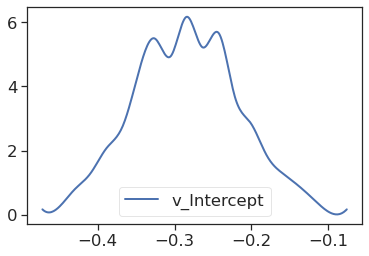

In [1594]:
vcong = m_diag_simple2.nodes_db.node["v_Intercept"]
hddm.analyze.plot_posterior_nodes([vcong], bins=20)
(vcong.trace() < 0).mean()

In [1588]:
#m_diag.print_stats()
stats = m_diag_simple2.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]','a_rDV'])]

mean       std      2.5q       25q  \
t                             0.543912  0.014063  0.517119  0.535097   
v_Intercept                  -0.283596   0.06634 -0.412054 -0.330074   
v_C(cong, Treatment(0))[T.1]  1.420469  0.057275  1.296924  1.383866   
v_rDV                         1.543647  0.173702  1.195716   1.42077   
a_Intercept                    1.59797  0.041792  1.518413  1.567797   
a_C(cong, Treatment(0))[T.1]  0.296343  0.039944  0.216812  0.270251   
a_rDV                         0.805553  0.132671   0.55571  0.709409   

                                   50q       75q     97.5q    mc err  
t                             0.544173  0.552352   0.57175  0.000596  
v_Intercept                  -0.284688 -0.238912 -0.149334  0.004633  
v_C(cong, Treatment(0))[T.1]  1.425225  1.458745    1.5217  0.004449  
v_rDV                         1.547035  1.653533   1.89599  0.011729  
a_Intercept                   1.595067  1.626792  1.686053  0.002899  
a_C(cong, Treatment(0))[T.1]  0.297761  0.321472  0.378787  0.002966  
a_rDV                         0.799946  0.896513   1.07334  0.009841

In [ ]:
CALCULA Z SEPARADAMENTE (HAY UN BIAS FIJO)

In [1587]:
#m_diag.print_stats()
stats = m_card_simple2.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]','a_rDV'])]

mean       std      2.5q       25q  \
t                             0.565574  0.015033   0.53725  0.556307   
v_Intercept                  -0.767194  0.062507 -0.890644 -0.813044   
v_C(cong, Treatment(0))[T.1]  1.340752  0.049354  1.240642  1.308317   
v_rDV                         1.804306   0.19119  1.420458  1.674241   
a_Intercept                   1.654563  0.040645  1.570233  1.626723   
a_C(cong, Treatment(0))[T.1]  0.086215  0.028051  0.029688  0.067742   
a_rDV                         0.181316  0.121831 -0.050046  0.100027   

                                   50q       75q     97.5q    mc err  
t                             0.564932  0.575363  0.597348  0.000664  
v_Intercept                  -0.763406 -0.724577 -0.646506  0.005003  
v_C(cong, Treatment(0))[T.1]  1.340814  1.375402  1.434748  0.003219  
v_rDV                         1.805679  1.938285  2.155865  0.014135  
a_Intercept                   1.654464  1.682033  1.733167   0.00258  
a_C(cong, Treatment(0))[T.1]  0.086255  0.104602  0.145149  0.001686  
a_rDV                         0.174062  0.260806  0.434316  0.009527

Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

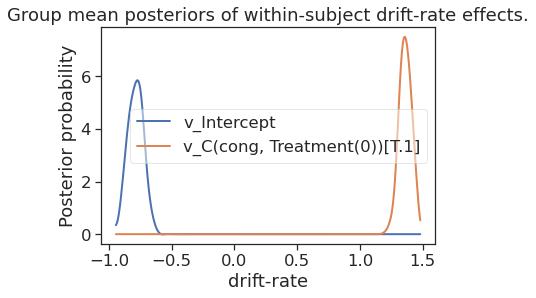

In [1589]:
v0, v1, = m_card_simple2.nodes_db.loc[["v_Intercept", "v_C(cong, Treatment(0))[T.1]"], 'node']
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


In [1526]:
m_diag = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 1)], ['v ~ rDV*C(cong,Treatment(0))','a ~ rDV*C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV*C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_rDV:C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c771ef0d0>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV*C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV', 'a_rDV:C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c774ef940>}
Uses Identity Link


In [1527]:
m_diag.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_diag.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1622.5 sec

In [1534]:
#m_diag.print_stats()
stats = m_diag.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_rDV:C(cong, Treatment(0))[T.1]', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]'
                       , 'a_rDV', 'a_rDV:C(cong, Treatment(0))[T.1]'])]

mean       std      2.5q       25q  \
t                                  0.54265  0.013823  0.516685  0.533069   
v_Intercept                      -0.316817   0.08546 -0.477126  -0.37644   
v_C(cong, Treatment(0))[T.1]       1.41876  0.093186  1.250601  1.344464   
v_rDV                             1.657082  0.351501  0.984342  1.409774   
v_rDV:C(cong, Treatment(0))[T.1]  0.107045  0.409659 -0.691113 -0.171867   
a_Intercept                       1.685744  0.048941  1.592634  1.650612   
a_C(cong, Treatment(0))[T.1]      0.157874  0.051379   0.05781  0.122499   
a_rDV                             0.260858  0.216617  -0.14992  0.109671   
a_rDV:C(cong, Treatment(0))[T.1]   0.84378   0.25457  0.319943  0.669281   

                                       50q       75q     97.5q    mc err  
t                                 0.541928  0.552041  0.571649  0.000566  
v_Intercept                        -0.3168 -0.253433 -0.155906  0.007093  
v_C(cong, Treatment(0))[T.1]      1.420838  1.487649  1.595495  0.008463  
v_rDV                             1.662503  1.887231  2.394733  0.031876  
v_rDV:C(cong, Treatment(0))[T.1]  0.113283  0.400659  0.860292  0.037952  
a_Intercept                       1.684745  1.722032  1.775566  0.003886  
a_C(cong, Treatment(0))[T.1]      0.158452  0.188487  0.264034  0.004384  
a_rDV                             0.260589  0.408028  0.695199  0.019176  
a_rDV:C(cong, Treatment(0))[T.1]  0.835366  1.007308  1.352248   0.02281

CARDINAL

In [1522]:
m_card = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 0)], ['v ~ rDV*C(cong,Treatment(0))','a ~ rDV*C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV*C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_rDV:C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c774e7280>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV*C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV', 'a_rDV:C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c75dfb9d0>}
Uses Identity Link


In [1523]:
m_card.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_card.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1586.6 sec

In [1562]:
#m_diag.print_stats()
stats = m_card.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_rDV:C(cong, Treatment(0))[T.1]', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]'
                       , 'a_rDV', 'a_rDV:C(cong, Treatment(0))[T.1]'])]

mean       std      2.5q       25q  \
t                                  0.56349  0.014732  0.537157  0.552898   
v_Intercept                      -0.853164  0.072843  -1.00772 -0.896676   
v_C(cong, Treatment(0))[T.1]       1.48026  0.091545  1.324609  1.414831   
v_rDV                              2.22316  0.297895  1.638845  2.021449   
v_rDV:C(cong, Treatment(0))[T.1] -0.642565  0.383114 -1.504467 -0.867743   
a_Intercept                        1.68519  0.048146   1.59472  1.650863   
a_C(cong, Treatment(0))[T.1]      0.041834  0.057917 -0.059569  0.002482   
a_rDV                             0.013579  0.162747 -0.304522 -0.103801   
a_rDV:C(cong, Treatment(0))[T.1]  0.219014  0.240313 -0.233909  0.037009   

                                       50q       75q     97.5q    mc err  
t                                 0.562847  0.573465  0.592504   0.00062  
v_Intercept                      -0.853105 -0.803719 -0.725051  0.006285  
v_C(cong, Treatment(0))[T.1]      1.472845  1.537429  1.674521  0.007951  
v_rDV                             2.219333  2.418963  2.814461  0.026464  
v_rDV:C(cong, Treatment(0))[T.1]  -0.59737 -0.369415  0.028233  0.033911  
a_Intercept                       1.686235  1.720043  1.778686  0.003647  
a_C(cong, Treatment(0))[T.1]      0.039881  0.083282  0.162162  0.005189  
a_rDV                             0.014954  0.143729  0.292417   0.01449  
a_rDV:C(cong, Treatment(0))[T.1]  0.221616  0.394626  0.666585  0.022004

In [1567]:
m_card_simple1 = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 0)], ['v ~ C(cong,Treatment(0))','a ~ C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c77bd4790>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c75990d30>}
Uses Identity Link


In [1568]:
m_card_simple1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_card_simple1.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 807.3 sec

In [ ]:
simple 1 6959.065120
simple 2 6864.165979
full 6862.939843
simple 2 full 6843.851316


In [1569]:
#m_diag.print_stats()
stats = m_card_simple1.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]','a_rDV'])]

mean       std      2.5q       25q  \
t                             0.566333  0.014361  0.538866  0.556874   
v_Intercept                  -0.440003  0.047395 -0.529984 -0.472704   
v_C(cong, Treatment(0))[T.1]  1.453734   0.04902   1.35727  1.421906   
a_Intercept                   1.668458  0.036555   1.59573    1.6444   
a_C(cong, Treatment(0))[T.1]  0.101873  0.027339  0.050546  0.083599   

                                   50q       75q     97.5q    mc err  
t                                0.566  0.575905  0.595285  0.000574  
v_Intercept                  -0.441206 -0.408231 -0.345652  0.003382  
v_C(cong, Treatment(0))[T.1]  1.452102  1.486656  1.551321   0.00336  
a_Intercept                   1.668179    1.6925  1.740284  0.002068  
a_C(cong, Treatment(0))[T.1]  0.102477  0.120579  0.153428  0.001682

In [1559]:
m_card_simple2 = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 0)], ['v ~ rDV+C(cong,Treatment(0))','a ~ rDV+C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV+C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0d1ddb4310>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV+C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c7848bee0>}
Uses Identity Link


In [1560]:
m_card_simple2.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_card_simple2.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1171.2 sec

In [1566]:
#m_diag.print_stats()
stats = m_card_simple2.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]','a_rDV'])]

mean       std      2.5q       25q  \
t                             0.565574  0.015033   0.53725  0.556307   
v_Intercept                  -0.767194  0.062507 -0.890644 -0.813044   
v_C(cong, Treatment(0))[T.1]  1.340752  0.049354  1.240642  1.308317   
v_rDV                         1.804306   0.19119  1.420458  1.674241   
a_Intercept                   1.654563  0.040645  1.570233  1.626723   
a_C(cong, Treatment(0))[T.1]  0.086215  0.028051  0.029688  0.067742   
a_rDV                         0.181316  0.121831 -0.050046  0.100027   

                                   50q       75q     97.5q    mc err  
t                             0.564932  0.575363  0.597348  0.000664  
v_Intercept                  -0.763406 -0.724577 -0.646506  0.005003  
v_C(cong, Treatment(0))[T.1]  1.340814  1.375402  1.434748  0.003219  
v_rDV                         1.805679  1.938285  2.155865  0.014135  
a_Intercept                   1.654464  1.682033  1.733167   0.00258  
a_C(cong, Treatment(0))[T.1]  0.086255  0.104602  0.145149  0.001686  
a_rDV                         0.174062  0.260806  0.434316  0.009527

In [1575]:
m_card_confi = hddm.models.HDDMRegressor(data[(data.nrep == 1)&(data.cond == 0)], ['v ~ confi+rDV+C(cong,Treatment(0))','a ~ confi+rDV+C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' confi+rDV+C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_confi', 'v_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c75990670>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' confi+rDV+C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_confi', 'a_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c75990700>}
Uses Identity Link


In [1576]:
m_card_confi.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m_card_confi.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1411.3 sec

In [1578]:
#m_diag.print_stats()
stats = m_card_confi.gen_stats()
stats[stats.index.isin(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_confi', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]','a_rDV', 'a_confi'])]

mean       std      2.5q       25q  \
t                             0.565578  0.014115   0.53695  0.555998   
v_Intercept                  -0.743061  0.051529  -0.84263  -0.77874   
v_C(cong, Treatment(0))[T.1]  1.317325   0.04792  1.228342  1.283532   
v_confi                       0.124214  0.054624  0.015926  0.089503   
v_rDV                         1.690018  0.182454  1.333676  1.562755   
a_Intercept                   1.647694  0.037637  1.573333  1.621333   
a_C(cong, Treatment(0))[T.1]  0.105147  0.027532  0.050503  0.086058   
a_confi                      -0.137646  0.032068 -0.195889 -0.160693   
a_rDV                         0.233926  0.096173  0.040592  0.168592   

                                   50q       75q     97.5q    mc err  
t                             0.565647  0.574676  0.594281  0.000585  
v_Intercept                  -0.743972 -0.705836 -0.643109  0.003878  
v_C(cong, Treatment(0))[T.1]  1.317389  1.349432  1.412964  0.002677  
v_confi                       0.124451  0.159607    0.2344  0.002233  
v_rDV                         1.696824  1.815762  2.046505  0.012855  
a_Intercept                   1.647929  1.672151  1.722057  0.002159  
a_C(cong, Treatment(0))[T.1]  0.105712  0.125025  0.156164  0.001705  
a_confi                      -0.138429 -0.116067 -0.073652  0.001501  
a_rDV                         0.238692    0.2993  0.429939  0.006977

Plotting t
Plotting v_Intercept
Plotting v_C(cong, Treatment(0))[T.1]
Plotting v_confi
Plotting v_rDV
Plotting a_Intercept
Plotting a_C(cong, Treatment(0))[T.1]
Plotting a_confi
Plotting a_rDV


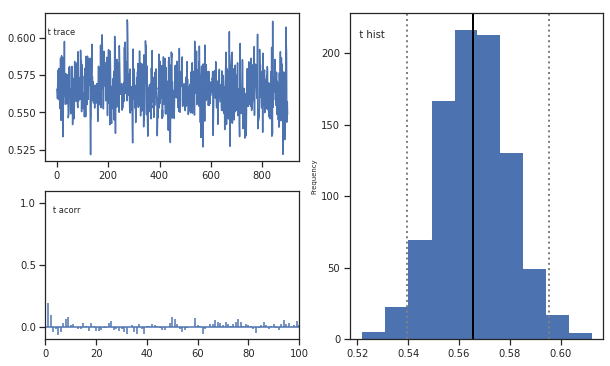

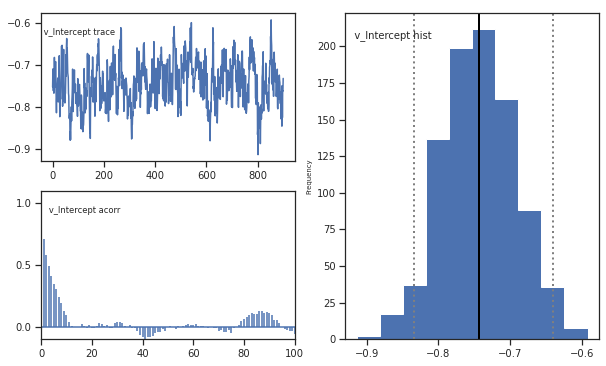

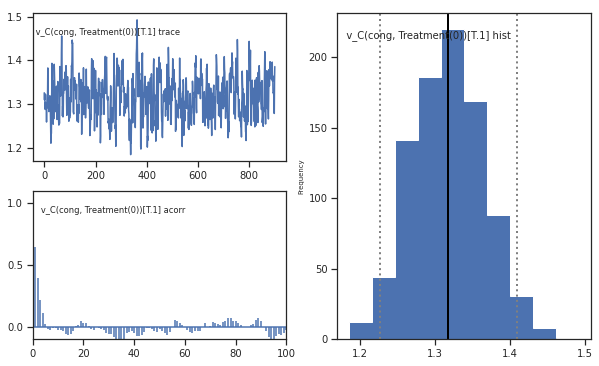

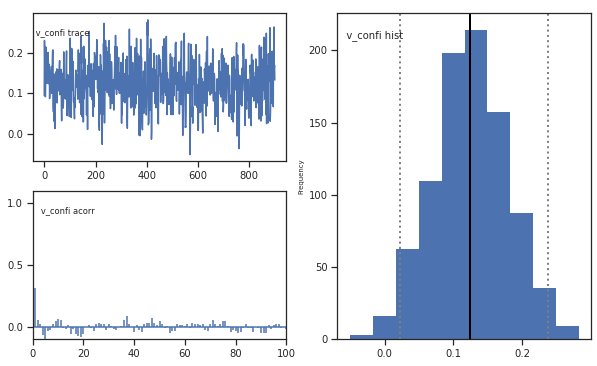

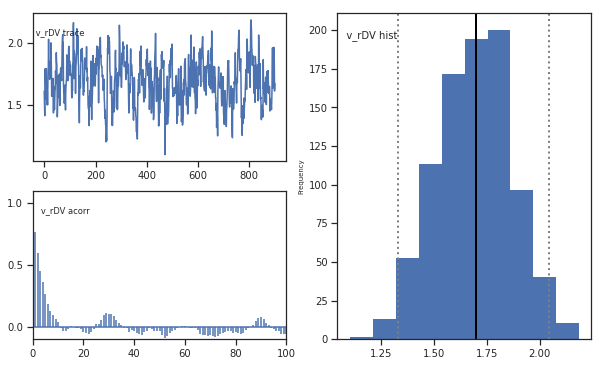

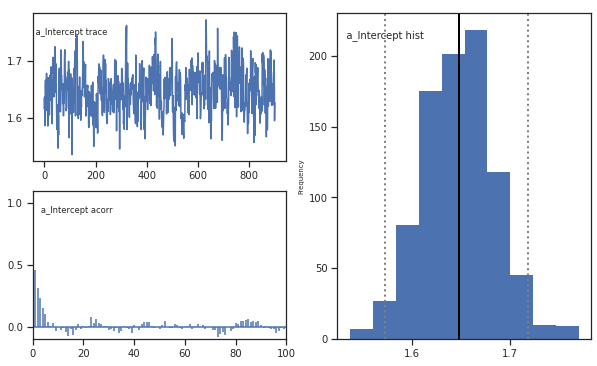

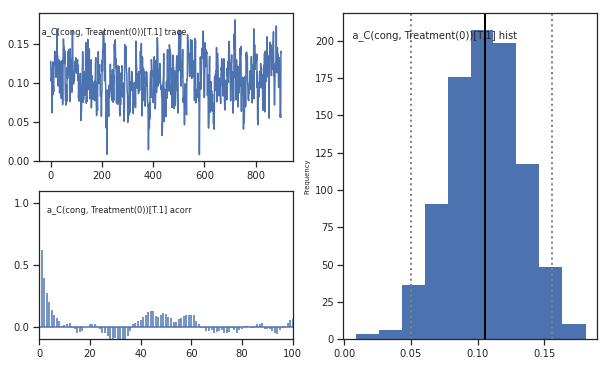

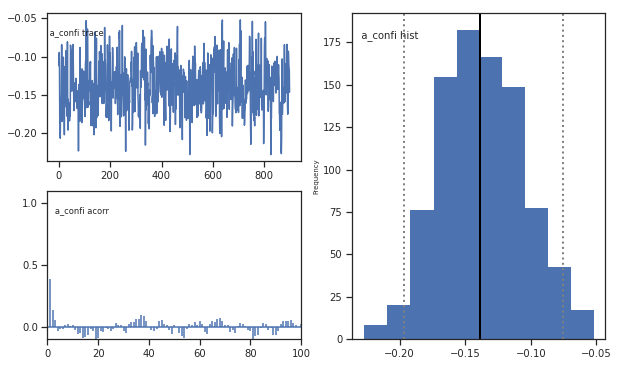

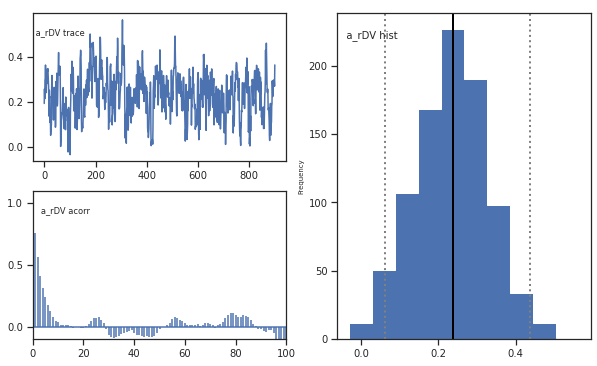

In [1584]:
m_card_confi.plot_posteriors(['t', 'v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_confi', 'a_Intercept', 'a_C(cong, Treatment(0))[T.1]','a_rDV', 'a_confi'])


In [1496]:
m2 = hddm.models.HDDMRegressor(dats, ['v ~ rDV*C(cong,Treatment(0))','a ~ rDV*C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV*C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_rDV:C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0d16ae8940>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV*C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV', 'a_rDV:C(cong, Treatment(0))[T.1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c87e67dc0>}
Uses Identity Link


In [1497]:
m2.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m2.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1620.8 sec

In [1498]:
m2.print_stats()


                                      mean       std      2.5q       25q       50q       75q     97.5q    mc err
t                                 0.541626  0.014335  0.513779  0.531857  0.541701  0.551503  0.569436    0.0006
t_std                             0.083777  0.011677  0.064155   0.07571  0.082507  0.090592  0.110572  0.000621
t_subj.1                           0.68977  0.023377  0.625647  0.678952  0.693244  0.704515  0.726403  0.001097
t_subj.2                          0.566156  0.029124  0.506281  0.547563  0.566905  0.587861  0.618549  0.001344
t_subj.3                          0.539208  0.083729  0.389092  0.481429  0.530338  0.594006  0.714185  0.002734
t_subj.4                          0.578258  0.023395  0.522815  0.564913  0.581608  0.594113   0.61705  0.001286
t_subj.5                          0.542889  0.028431  0.479142  0.528456  0.547959  0.562688  0.588331  0.001464
t_subj.6                           0.55457  0.020047  0.509318  0.542369  0.556451  0.569042  0.

Plotting v_Intercept
Plotting v_C(cong, Treatment(0))[T.1]
Plotting v_rDV
Plotting v_rDV:C(cong, Treatment(0))[T.1]


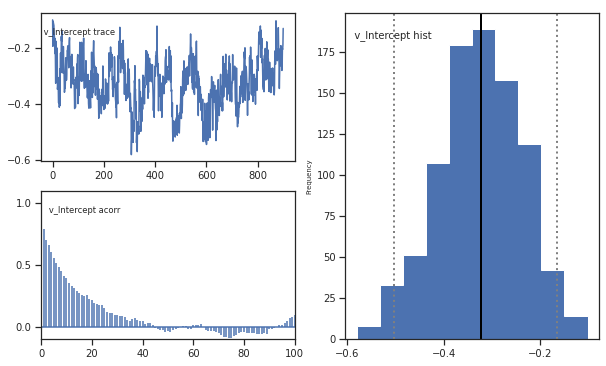

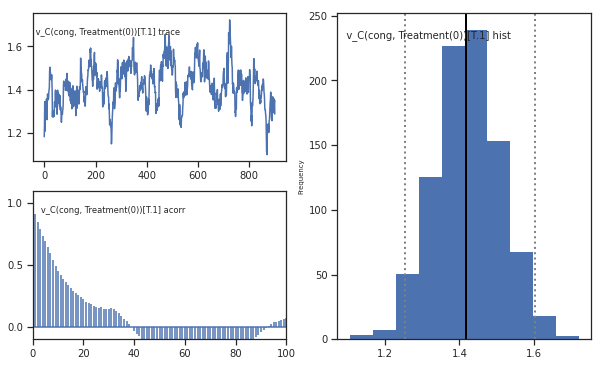

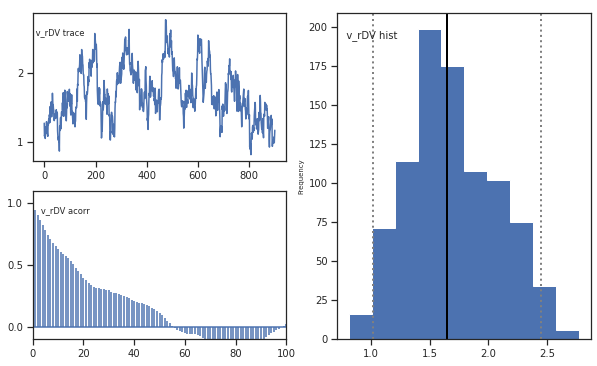

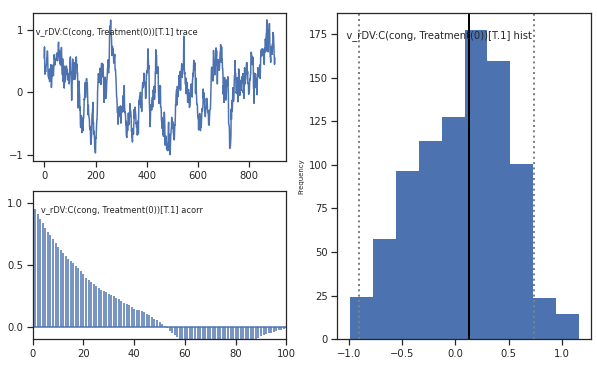

In [1502]:
m2.plot_posteriors(['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV', 'v_rDV:C(cong, Treatment(0))[T.1]','z'])


In [1473]:
m3.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m3.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1616.3 sec

In [1491]:
m3.print_stats()


NameError: name 'm3' is not defined

In [1494]:
m3 = hddm.models.HDDMRegressor(dats, [ 'v ~ rDV*C(cong,Treatment(0)',
                                     'a ~ rDV*C(cong,Treatment(0)'])

PatsyError: unclosed bracket in embedded Python expression
    rDV*C(cong,Treatment(0)
        ^^^^^^^^^^^^^^^^^^^

In [1499]:
m4 = hddm.models.HDDMRegressor(dats, [ 'v ~ rDV+C(cong,Treatment(0))',
                                     'a ~ rDV+C(cong,Treatment(0))'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV+C(cong,Treatment(0))', 'params': ['v_Intercept', 'v_C(cong, Treatment(0))[T.1]', 'v_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0cf5ba4670>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV+C(cong,Treatment(0))', 'params': ['a_Intercept', 'a_C(cong, Treatment(0))[T.1]', 'a_rDV'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0d1decb790>}
Uses Identity Link


In [1500]:
m4.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m4.sample(1000, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 1209.0 sec

In [1501]:
m4.print_stats()


                                  mean       std      2.5q       25q       50q       75q     97.5q    mc err
t                             0.543052  0.013749   0.51645  0.533511  0.543247  0.552563  0.570447  0.000542
t_std                         0.082893  0.010521   0.06492  0.075223  0.082135  0.089824  0.105932  0.000487
t_subj.1                      0.690751  0.023996  0.629758  0.678168  0.692762  0.707575   0.72902  0.001325
t_subj.2                      0.567764  0.026286  0.512976  0.549231  0.569007  0.587158  0.616069  0.001182
t_subj.3                      0.539741  0.077915  0.389918  0.487506  0.538738  0.592344  0.707071  0.002776
t_subj.4                      0.575058  0.022365  0.527186  0.561233  0.575329  0.589445  0.619084  0.001124
t_subj.5                      0.542828  0.028743  0.467556   0.52913  0.547421  0.562485  0.589487  0.001485
t_subj.6                      0.554401  0.020853  0.511049  0.540793  0.555852  0.567802  0.593166  0.000929
t_subj.7           

In [1458]:
m = hddm.models.HDDMRegressor(dats, ['v ~ rDV:C(cong)',
                                     'a ~ rDV:C(cong)'])

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': ' rDV:C(cong)', 'params': ['v_Intercept', 'v_rDV:C(cong)[0]', 'v_rDV:C(cong)[1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c86605af0>}
Uses Identity Link
Reg Model:
{'outcome': 'a', 'model': ' rDV:C(cong)', 'params': ['a_Intercept', 'a_rDV:C(cong)[0]', 'a_rDV:C(cong)[1]'], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7f0c879faa60>}
Uses Identity Link


In [1470]:
m.print_stats()


                         mean       std      2.5q       25q       50q       75q     97.5q    mc err
t                    0.543359  0.014134  0.515769  0.534399  0.542883  0.552348  0.572003  0.000416
t_std                0.084089   0.01141  0.064224  0.075998  0.082965  0.091271  0.109208  0.000373
t_subj.1              0.69166    0.0229  0.641567  0.678986  0.694279   0.70705  0.728727  0.000653
t_subj.2             0.569334  0.025748  0.515509   0.55204  0.571338  0.588694  0.613493  0.000733
t_subj.3             0.545651  0.085209   0.38969   0.48828   0.54294  0.597836  0.722761  0.001887
t_subj.4             0.581249  0.023038  0.530982  0.566307  0.583331  0.597958  0.620921  0.000692
t_subj.5             0.541698  0.027174  0.473512  0.527619  0.545322  0.560207  0.584387  0.000864
t_subj.6             0.556214  0.019862  0.515131  0.543808  0.558002   0.56982  0.591563  0.000567
t_subj.7             0.484579  0.020811  0.439085  0.471952  0.486223  0.498937  0.520519  0.000643


In [ ]:
params = mod_stim.optimize('chisquare')


TypeError: __init__() missing 1 required positional argument: 'models'

In [1478]:
m1.print_stats()


                         mean       std      2.5q       25q       50q       75q     97.5q    mc err
t                    0.542559  0.013687  0.515523  0.533371   0.54244  0.551603  0.569978  0.000621
t_std                 0.08307  0.011397  0.064233  0.074634  0.082407  0.089934  0.109415  0.000626
t_subj.1             0.690889   0.02383  0.625756  0.678954   0.69348  0.707456  0.727539  0.001146
t_subj.2             0.566443  0.027007  0.508901  0.549103  0.568177  0.586547  0.611644  0.001227
t_subj.3             0.550412  0.083162  0.408379  0.492851  0.546208  0.600969  0.723356  0.003213
t_subj.4             0.575578  0.024213   0.52546  0.559838  0.577184  0.593697  0.615607  0.001225
t_subj.5             0.541767  0.028814  0.465444  0.528298  0.546668   0.56085  0.586492  0.001412
t_subj.6             0.553704  0.019778  0.511499   0.54131  0.555272  0.567995  0.588895  0.000904
t_subj.7             0.482709  0.020798  0.440788  0.470052  0.483938  0.496161   0.52207  0.000914


In [ ]:
m.nodes_db.a

In [1468]:
print(m.nodes_db.knode_name)

t                 t
t_std         t_std
t_rate       t_rate
t_shape     t_shape
t_subj.1     t_subj
             ...   
wfpt.40        wfpt
wfpt.41        wfpt
wfpt.42        wfpt
wfpt.43        wfpt
wfpt.44        wfpt
Name: knode_name, Length: 279, dtype: object


In [1469]:
v0, v1, = m.nodes_db.loc[["v(0)", "v(1)"], 'node']
a0, a1, = m.nodes_db.loc[["a(0)", "a(1)"], 'node']


KeyError: "None of [Index(['v(0)', 'v(1)'], dtype='object')] are in the [index]"

In [1435]:
hddm.analyze.plot_posterior_nodes([v0, v1])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')


AttributeError: 'Normal' object has no attribute 'trace'

<Figure size 432x288 with 0 Axes>

In [1459]:
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(1500, burn=100)`

 [-----------------100%-----------------] 3001 of 3000 complete in 5039.3 sec

In [64]:
np.shape(mat_contents['fulldata'])

(1967, 10, 27)

In [59]:
data_np =  np.array(mat_contents['fulldata'])

In [61]:
np.shape(data_np)

(1967, 10, 27)

In [1396]:
dataresp.loc[dataresp. ==]

subj_idx nblock  nrep cond-1  blocktype       rDV  cond  deci-1  deci  \
0            1      0     0      0  nonrepeat  0.089044     1       0     1   
1            1      0     1      1  nonrepeat  0.068067     1       1     1   
2            1      0     0      1  nonrepeat -0.027166     0       1     1   
3            1      0     1      0  nonrepeat  0.001867     0       1     0   
4            1      0     0      0  nonrepeat -0.086152     0       0     0   
...        ...    ...   ...    ...        ...       ...   ...     ...   ...   
14339       44      3     1      1     repeat  0.204563     1       0     1   
14340       44      3     0      1     repeat  0.289281     1       1     1   
14341       44      3     1      1     repeat  0.289281     1       1     1   
14342       44      3     0      1     repeat -0.296323     0       1     0   
14343       44      3     1      0     repeat -0.296323     0       0     0   

       response  confi        rt  cong  
0             1   0.10  2.044453     1  
1             1   0.35  2.114065     1  
2             0   0.75  1.752747     1  
3             1  -0.15  1.981836     1  
4             1   0.40  2.481966     1  
...         ...    ...       ...   ...  
14339         1   0.75  0.697239     1  
14340         1   0.70  0.947157     1  
14341         1   0.50  0.690167     1  
14342         1   0.60  0.989039     1  
14343         1   0.70  0.836251     1  

[14186 rows x 13 columns]

In [ ]:
mod_stimblockty = hddm.HDDMStimCoding(dataresp[dataresp.nrep == 1], include='z',  depends_on={'v': ['blocktype'],'a': ['blocktype']}, stim_col='cond', split_param='v')


In [1210]:
params = mod_stim.optimize('chisquare')


Setting model to be non-informative
Adding z to includes.


KeyError: 'stim'

In [1110]:
params1

OrderedDict([('a(0)', 1.7147257514420025),
             ('a(1)', 1.6153618490856347),
             ('v(0)', 0.5531123641568265),
             ('v(1)', 0.6939623712487335),
             ('t', 0.6256032835826126),
             ('z_trans', 0.07986424603813555),
             ('z', 0.5199554558169336)])

<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _LONG format analyses_

In [1623]:
# df to long format
dflong = pd.melt(df, id_vars=['subj','blocktype','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','confi','conf_lvl','conf_lvl-1','RT'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['subj','blocktype','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','confi','conf_lvl','conf_lvl-1','RT'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
dflong.orient = np.rad2deg(dflong.orient) # transform to degrees
del out

dflong = dflong.sort_values(['nblock','subj','ntrial','nrep',],ascending=[True,True,True,True]) # reorder variables
dflong.reset_index(drop=True, inplace=True)
dflong.insert(5, "stim_cond", "D")
dflong.loc[(dflong.dv < 0), "stim_cond"]  = "C"


dflong.insert(7, 'cong_deci', "I") # if stim is congruent with previous repetition decosion category
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['deci-1'] == 1) & (dflong.stim_cond == 'D'), "cong_deci"]  = "C"



dflong.insert(8, 'cong_stim', 'I') # if stim is congruent with previous repetition mean category
dflong.loc[(dflong['cond-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['cond-1'] == 'D') & (dflong.stim_cond == 'D'), 'cong_stim'] = 'C'

# relabeling variables
#dflong["cond-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-2"].replace({0: "C", 1: "D"}, inplace=True)


dflong['ov'] = signal.sawtooth(2*np.deg2rad(dflong.orient), 0.5) # orientation variable (here I define an ov to make stimuli that differ by less of 45 degrees or more than 135 as similar)
# plt.scatter(dflong.orient,dflong['ov']) # see here


dflong.head(5)

subj  blocktype nblock  ntrial  nrep stim_cond cond-1 cong_deci cong_stim  \
0  s01  nonrepeat      0       0     0         D      0         I         I   
1  s01  nonrepeat      0       0     0         C      0         C         C   
2  s01  nonrepeat      0       0     0         D      0         I         I   
3  s01  nonrepeat      0       0     0         C      0         C         C   
4  s01  nonrepeat      0       0     0         D      0         I         I   

   cond  deci-2  deci-1  deci  corr-1  correct  confi conf_lvl conf_lvl-1  \
0     1       0       0     1       0        1    0.1        L          L   
1     1       0       0     1       0        1    0.1        L          L   
2     1       0       0     1       0        1    0.1        L          L   
3     1       0       0     1       0        1    0.1        L          L   
4     1       0       0     1       0        1    0.1        L          L   

         RT stim        dv      orient        ov  
0  2.044453   d1  0.828372   41.138370 -0.085814  
1  2.044453   d2 -0.956710    0.974028 -0.978355  
2  2.044453   d3  0.360338  120.607616  0.319831  
3  2.044453   d4 -0.087842  110.523559  0.543921  
4  2.044453   d5  0.939380  136.363955 -0.030310

### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [1624]:
# Adding decision variable difference & congruency between stim
out = np.diff(dflong.dv, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiffDV = out

stim_dec = dflong.dv.copy()
stim_dec = stim_dec.to_numpy()
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0
diffDV = np.absolute(np.diff(stim_dec, prepend = 0)) #  change = 1, repeated = 0

# Adding physical orientation variable difference & congruency between stim

out = np.diff(dflong.ov, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiff_stim_ori = out

stim_ori = dflong.ov.copy()
stim_ori = stim_ori.to_numpy()
# Simplify the labels
stim_ori[stim_ori > 0] = 1
stim_ori[stim_ori < 0] = 0
diffstim_ori= np.absolute(np.diff(stim_ori, prepend = 0))


# Merging all the datasets
dflong_seq = pd.concat([dflong, pd.Series(absdiffDV, dtype=np.int32, name='abs_diffDV'), pd.Series(diffDV, dtype=np.int32, name='cong_stim_DV'),pd.Series(stim_ori, dtype=np.int32, name='stim_cat_OV'),pd.Series(stim_ori, dtype=np.int32, name='abs_diffOV'), pd.Series(diffstim_ori, dtype=np.int32, name='cong_stim_OV')], axis=1).copy()

dflong_seq = dflong_seq.loc[dflong_seq['stim'] != "d1"] # now I remove d1 as it is not informative and it would add noise to this analysis
dflong_seq.head(2)

subj  blocktype nblock  ntrial  nrep stim_cond cond-1 cong_deci cong_stim  \
1  s01  nonrepeat      0       0     0         C      0         C         C   
2  s01  nonrepeat      0       0     0         D      0         I         I   

   cond  deci-2  deci-1  deci  corr-1  correct  confi conf_lvl conf_lvl-1  \
1     1       0       0     1       0        1    0.1        L          L   
2     1       0       0     1       0        1    0.1        L          L   

         RT stim        dv      orient        ov  abs_diffDV  cong_stim_DV  \
1  2.044453   d2 -0.956710    0.974028 -0.978355    1.785082             1   
2  2.044453   d3  0.360338  120.607616  0.319831    1.317048             1   

   stim_cat_OV  abs_diffOV  cong_stim_OV  
1            0           0             0  
2            1           1             1

Logisitc regression model with the category of the previous stimuli sample

In [1625]:
# First, build a logistic model with presentations and the category of previous sample

dflong_seq_clean = dflong_seq[(dflong_seq.subj != 's16') & (dflong_seq.subj != 's22') &  (dflong_seq.subj != 's10')]

formula = "deci ~ dv"

log_regpre_deci_params = dflong_seq_clean.groupby(['subj', 'cong_stim_DV','cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

subj  cong_stim_DV  cong_stim_OV  level_3  intercept    weight       PSE
0  s01             0             0        0   0.357110  1.990057 -0.179447
1  s01             0             1        0   0.691819  0.894296 -0.773591
2  s01             1             0        0   0.473572  0.762977 -0.620689
3  s01             1             1        0   0.691848 -0.368531  1.877314
4  s02             0             0        0   0.184827  1.711551 -0.107988

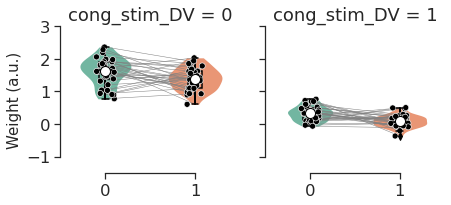

In [1626]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_regpre_deci_params

ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_stim_OV"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'cong_stim_DV',  height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
#g._margin_titles_texts[0].set_text("Cardinal")
#g._margin_titles_texts[0].set_size("20")
#g._margin_titles_texts[1].set_text("Diagonal")
#g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


<font size="4"> Statistical tests for Beta Weight

In [1627]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['cong_stim_DV','cong_stim_OV'], subject = 'subj', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

Source         SS  ddof1  ddof2         MS  \
0                 cong_stim_DV  52.589792      1     31  52.589792   
1                 cong_stim_OV   1.720600      1     31   1.720600   
2  cong_stim_DV * cong_stim_OV   0.000001      1     31   0.000001   

            F         p-unc     p-GG-corr           np2  eps  
0  640.995481  2.846470e-22  2.846470e-22  9.538687e-01  1.0  
1   14.294956  6.690236e-04  6.690236e-04  3.155971e-01  1.0  
2    0.000019  9.965796e-01  9.965796e-01  6.024289e-07  1.0

Post-hoc t-test

In [ ]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

In [ ]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

In [ ]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

In [ ]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

<font size="5"> _5B. Intercept._

In [ ]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

<font size="4"> Statistical tests for Beta Weight

Logisitc regression model with congruency with stimuli sample by each presentation

In [1641]:
dflong.head()

subj  blocktype nblock  ntrial  nrep stim_cond cond-1 cong_deci cong_stim  \
0  s01  nonrepeat      0       0     0         D      0         I         I   
1  s01  nonrepeat      0       0     0         C      0         C         C   
2  s01  nonrepeat      0       0     0         D      0         I         I   
3  s01  nonrepeat      0       0     0         C      0         C         C   
4  s01  nonrepeat      0       0     0         D      0         I         I   

   cond  deci-2  deci-1  deci  corr-1  correct  confi conf_lvl conf_lvl-1  \
0     1       0       0     1       0        1    0.1        L          L   
1     1       0       0     1       0        1    0.1        L          L   
2     1       0       0     1       0        1    0.1        L          L   
3     1       0       0     1       0        1    0.1        L          L   
4     1       0       0     1       0        1    0.1        L          L   

         RT stim        dv      orient        ov  
0  2.044453   d1  0.828372   41.138370 -0.085814  
1  2.044453   d2 -0.956710    0.974028 -0.978355  
2  2.044453   d3  0.360338  120.607616  0.319831  
3  2.044453   d4 -0.087842  110.523559  0.543921  
4  2.044453   d5  0.939380  136.363955 -0.030310

In [1629]:
sj

's16'

In [1630]:
formula = "deci ~ dv"

subjs = np.array(['s01', 's02', 's03', 's04', 's06', 's07', 's08', 's09',
      's11','s12', 's13', 's14', 's15', 's17', 's19', 's20',
       's21', 's23', 's24', 's25'])

for isubj in subjs:
    df_subj = dflong[( dflong.subj == isubj) ] # s16 does not converge
    log_reg_preDeci = df_subj.groupby(['nrep', 'cong_deci', 'stim_cond', 'blocktype']).apply(log_reg_fit, formula) 
    

In [1631]:
df_subj = dflong[(dflong.subj != 's05') & (dflong.subj != 's16') & (dflong.subj != 's22') & (dflong.subj != 's10')] # s16 does not converge
formula = "deci ~ dv"
log_reg_cong_stim = df_subj.groupby(['subj','nrep', 'cong_deci', 'stim_cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head(5)

subj  nrep cong_deci stim_cond  level_4  intercept    weight        PSE
0  s01     0         C         C        0   0.768104  1.120111  -0.685739
1  s01     0         C         D        0   0.081644  1.675498  -0.048728
2  s01     0         I         C        0   0.365506  0.391879  -0.932703
3  s01     0         I         D        0   0.074982  1.769408  -0.042377
4  s01     1         C         C        0  -0.868794  0.034216  25.391816

'\n# you can access different features of the plot nad panels using for loops\nfor (row_val, col_val), ax in g.axes_dict.items():\n    if row_val == "Lunch" and col_val == "Female":\n        ax.set_facecolor(".95")\n    else:\n        ax.set_facecolor((0, 0, 0, 0))\n#g.savefig("facet_plot.png")\n'

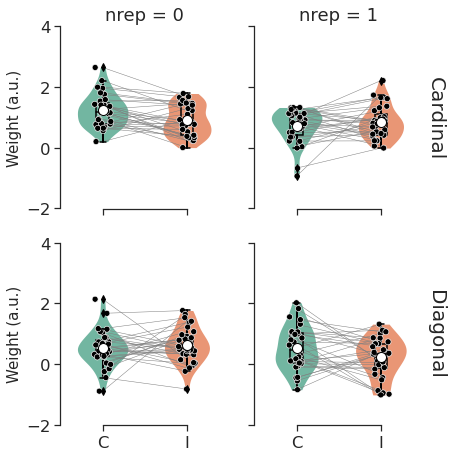

In [1632]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
#dat = log_reg_cong_stim[ (log_reg_cong_stim.blocktype=='repeat')]
dat = log_reg_cong_stim #[ (log_reg_cong_stim['conf_lvl-1']=='H')]
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1)]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_deci"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'nrep',  row= 'stim_cond', height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-2,4], yticks=[-2, 0, 2, 4])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
g._margin_titles_texts[0].set_text("Cardinal")
g._margin_titles_texts[0].set_size("20")
g._margin_titles_texts[1].set_text("Diagonal")
g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


'''
# you can access different features of the plot nad panels using for loops
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Lunch" and col_val == "Female":
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))
#g.savefig("facet_plot.png")
'''

In [1636]:

dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0) ]


pg.rm_anova(dv = 'weight', within = ['cong_deci', 'stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

Source        SS  ddof1  ddof2        MS          F  \
0              cong_deci  0.417581      1     30  0.417581   1.986652   
1              stim_cond  7.544057      1     30  7.544057  17.369538   
2  cong_deci * stim_cond  1.427669      1     30  1.427669   5.092023   

      p-unc  p-GG-corr       np2  eps  
0  0.168974   0.168974  0.062109  1.0  
1  0.000240   0.000240  0.366682  1.0  
2  0.031480   0.031480  0.145105  1.0

In [1640]:

dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1) & (log_reg_cong_stim.stim_cond=='D') ]


pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

Source         SS  DF        MS         F     p-unc      np2  eps
0  cong_deci   1.345684   1  1.345684  3.505689  0.070935  0.10463  1.0
1      Error  11.515714  30  0.383857       NaN       NaN      NaN  NaN

In [ ]:
diff_cong_stim = log_reg_cong_stim[log_reg_cong_stim['cong_deci'] == 'C'].copy()
diff_cong_stim.reset_index(inplace = True, drop = True)
s = log_reg_cong_stim[log_reg_cong_stim['cong_deci'] == 'I'].iloc[:,[6,7,8]].copy()
s.reset_index(inplace = True, drop = True)

diff_cong_stim.iloc[:,[6,7,8]] = diff_cong_stim.iloc[:,[6,7,8]] - s

In [ ]:
diff_cong_stim.head(5)

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
dat = diff_cong_stim[ (diff_cong_stim.nrep==1) ]
sns.displot(data = dat,  x = "weight", kde=True, 
             bins=int(15),  kde_kws =  {'bw_adjust' : 0.6}, hue = 'blocktype')
#sns.kdeplot(data = diff_cong_stim,  x = "weight", hue = 'blocktype',  bw_adjust=0.5)

In [ ]:
dat = diff_cong_stim[  (diff_cong_stim.stim_cond =="D") ]
sns.displot(data = dat,  x = "weight", kde=True, 
             bins=int(15),  kde_kws =  {'bw_adjust' : 0.6}, hue = 'nrep')
#sns.kdeplot(data = diff_cong_stim,  x = "weight", hue = 'blocktype',  bw_adjust=0.5)

Testing for normality of distributions

In [ ]:
from scipy import stats
dat = diff_cong_stim[ (diff_cong_stim.nrep==0) & (diff_cong_stim.blocktype == 'nonrepeat')]
stats.shapiro(dat.weight)

In [ ]:
stats.shapiro(diff_cong_stim[  (diff_cong_stim.stim_cond =="D")].weight) 

Fitting a bimodal gaussian mixture model

In [ ]:
data = np.array(diff_cong_stim[(diff_cong_stim.blocktype == 'repeat')].weight).reshape(-1,1)
clf = GaussianMixture(n_components=2,  random_state=0)
clf.fit(data)

In [ ]:
x = np.array(np.linspace(-2,2,200)).reshape(-1,1)
y = clf.score_samples(x)

plt.plot(x, np.exp(y))
plt.show()

In [ ]:
plt.scatter(diff_cong_stim[(diff_cong_stim.stim_cond == 'D') & (diff_cong_stim.blocktype == 'nonrepeat') ].weight, diff_cong_stim[(diff_cong_stim.stim_cond == 'C') &  (diff_cong_stim.blocktype == 'nonrepeat')].weight)

In [ ]:
diff_cong_stim.head()

In [ ]:
rep = 1
btype = 'repeat'
plt.scatter(diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.stim_cond == 'D') ].weight, diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.stim_cond == 'C') ].weight)

In [ ]:
rep = 1

plt.scatter(diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.blocktype == 'repeat') ].weight, diff_cong_stim[(diff_cong_stim.nrep == rep) &   (diff_cong_stim.blocktype == 'nonrepeat')].weight)

In [ ]:
plt.scatter(diff_cong_stim[ (diff_cong_stim.blocktype == 'nonrepeat') ].weight, diff_cong_stim[ (diff_cong_stim.blocktype == 'repeat')].weight)

In [ ]:
diff_preDeci = log_reg_preDeci[log_reg_preDeci['deci-1'] == 1].copy()
diff_preDeci.reset_index(inplace = True, drop = True)
s = log_reg_preDeci[log_reg_preDeci['deci-1'] == 0].iloc[:,[5,6,7]].copy()
s.reset_index(inplace = True, drop = True)

diff_preDeci.iloc[:,[5,6,7]] = diff_preDeci.iloc[:,[5,6,7]] - s

In [ ]:
log_reg_cong_stim

In [ ]:
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1) & (log_reg_cong_stim.blocktype=='repeat')]
dat = log_reg_cong_stim[  (log_reg_cong_stim.nrep==1) ]

pg.rm_anova(dv = 'weight', within = ['cong_deci','stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat

In [ ]:
dat = log_reg_cong_stim #[(log_reg_cong_stim.stim_cond == 'C') ]

pg.rm_anova(dv = 'weight', within = ['cong_deci' , 'blocktype'], subject = 'npar', data=dat, detailed = True)

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') 
pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
g.margin_title[0]


In [ ]:
for margin_title in grid._margin_titles_texts:
    margin_title.set_color("red")

In [ ]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

<font size="4"> Statistical tests for Beta Weight

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') & (log_reg_cong_stim.nrep != 0)]
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [ ]:
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #this participants has not data for small bins

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

In [ ]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

In [ ]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

In [ ]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

In [ ]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

In [ ]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

<font size="2"> _t-test for ambiguous_

In [ ]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

Post-hoc t-test: one chunck for each presentation

In [ ]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

In [ ]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

In [ ]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

## METADEPRIME ANALYSES

In [ ]:
#! pip install numpyro
import numpy as np
import arviz as az
import numpyro
from metadPy.bayesian import hmetad
#from metadPy import load_dataset

# Set the number of cores used by Numpyro here
numpyro.set_host_device_count(2)

In [ ]:
def hm_metad(x):
    model, traces = hmetad(
        data=x, 
        stimuli="cond",
        accuracy="correct",
        nRatings=8,
        confidence="confi",
        backend="numpyro")
    out = az.summary(traces, var_names=["meta_d"])
    #az.plot_trace(traces, var_names=["meta_d", "cS1", "cS2"]);
    return out

In [ ]:
#df_test = df[(df.subj == 's01') | (df.subj == 's02')] # s16 does not converge
meta_dprimes = df.groupby(['subj', 'nrep','blocktype']).apply(hm_metad)
meta_dprimes.reset_index(inplace = True)

In [ ]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = meta_dprimes
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0)& (log_reg_cong_stim.blocktype=='nonrepeat')]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "nrep"; dy = "mean"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col= 'blocktype', height= 5.5, aspect=.5,margin_titles=True) # col="nrep",
g.set(ylim=[-0.65,1.5], yticks=[-0.5, 0, 0.5, 1])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['P1','P2'])
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Meta d'", fontsize = 15 )


In [ ]:
#Checking statistical differences in metadeprime between the number of repetitions & blocktype
pg.rm_anova(dv = 'mean', within = ['nrep', 'blocktype'], subject = 'subj', 
            data=meta_dprimes, detailed = True, correction = True)